# **Vaccination Prediction Project**

In [32]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [109]:
# Installing the library
!pip install category_encoders

# Importing Relevant Libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

import category_encoders as ce

from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate, cross_val_score

from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import roc_auc_score, RocCurveDisplay, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, confusion_matrix
from sklearn.metrics import confusion_matrix

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

import xgboost     # extreme gradient boosting
import warnings
warnings.filterwarnings('ignore')
# To visualize the 100 many the columns in data
pd.options.display.max_columns=100

In [111]:
# Reading in the feature data
data1 = pd.read_csv('/content/drive/MyDrive/vaccination pred/features.csv')
data1.head()

respondent_id  h1n1_concern  h1n1_knowledge  behavioral_antiviral_meds  \
0              0           1.0             0.0                        0.0   
1              1           3.0             2.0                        0.0   
2              2           1.0             1.0                        0.0   
3              3           1.0             1.0                        0.0   
4              4           2.0             1.0                        0.0   

   behavioral_avoidance  behavioral_face_mask  behavioral_wash_hands  \
0                   0.0                   0.0                    0.0   
1                   1.0                   0.0                    1.0   
2                   1.0                   0.0                    0.0   
3                   1.0                   0.0                    1.0   
4                   1.0                   0.0                    1.0   

   behavioral_large_gatherings  behavioral_outside_home  \
0                          0.0                      1.0   
1                          0.0                      1.0   
2                          0.0                      0.0   
3                          1.0                      0.0   
4                          1.0                      0.0   

   behavioral_touch_face  doctor_recc_h1n1  doctor_recc_seasonal  \
0                    1.0               0.0                   0.0   
1                    1.0               0.0                   0.0   
2                    0.0               NaN                   NaN   
3                    0.0               0.0                   1.0   
4                    1.0               0.0                   0.0   

   chronic_med_condition  child_under_6_months  health_worker  \
0                    0.0                   0.0            0.0   
1                    0.0                   0.0            0.0   
2                    1.0                   0.0            0.0   
3                    1.0                   0.0            0.0   
4                    0.0                   0.0            0.0   

   health_insurance  opinion_h1n1_vacc_effective  opinion_h1n1_risk  \
0               1.0                          3.0                1.0   
1               1.0                          5.0                4.0   
2               NaN                          3.0                1.0   
3               NaN                          3.0                3.0   
4               NaN                          3.0                3.0   

   opinion_h1n1_sick_from_vacc  opinion_seas_vacc_effective  \
0                          2.0                          2.0   
1                          4.0                          4.0   
2                          1.0                          4.0   
3                          5.0                          5.0   
4                          2.0                          3.0   

   opinion_seas_risk  opinion_seas_sick_from_vacc      age_group  \
0                1.0                          2.0  55 - 64 Years   
1                2.0                          4.0  35 - 44 Years   
2                1.0                          2.0  18 - 34 Years   
3                4.0                          1.0      65+ Years   
4                1.0                          4.0  45 - 54 Years   

          education   race     sex             income_poverty marital_status  \
0        < 12 Years  White  Female              Below Poverty    Not Married   
1          12 Years  White    Male              Below Poverty    Not Married   
2  College Graduate  White    Male  <= $75,000, Above Poverty    Not Married   
3          12 Years  White  Female              Below Poverty    Not Married   
4      Some College  White  Female  <= $75,000, Above Poverty        Married   

  rent_or_own   employment_status hhs_geo_region                census_msa  \
0         Own  Not in Labor Force       oxchjgsf                   Non-MSA   
1        Rent            Employed       bhuqouqj  MSA, Not Principle  City   
2         Own         

In [112]:
# Reading in the target data
data2 = pd.read_csv('/content/drive/MyDrive/vaccination pred/labels.csv')
data2.head()

respondent_id  h1n1_vaccine  seasonal_vaccine
0              0             0                 0
1              1             0                 1
2              2             0                 0
3              3             0                 1
4              4             0                 0

In [113]:
# Exploring the percentage breakdown of the two classes in one possible target (seasonal flu rate)
data2['seasonal_vaccine'].value_counts(normalize=True)

seasonal_vaccine
0    0.534392
1    0.465608
Name: proportion, dtype: float64

In [114]:
# Exploring the percentage breakdown of the two classes in one possible target (H1N1 flu rate)
data2['h1n1_vaccine'].value_counts(normalize=True)   # class imbalance problem

h1n1_vaccine
0    0.787546
1    0.212454
Name: proportion, dtype: float64

In [115]:
# Merging feature and target data
df = data1.merge(data2, how='left', on='respondent_id')
df.head()

respondent_id  h1n1_concern  h1n1_knowledge  behavioral_antiviral_meds  \
0              0           1.0             0.0                        0.0   
1              1           3.0             2.0                        0.0   
2              2           1.0             1.0                        0.0   
3              3           1.0             1.0                        0.0   
4              4           2.0             1.0                        0.0   

   behavioral_avoidance  behavioral_face_mask  behavioral_wash_hands  \
0                   0.0                   0.0                    0.0   
1                   1.0                   0.0                    1.0   
2                   1.0                   0.0                    0.0   
3                   1.0                   0.0                    1.0   
4                   1.0                   0.0                    1.0   

   behavioral_large_gatherings  behavioral_outside_home  \
0                          0.0                      1.0   
1                          0.0                      1.0   
2                          0.0                      0.0   
3                          1.0                      0.0   
4                          1.0                      0.0   

   behavioral_touch_face  doctor_recc_h1n1  doctor_recc_seasonal  \
0                    1.0               0.0                   0.0   
1                    1.0               0.0                   0.0   
2                    0.0               NaN                   NaN   
3                    0.0               0.0                   1.0   
4                    1.0               0.0                   0.0   

   chronic_med_condition  child_under_6_months  health_worker  \
0                    0.0                   0.0            0.0   
1                    0.0                   0.0            0.0   
2                    1.0                   0.0            0.0   
3                    1.0                   0.0            0.0   
4                    0.0                   0.0            0.0   

   health_insurance  opinion_h1n1_vacc_effective  opinion_h1n1_risk  \
0               1.0                          3.0                1.0   
1               1.0                          5.0                4.0   
2               NaN                          3.0                1.0   
3               NaN                          3.0                3.0   
4               NaN                          3.0                3.0   

   opinion_h1n1_sick_from_vacc  opinion_seas_vacc_effective  \
0                          2.0                          2.0   
1                          4.0                          4.0   
2                          1.0                          4.0   
3                          5.0                          5.0   
4                          2.0                          3.0   

   opinion_seas_risk  opinion_seas_sick_from_vacc      age_group  \
0                1.0                          2.0  55 - 64 Years   
1                2.0                          4.0  35 - 44 Years   
2                1.0                          2.0  18 - 34 Years   
3                4.0                          1.0      65+ Years   
4                1.0                          4.0  45 - 54 Years   

          education   race     sex             income_poverty marital_status  \
0        < 12 Years  White  Female              Below Poverty    Not Married   
1          12 Years  White    Male              Below Poverty    Not Married   
2  College Graduate  White    Male  <= $75,000, Above Poverty    Not Married   
3          12 Years  White  Female              Below Poverty    Not Married   
4      Some College  White  Female  <= $75,000, Above Poverty        Married   

  rent_or_own   employment_status hhs_geo_region                census_msa  \
0         Own  Not in Labor Force       oxchjgsf                   Non-MSA   
1        Rent            Employed       bhuqouqj  MSA, Not Principle  City   
2         Own         

In [116]:
# Getting info about null values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26707 entries, 0 to 26706
Data columns (total 38 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   respondent_id                26707 non-null  int64  
 1   h1n1_concern                 26615 non-null  float64
 2   h1n1_knowledge               26591 non-null  float64
 3   behavioral_antiviral_meds    26636 non-null  float64
 4   behavioral_avoidance         26499 non-null  float64
 5   behavioral_face_mask         26688 non-null  float64
 6   behavioral_wash_hands        26665 non-null  float64
 7   behavioral_large_gatherings  26620 non-null  float64
 8   behavioral_outside_home      26625 non-null  float64
 9   behavioral_touch_face        26579 non-null  float64
 10  doctor_recc_h1n1             24547 non-null  float64
 11  doctor_recc_seasonal         24547 non-null  float64
 12  chronic_med_condition        25736 non-null  float64
 13  child_under_6_mo

In [117]:
# Getting number of null values
df.isnull().sum()

respondent_id                      0
h1n1_concern                      92
h1n1_knowledge                   116
behavioral_antiviral_meds         71
behavioral_avoidance             208
behavioral_face_mask              19
behavioral_wash_hands             42
behavioral_large_gatherings       87
behavioral_outside_home           82
behavioral_touch_face            128
doctor_recc_h1n1                2160
doctor_recc_seasonal            2160
chronic_med_condition            971
child_under_6_months             820
health_worker                    804
health_insurance               12274
opinion_h1n1_vacc_effective      391
opinion_h1n1_risk                388
opinion_h1n1_sick_from_vacc      395
opinion_seas_vacc_effective      462
opinion_seas_risk                514
opinion_seas_sick_from_vacc      537
age_group                          0
education                       1407
race                               0
sex                                0
income_poverty                  4423
marital_status                  1408
rent_or_own                     2042
employment_status               1463
hhs_geo_region                     0
census_msa                         0
household_adults                 249
household_children               249
employment_industry            13330
employment_occupation          13470
h1n1_vaccine                       0
seasonal_vaccine                   0
dtype: int64

In [118]:
# Explore numerical columns
df.describe()

respondent_id  h1n1_concern  h1n1_knowledge  behavioral_antiviral_meds  \
count   26707.000000  26615.000000    26591.000000               26636.000000   
mean    13353.000000      1.618486        1.262532                   0.048844   
std      7709.791156      0.910311        0.618149                   0.215545   
min         0.000000      0.000000        0.000000                   0.000000   
25%      6676.500000      1.000000        1.000000                   0.000000   
50%     13353.000000      2.000000        1.000000                   0.000000   
75%     20029.500000      2.000000        2.000000                   0.000000   
max     26706.000000      3.000000        2.000000                   1.000000   

       behavioral_avoidance  behavioral_face_mask  behavioral_wash_hands  \
count          26499.000000          26688.000000           26665.000000   
mean               0.725612              0.068982               0.825614   
std                0.446214              0.253429               0.379448   
min                0.000000              0.000000               0.000000   
25%                0.000000              0.000000               1.000000   
50%                1.000000              0.000000               1.000000   
75%                1.000000              0.000000               1.000000   
max                1.000000              1.000000               1.000000   

       behavioral_large_gatherings  behavioral_outside_home  \
count                  26620.00000             26625.000000   
mean                       0.35864                 0.337315   
std                        0.47961                 0.472802   
min                        0.00000                 0.000000   
25%                        0.00000                 0.000000   
50%                        0.00000                 0.000000   
75%                        1.00000                 1.000000   
max                        1.00000                 1.000000   

       behavioral_touch_face  doctor_recc_h1n1  doctor_recc_seasonal  \
count           26579.000000      24547.000000          24547.000000   
mean                0.677264          0.220312              0.329735   
std                 0.467531          0.414466              0.470126   
min                 0.000000          0.000000              0.000000   
25%                 0.000000          0.000000              0.000000   
50%                 1.000000          0.000000              0.000000   
75%                 1.000000          0.000000              1.000000   
max                 1.000000          1.000000              1.000000   

       chronic_med_condition  child_under_6_months  health_worker  \
count           25736.000000          25887.000000   25903.000000   
mean                0.283261              0.082590       0.111918   
std                 0.450591              0.275266       0.315271   
min                 0.000000              0.000000       0.000000   
25%                 0.000000              0.000000       0.000000   
50%                 0.000000              0.000000       0.000000   
75%                 1.000000              0.000000       0.000000   
max                 1.000000              1.000000       1.000000   

       health_insurance  opinion_h1n1_vacc_effective  opinion_h1n1_risk  \
count       14433.00000                 26316.000000       26319.000000   
mean            0.87972                     3.850623           2.342566   
std             0.32530                     1.007436           1.285539   
min             0.00000                     1.000000           1.000000   
25%             1.00000                     3.000000           1.000000   
50%             1.00000                     4.000000           2.000000   
75%             1.00000                     5.000000           4.000000   
max             1.00000                     5.000000           5.000000   

       opinion_h1n1_sick_from_vacc  opinion_seas_vacc_effective  \
count     

In [119]:
df.describe(include='object')

age_group         education   race     sex             income_poverty  \
count       26707             25300  26707   26707                      22284   
unique          5                 4      4       2                          3   
top     65+ Years  College Graduate  White  Female  <= $75,000, Above Poverty   
freq         6843             10097  21222   15858                      12777   

       marital_status rent_or_own employment_status hhs_geo_region  \
count           25299       24665             25244          26707   
unique              2           2                 3             10   
top           Married         Own          Employed       lzgpxyit   
freq            13555       18736             13560           4297   

                      census_msa employment_industry employment_occupation  
count                      26707               13377                 13237  
unique                         3                  21                    23  
top     MSA, Not Principle  City            fcxhlnwr              xtkaffoo  
freq                       11645                2468                  1778

In [120]:
df['hhs_geo_region'].unique()

array(['oxchjgsf', 'bhuqouqj', 'qufhixun', 'lrircsnp', 'atmpeygn',
       'lzgpxyit', 'fpwskwrf', 'mlyzmhmf', 'dqpwygqj', 'kbazzjca'],
      dtype=object)

### **The Dataset contents numerous null values contributing the class imbalance and causing the data to be highly skewed**

In [121]:
numerical=df.select_dtypes(include=['float64', 'int64'])

In [122]:
numerical

respondent_id  h1n1_concern  h1n1_knowledge  behavioral_antiviral_meds  \
0                  0           1.0             0.0                        0.0   
1                  1           3.0             2.0                        0.0   
2                  2           1.0             1.0                        0.0   
3                  3           1.0             1.0                        0.0   
4                  4           2.0             1.0                        0.0   
...              ...           ...             ...                        ...   
26702          26702           2.0             0.0                        0.0   
26703          26703           1.0             2.0                        0.0   
26704          26704           2.0             2.0                        0.0   
26705          26705           1.0             1.0                        0.0   
26706          26706           0.0             0.0                        0.0   

       behavioral_avoidance  behavioral_face_mask  behavioral_wash_hands  \
0                       0.0                   0.0                    0.0   
1                       1.0                   0.0                    1.0   
2                       1.0                   0.0                    0.0   
3                       1.0                   0.0                    1.0   
4                       1.0                   0.0                    1.0   
...                     ...                   ...                    ...   
26702                   1.0                   0.0                    0.0   
26703                   1.0                   0.0                    1.0   
26704                   1.0                   1.0                    1.0   
26705                   0.0                   0.0                    0.0   
26706                   1.0                   0.0                    0.0   

       behavioral_large_gatherings  behavioral_outside_home  \
0                              0.0                      1.0   
1                              0.0                      1.0   
2                              0.0                      0.0   
3                              1.0                      0.0   
4                              1.0                      0.0   
...                            ...                      ...   
26702                          0.0                      1.0   
26703                          0.0                      0.0   
26704                          1.0                      0.0   
26705                          0.0                      0.0   
26706                          0.0                      0.0   

       behavioral_touch_face  doctor_recc_h1n1  doctor_recc_seasonal  \
0                        1.0               0.0                   0.0   
1                        1.0               0.0                   0.0   
2                        0.0               NaN                   NaN   
3                        0.0               0.0                   1.0   
4                        1.0               0.0                   0.0   
...                      ...               ...                   ...   
26702                    0.0               0.0                   0.0   
26703                    0.0               1.0                   1.0   
26704                    1.0               0.0                   0.0   
26705                    NaN               0.0                   0.0   
26706                    0.0               0.0                   0.0   

       chronic_med_condition  child_under_6_months  health_worker  \
0                        0.0                   0.0            0.0   
1                        0.0                   0.0            0.0   
2                        1.0                   0.0            0.0   
3                        1.0                   0.0            0.0   
4                        0.0                   0.0            0.0   
...                      ...                   ...            ...   
26702           

In [123]:
numerical.columns

Index(['respondent_id', 'h1n1_concern', 'h1n1_knowledge',
       'behavioral_antiviral_meds', 'behavioral_avoidance',
       'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'child_under_6_months', 'health_worker',
       'health_insurance', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
       'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'household_adults',
       'household_children', 'h1n1_vaccine', 'seasonal_vaccine'],
      dtype='object')

In [124]:
categorical=df.select_dtypes(exclude=['float64', 'int64'])

In [125]:
categorical

age_group         education      race     sex  \
0      55 - 64 Years        < 12 Years     White  Female   
1      35 - 44 Years          12 Years     White    Male   
2      18 - 34 Years  College Graduate     White    Male   
3          65+ Years          12 Years     White  Female   
4      45 - 54 Years      Some College     White  Female   
...              ...               ...       ...     ...   
26702      65+ Years      Some College     White  Female   
26703  18 - 34 Years  College Graduate     White    Male   
26704  55 - 64 Years      Some College     White  Female   
26705  18 - 34 Years      Some College  Hispanic  Female   
26706      65+ Years      Some College     White    Male   

                  income_poverty marital_status rent_or_own  \
0                  Below Poverty    Not Married         Own   
1                  Below Poverty    Not Married        Rent   
2      <= $75,000, Above Poverty    Not Married         Own   
3                  Below Poverty    Not Married        Rent   
4      <= $75,000, Above Poverty        Married         Own   
...                          ...            ...         ...   
26702  <= $75,000, Above Poverty    Not Married         Own   
26703  <= $75,000, Above Poverty    Not Married        Rent   
26704                        NaN    Not Married         Own   
26705  <= $75,000, Above Poverty        Married        Rent   
26706  <= $75,000, Above Poverty        Married         Own   

        employment_status hhs_geo_region                census_msa  \
0      Not in Labor Force       oxchjgsf                   Non-MSA   
1                Employed       bhuqouqj  MSA, Not Principle  City   
2                Employed       qufhixun  MSA, Not Principle  City   
3      Not in Labor Force       lrircsnp       MSA, Principle City   
4                Employed       qufhixun  MSA, Not Principle  City   
...                   ...            ...                       ...   
26702  Not in Labor Force       qufhixun                   Non-MSA   
26703            Employed       lzgpxyit       MSA, Principle City   
26704                 NaN       lzgpxyit  MSA, Not Principle  City   
26705            Employed       lrircsnp                   Non-MSA   
26706  Not in Labor Force       mlyzmhmf       MSA, Principle City   

      employment_industry employment_occupation  
0                     NaN                   NaN  
1                pxcmvdjn              xgwztkwe  
2                rucpziij              xtkaffoo  
3                     NaN                   NaN  
4                wxleyezf              emcorrxb  
...                   ...                   ...  
26702                 NaN                   NaN  
26703            fcxhlnwr              cmhcxjea  
26704                 NaN                   NaN  
26705            fcxhlnwr              haliazsg  
26706                 NaN                   NaN  

[26707 rows x 12 columns]

### **Exploratory Data Analysis**

### **Uni-Variate Analysis**

In [126]:
def plot_count(x,data,title,xlabel,ylabel):
  plt.figure(figsize=(12,8))
  sns.countplot(x=x,data=df)
  plt.title(f"{title} V/S Counts", fontsize=16)
  plt.xticks(rotation=45)
  plt.xlabel(f"{xlabel}",fontsize=12)
  plt.ylabel(f"{ylabel}",fontsize=12)
  plt.show()

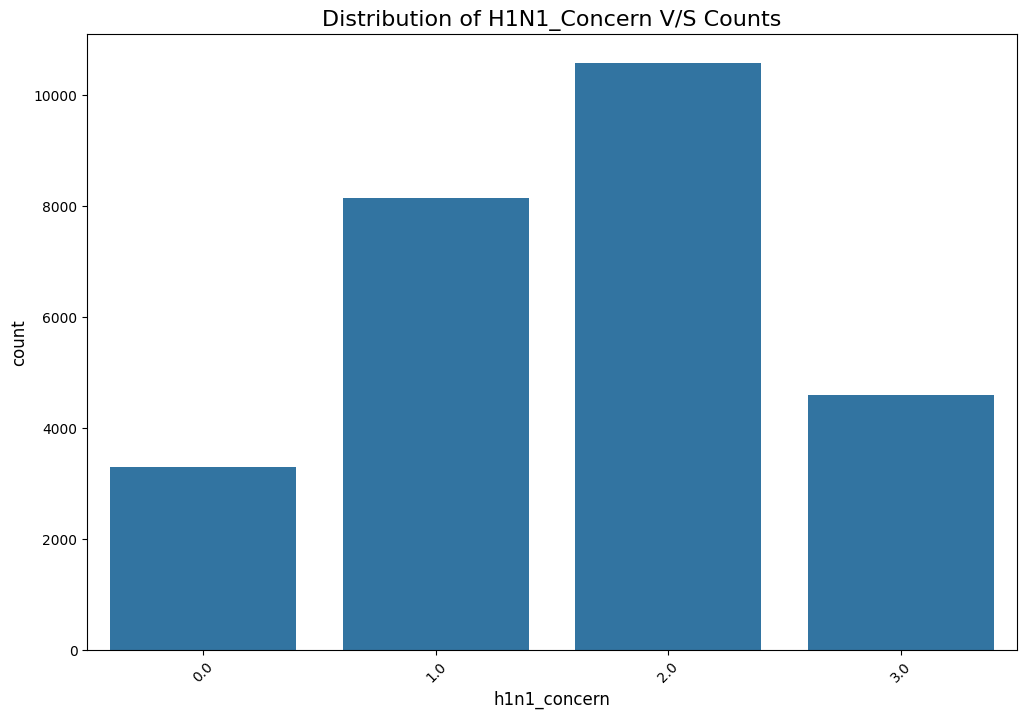

In [ ]:
plot_count(x='h1n1_concern',data=df,title=f"Distribution of H1N1_Concern",xlabel="h1n1_concern",ylabel="count")

### **Conclusion:**
**The graph shows that the majority of respondents have a moderate level of concern, with a smaller number having a high or low level of concern.**

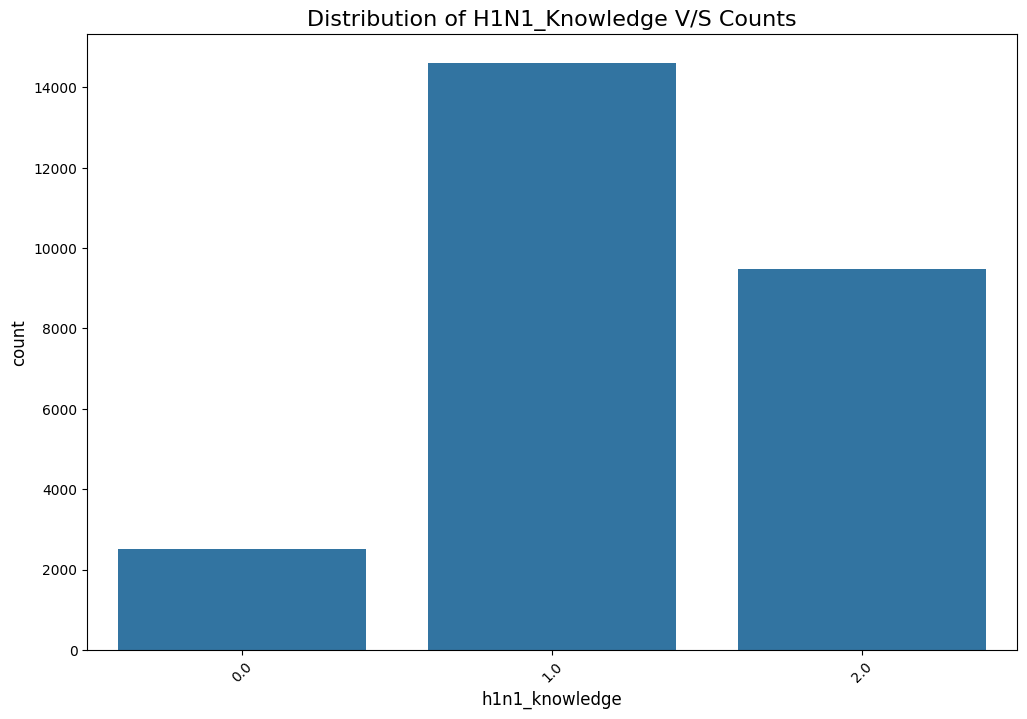

In [ ]:
plot_count(x='h1n1_knowledge',data=df,title=f"Distribution of H1N1_Knowledge",xlabel="h1n1_knowledge",ylabel="count")


**A small portion of people (represented by the bar at 0.0) have no knowledge about H1N1.
The largest group (represented by the bar at 1.0) has some level of knowledge about H1N1.
A significant portion (represented by the bar at 2.0) has high knowledge about H1N1.
This suggests that most people are at least somewhat informed about H1N1, with a notable portion having a high level of knowledge. However, there is still a minority with no awareness, indicating an area for potential educational outreach.**

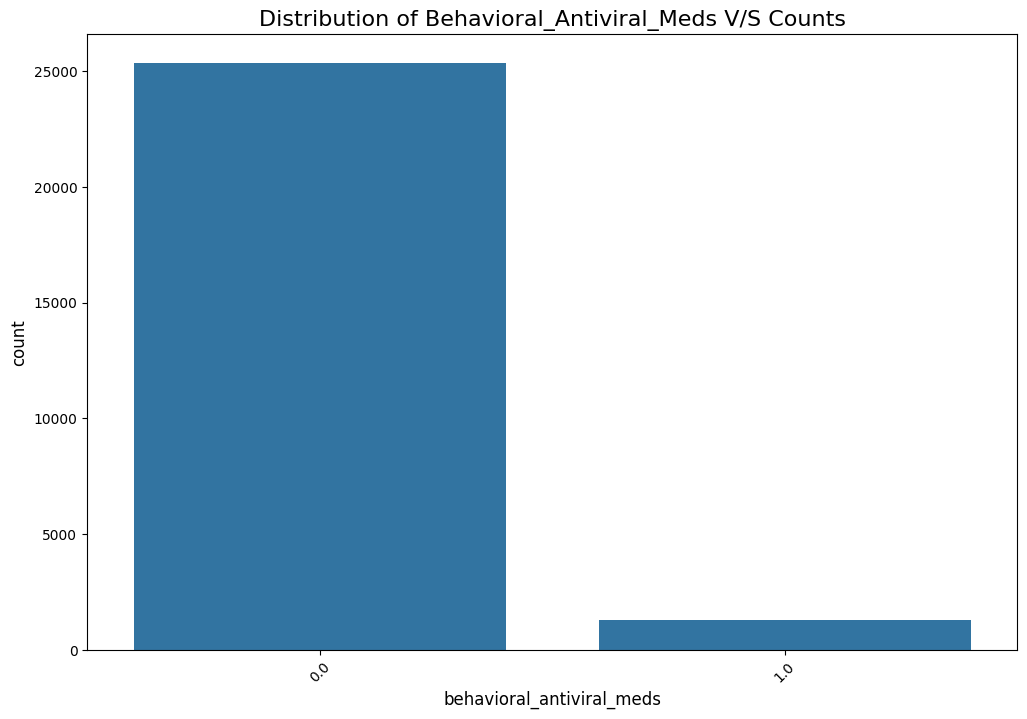

In [ ]:
plot_count(x='behavioral_antiviral_meds',data=df,title=f"Distribution of Behavioral_Antiviral_Meds",xlabel="behavioral_antiviral_meds",ylabel="count")

### **Conclusion:**
**The graph indicates that the majority of respondents (represented by the bar for 0.0) do not take antiviral medications, with only a small proportion (represented by the bar for 1.0) reporting that they do take antiviral medications. This suggests that antiviral medication usage is quite low among the surveyed population.**

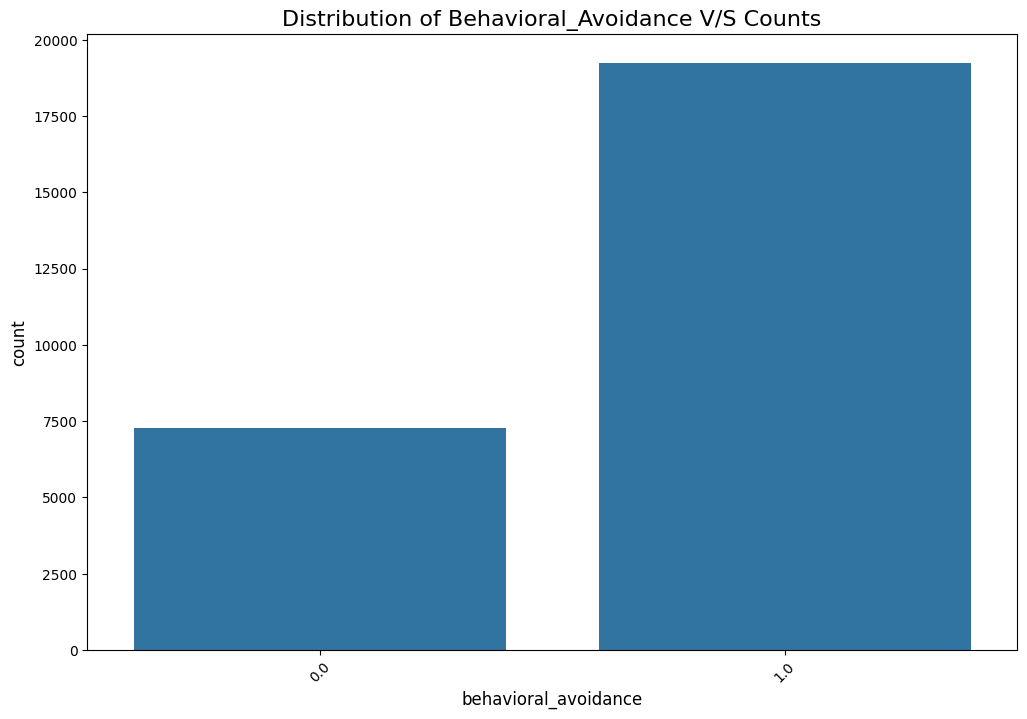

In [ ]:
plot_count(x='behavioral_avoidance',data=df,title=f"Distribution of Behavioral_Avoidance",xlabel="behavioral_avoidance",ylabel="count")

**A larger group of people (represented by 1.0) demonstrates behavioral avoidance, meaning they actively take measures to avoid certain situations or actions.
A smaller group (represented by 0.0) does not show behavioral avoidance.
This indicates that most individuals in the dataset practice avoidance behaviors, potentially as a response to health concerns or risks. However, a significant portion does not, suggesting varying attitudes or awareness toward avoidance practices.**

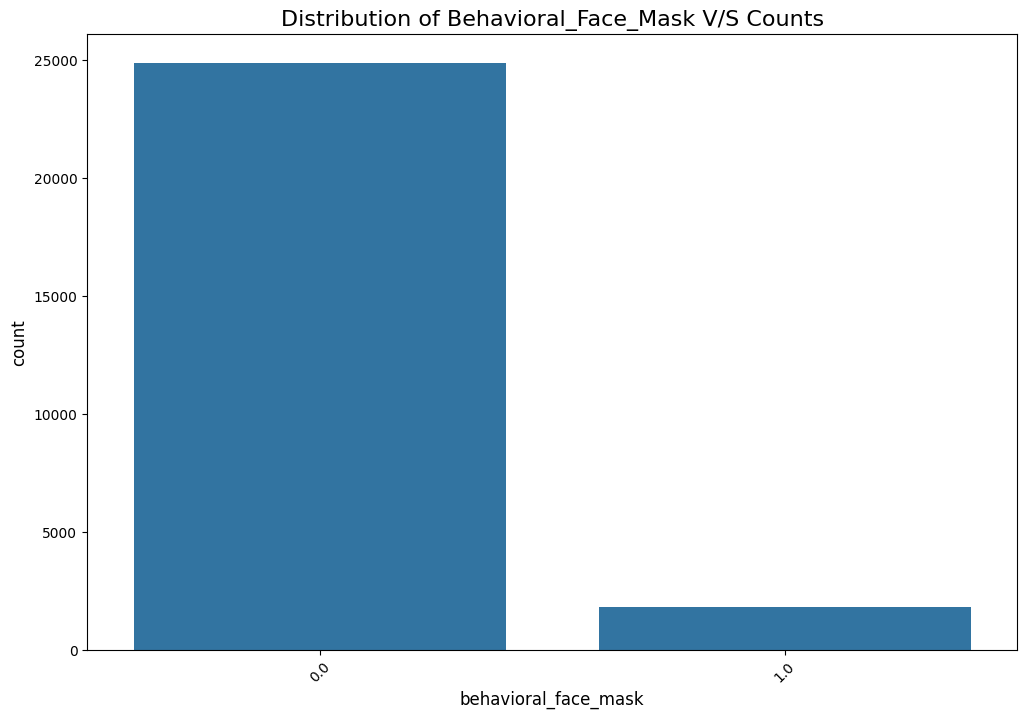

In [ ]:
plot_count(x='behavioral_face_mask',data=df,title=f"Distribution of Behavioral_Face_Mask",xlabel="behavioral_face_mask",ylabel="count")

**The data shows a substantial imbalance in the distribution, with the majority of individuals not engaging in the behavior represented by 1.0 where many people are not wearing face mask**

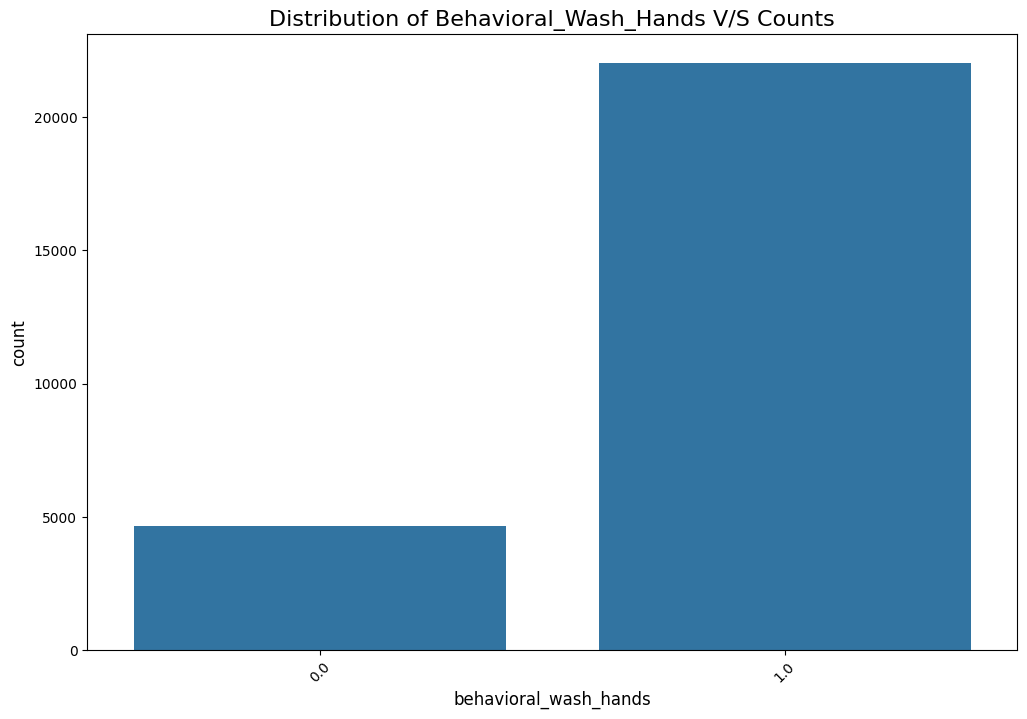

In [ ]:
plot_count(x='behavioral_wash_hands',data=df,title=f"Distribution of Behavioral_Wash_Hands",xlabel="behavioral_wash_hands",ylabel="count")

**The graph highlights that a large proportion of the population in the dataset adheres to the behavior of washing hands (1.0).**

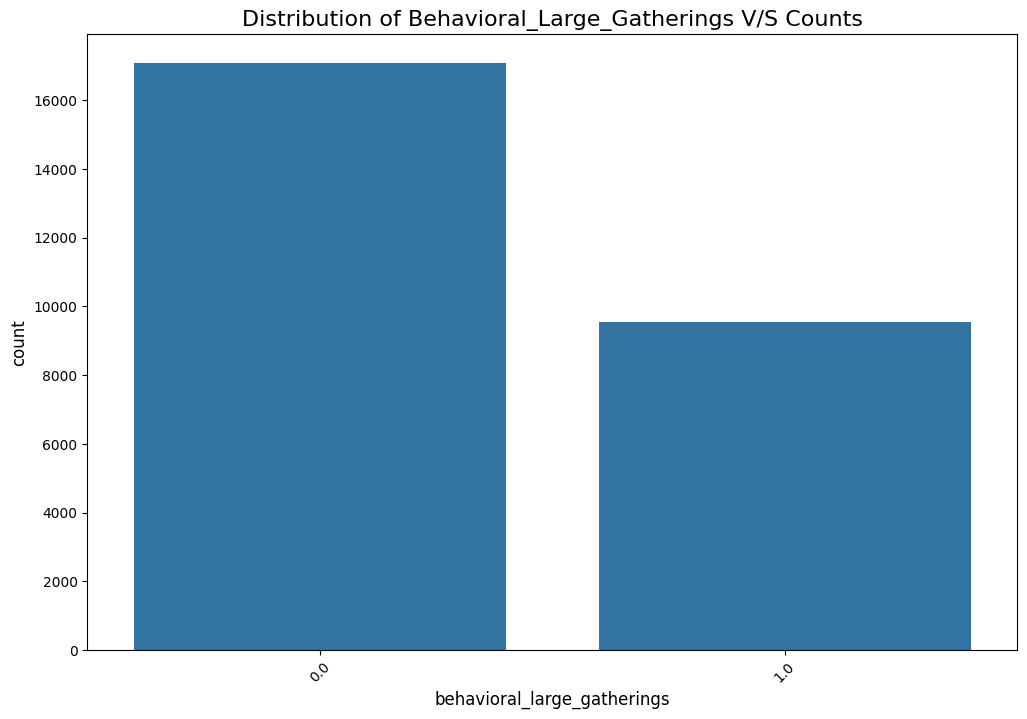

In [ ]:
plot_count(x='behavioral_large_gatherings',data=df,title=f"Distribution of Behavioral_Large_Gatherings",xlabel="behavioral_large_gatherings",ylabel="count")

**Category with 0.0: This category has a higher count, indicating that the majority of individuals in the dataset avoid large gatherings.
Category with 1.0: This category has a smaller count, representing individuals who participate in large gatherings.**

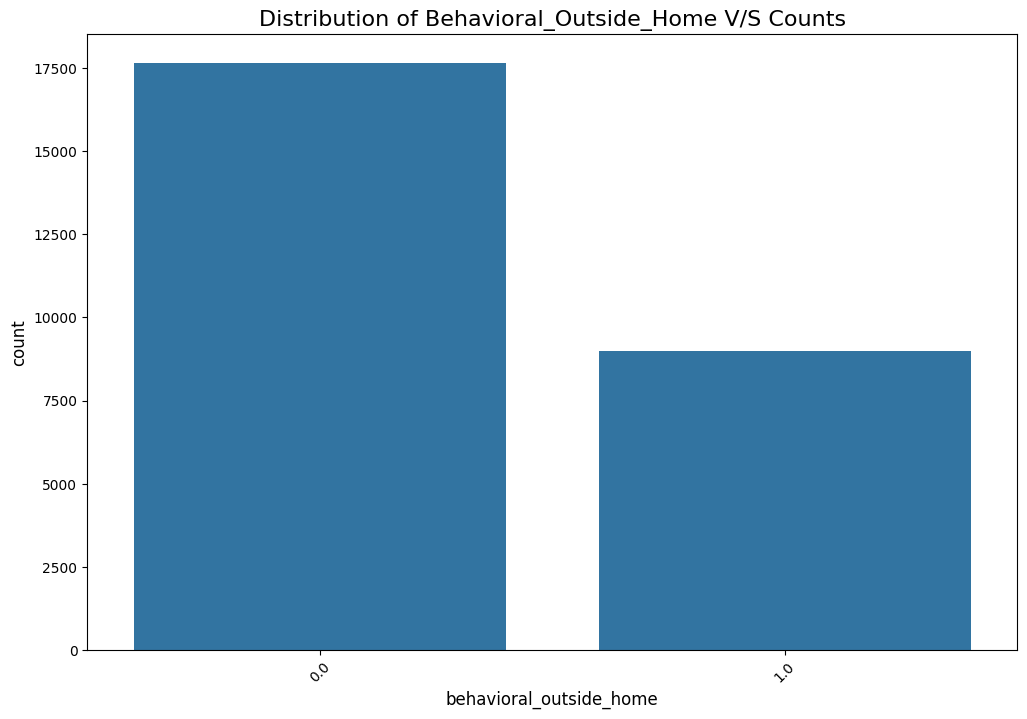

In [ ]:
plot_count(x='behavioral_outside_home',data=df,title=f"Distribution of Behavioral_Outside_Home",xlabel="behavioral_outside_home",ylabel="count")

**The value 0.0 has a significantly higher count compared to 1.0.
This suggests that the majority of individuals or instances in the dataset tend not to engage in the behavioral_outside_home activity.**

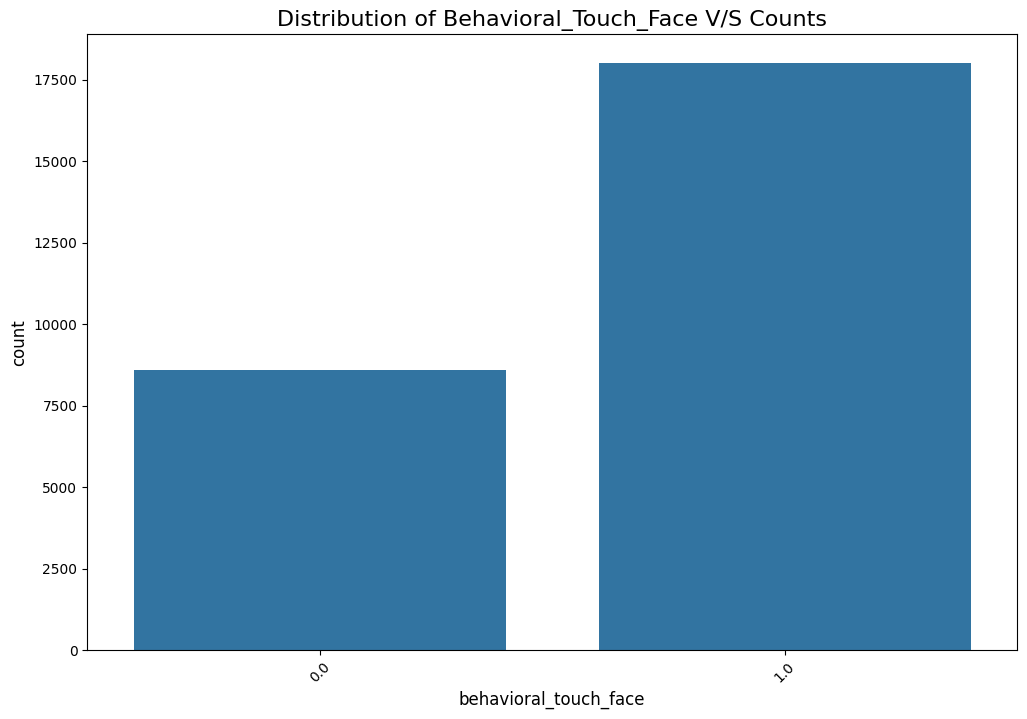

In [ ]:
plot_count(x='behavioral_touch_face',data=df,title=f"Distribution of Behavioral_Touch_Face",xlabel="behavioral_touch_face",ylabel="count")

**The value 1.0 has a significantly higher count compared to 0.0.
This indicates that the majority of individuals or instances in the dataset exhibit the behavior of touching their face.**

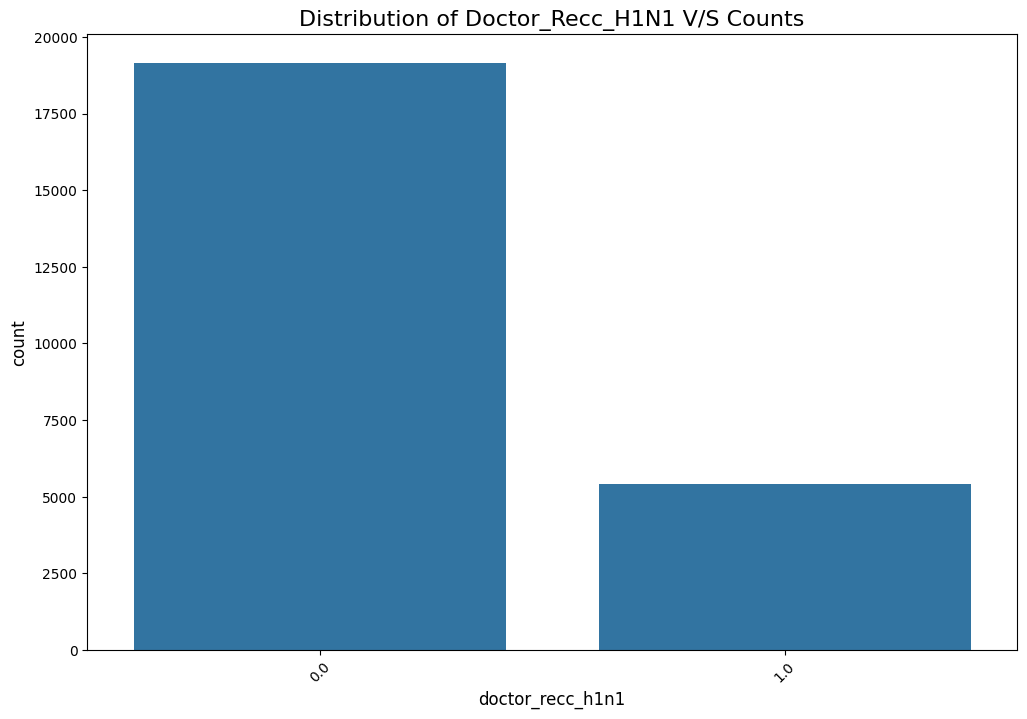

In [ ]:
plot_count(x='doctor_recc_h1n1',data=df,title=f"Distribution of Doctor_Recc_H1N1",xlabel="doctor_recc_h1n1",ylabel="count")

 **The value 0.0 has a significantly higher count compared to 1.0.
This indicates that the majority of individuals or cases in the dataset did not receive or follow a doctor's recommendation regarding the H1N1 vaccine.**

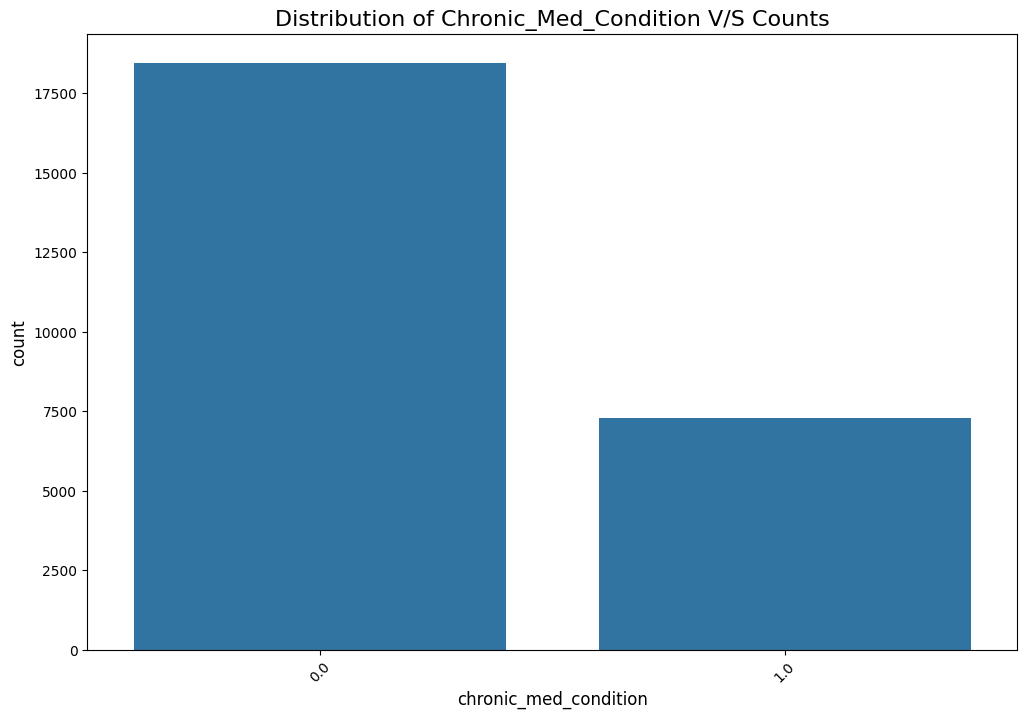

In [ ]:
plot_count(x='chronic_med_condition',data=df,title=f"Distribution of Chronic_Med_Condition",xlabel="chronic_med_condition",ylabel="count")

 **Category 0.0 (No chronic medical condition): This category has the highest count, indicating that the majority of the population analyzed does not have a chronic medical condition.
Category 1.0 (Chronic medical condition present): This category has a lower count compared to 0.0, indicating that fewer individuals in the dataset have a chronic medical condition.**

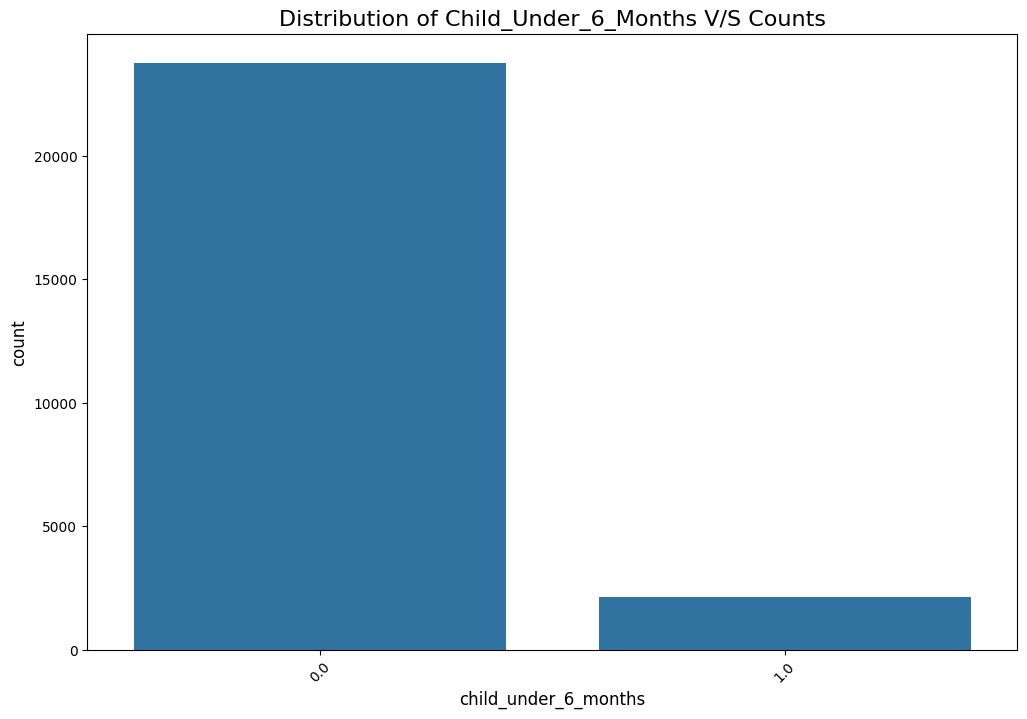

In [ ]:
plot_count(x='child_under_6_months',data=df,title=f"Distribution of Child_Under_6_Months",xlabel="child_under_6_months",ylabel="count")

**Category 0.0 (No child under 6 months): This category has the largest count, indicating that most of the population does not have a child under 6 months old.
Category 1.0 (Child under 6 months present): This category has a significantly lower count, suggesting that a smaller proportion of the dataset includes individuals with a child under 6 months.**

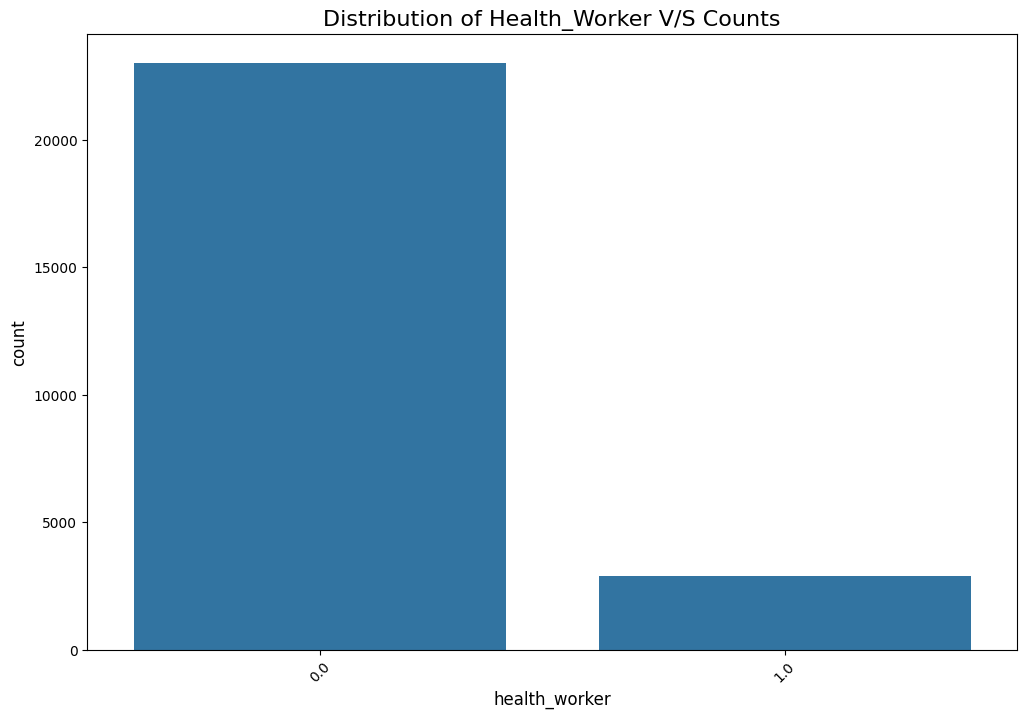

In [ ]:
plot_count(x='health_worker',data=df,title=f"Distribution of Health_Worker",xlabel="health_worker",ylabel="count")

**Category 0.0 (Not a health worker): The majority of individuals in the dataset fall into this category, indicating that most are not health workers.
Category 1.0 (Health worker): This category has a significantly smaller count, showing that a relatively small proportion of the population are health workers.**

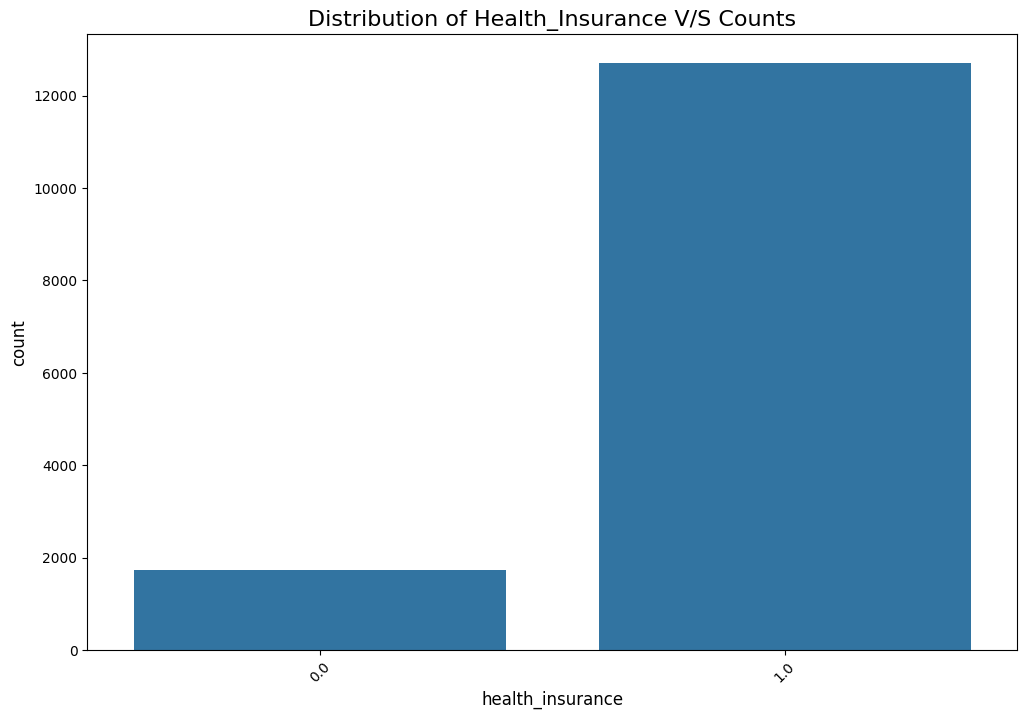

In [ ]:
plot_count(x='health_insurance',data=df,title=f"Distribution of Health_Insurance",xlabel="health_insurance",ylabel="count")

**0.0 (No Health Insurance): Representing a smaller count (around 2000).
1.0 (Has Health Insurance): Representing a significantly larger count (around 12000).
A much higher proportion of individuals have health insurance (1.0) compared to those without it (0.0). This suggests a disparity in health insurance coverage, where most people are insured, but a minority remains uninsured.**

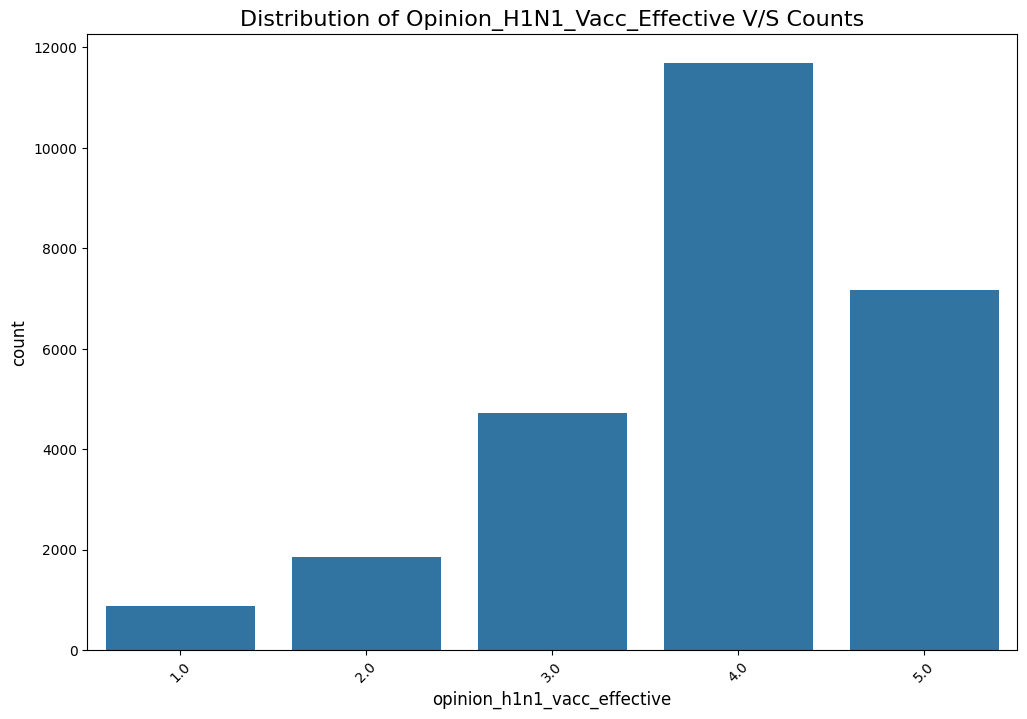

In [ ]:
plot_count(x='opinion_h1n1_vacc_effective',data=df,title=f"Distribution of Opinion_H1N1_Vacc_Effective",xlabel="opinion_h1n1_vacc_effective",ylabel="count")

**The lowest count is for 1.0 (least effective), indicating that very few people strongly believe the vaccine is ineffective.
The count increases for values 3.0 and peaks at 4.0, showing a majority of respondents think the vaccine is effective or moderately effective.
There is a slight decrease at 5.0, but it still represents a significant proportion of responses, indicating strong confidence in the vaccine's effectiveness.
Most respondents perceive the H1N1 vaccine as effective, with the highest agreement on the effectiveness level at 4.0. Few people strongly doubt its effectiveness, suggesting a generally positive perception of the vaccine.**

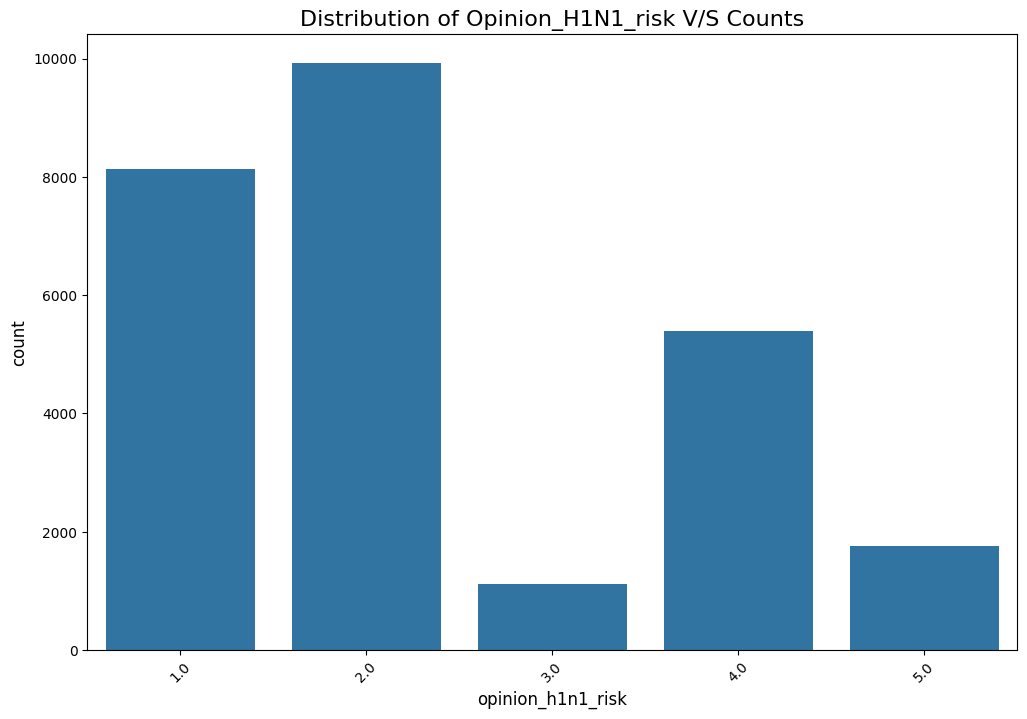

In [ ]:
plot_count(x='opinion_h1n1_risk',data=df,title=f"Distribution of Opinion_H1N1_risk",xlabel="opinion_h1n1_risk",ylabel="count")

 **1.0 and 2.0 (Low Risk): These categories have the highest counts, indicating that most respondents perceive the risk of H1N1 as low.
3.0 (Neutral): Very few respondents selected this category, showing a relatively small neutral stance toward the risk.
4.0 and 5.0 (High Risk): These categories have lower counts compared to the low-risk opinions, with 4.0 being more common than 5.0.
The majority of respondents believe the risk of H1N1 is relatively low (1.0 and 2.0). Only a minority perceive the risk as high (4.0 and 5.0). This suggests that the general perception of H1N1 risk might not be considered severe by most people.**

---



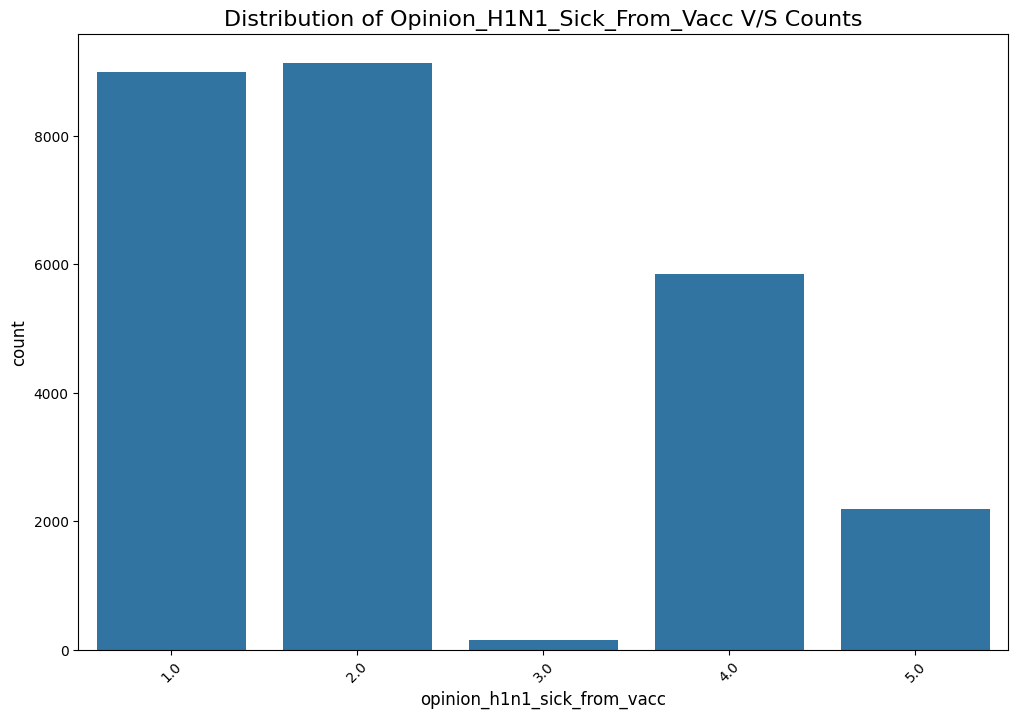

In [ ]:
plot_count(x='opinion_h1n1_sick_from_vacc',data=df,title=f"Distribution of Opinion_H1N1_Sick_From_Vacc",xlabel="opinion_h1n1_sick_from_vacc",ylabel="count")

**1.The most frequent opinions are represented by values 1.0 and 2.0, indicating a significant number of respondents who may strongly agree or agree that the H1N1 vaccine could make people sick.**

**2. Value 4.0 is also notably high, representing respondents who might disagree with the statement.**

**3. The count for the value 3.0 (neutral opinion) is extremely low, indicating that very few respondents were undecided or neutral about this issue.**

**4. The value 5.0, which likely represents a strong disagreement, is less frequent compared to other categories.**

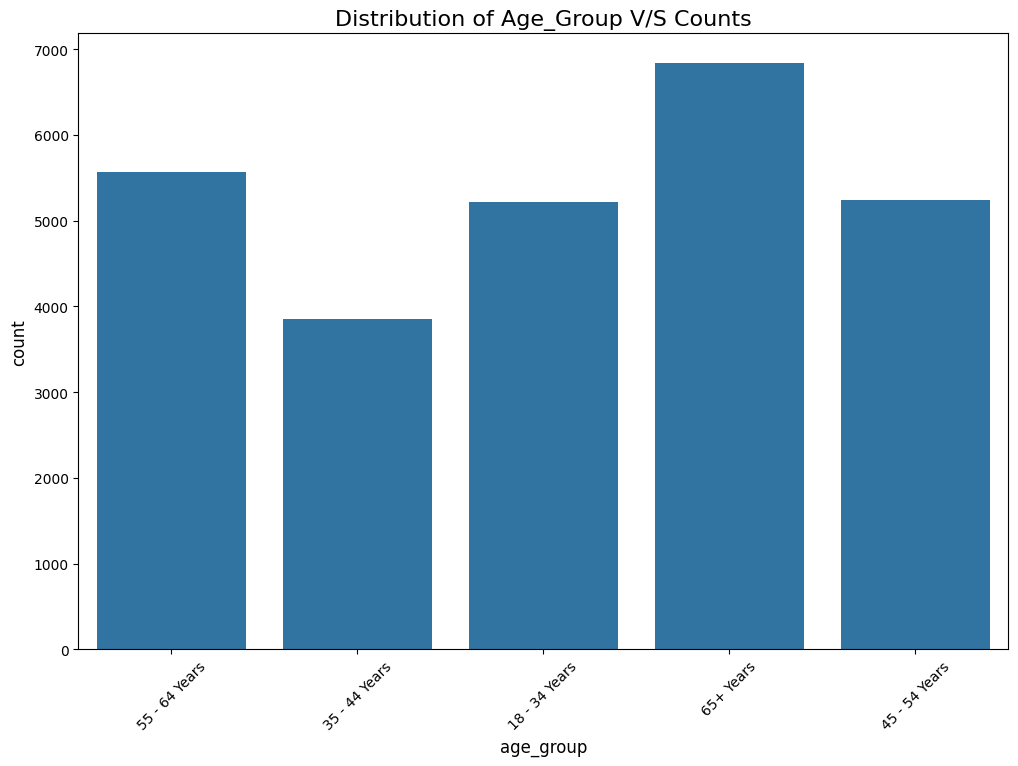

In [ ]:
plot_count(x='age_group',data=df,title=f"Distribution of Age_Group",xlabel="age_group",ylabel="count")

**1. The age group 65+ years has the highest count, indicating that this group forms the largest segment of the population in the dataset.**

**2. The age groups 55–64 years and 45–54 years have relatively high counts, making them the second and third most represented age categories.**

**3. The age groups 35–44 years and 18–34 years have the lowest counts, suggesting these age ranges are underrepresented compared to older populations.**

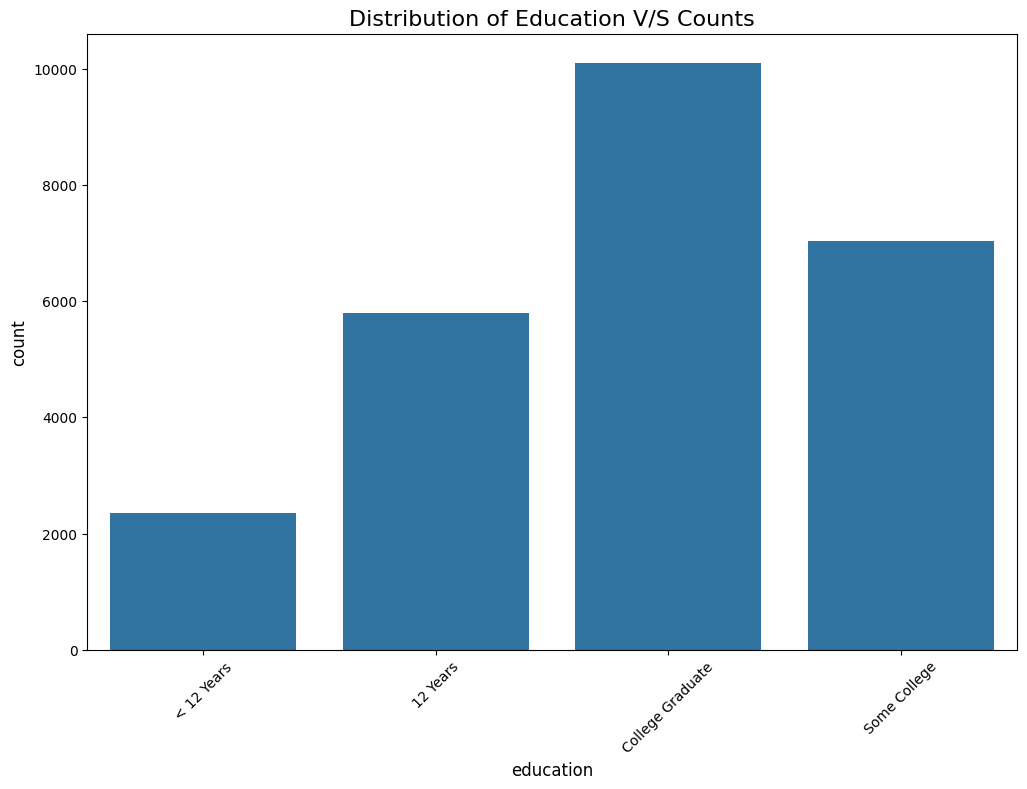

In [ ]:
plot_count(x='education',data=df,title=f"Distribution of Education",xlabel="education",ylabel="count")

**The dataset is skewed toward higher education levels, with the majority of individuals being college graduates. This distribution could indicate a focus on a more educated population, potentially affecting the analysis or conclusions drawn from this data.**

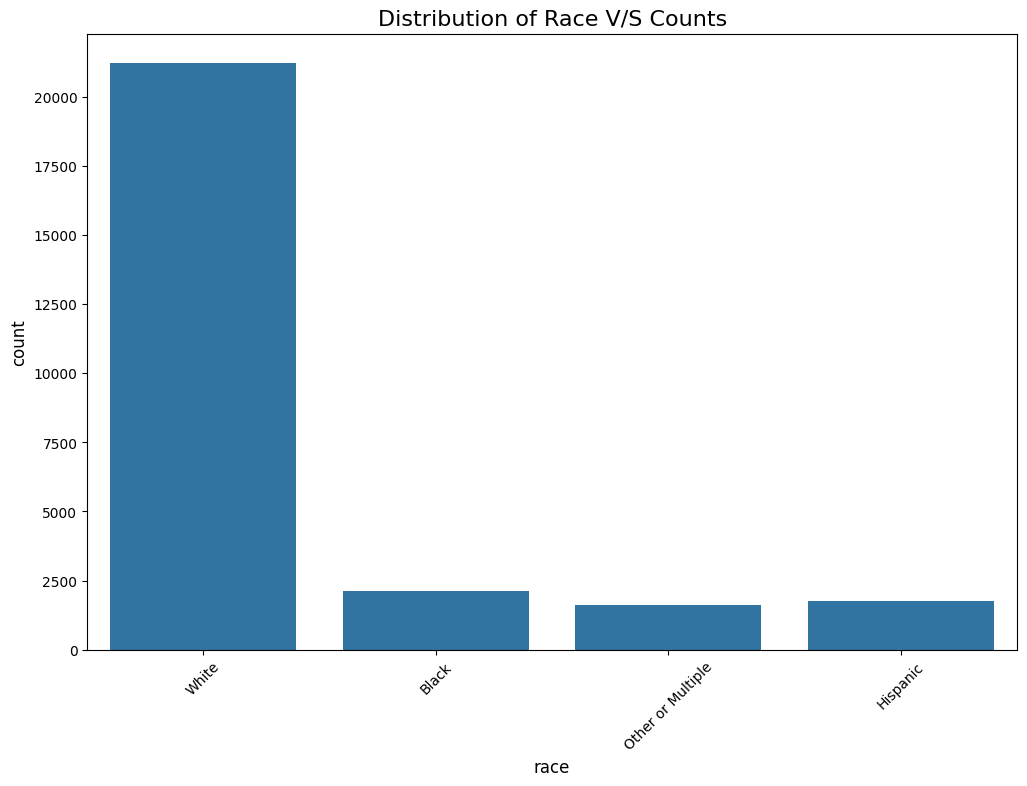

In [ ]:
plot_count(x='race',data=df,title=f"Distribution of Race",xlabel="race",ylabel="count")

**There is a notable imbalance in the representation across racial categories, with "White" being dominant in the dataset.**

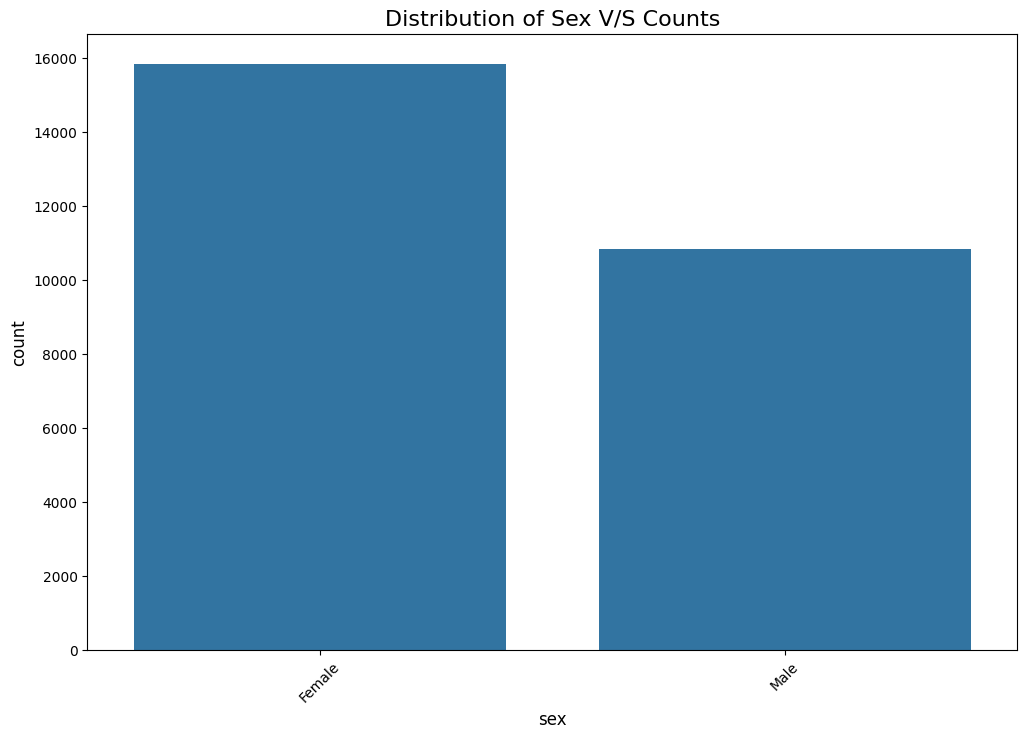

In [ ]:
plot_count(x='sex',data=df,title=f"Distribution of Sex",xlabel="sex",ylabel="count")

**The count of females is higher than that of males in the dataset.**

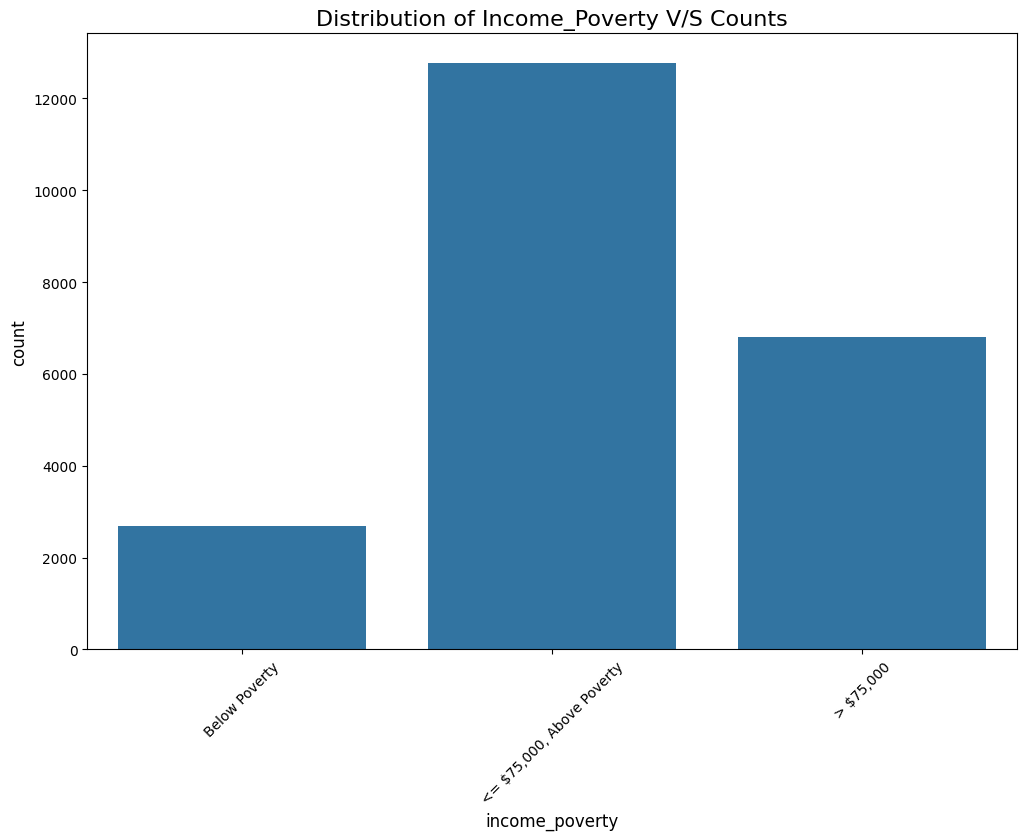

In [ ]:
plot_count(x='income_poverty',data=df,title=f"Distribution of Income_Poverty",xlabel="income_poverty",ylabel="count")

**1. The majority of individuals fall into the income category of "$75,000 or less but above poverty", indicating that this group forms the largest segment in the dataset.**

**2. The second-largest group is those earning "above $75,000", suggesting a significant portion of individuals belong to a higher income bracket.**

**3. The group "below poverty" has the smallest count, showing that relatively fewer individuals fall into this category compared to the other income levels.**

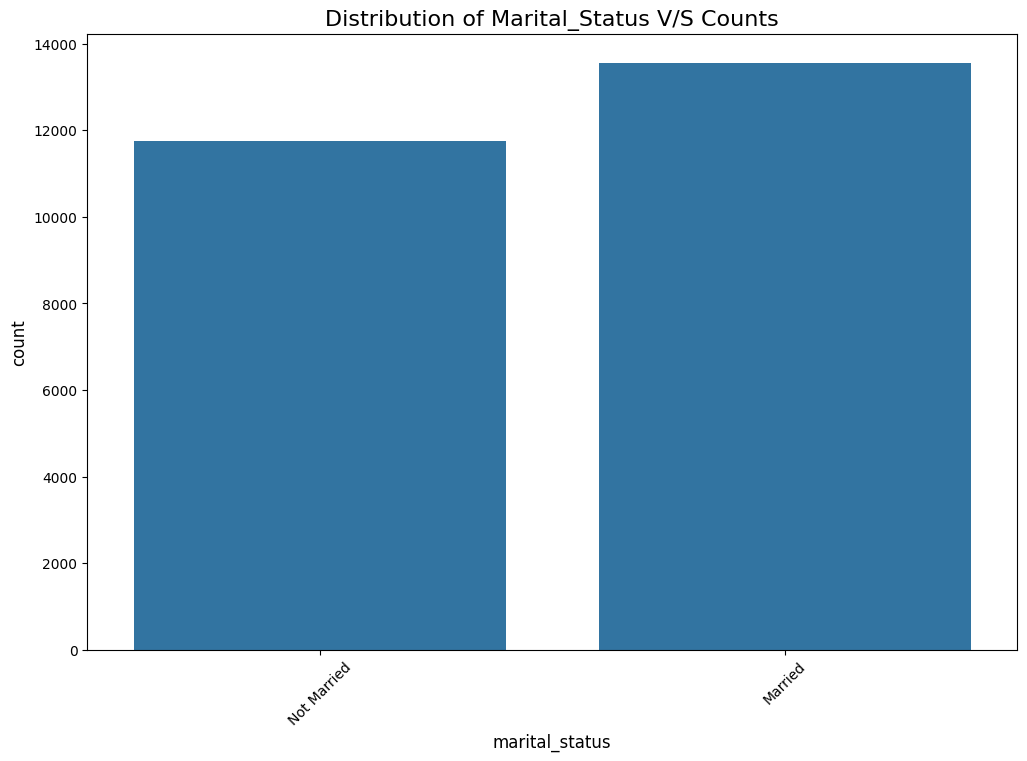

In [ ]:
plot_count(x='marital_status',data=df,title=f"Distribution of Marital_Status",xlabel="marital_status",ylabel="count")

**The count of married individuals is slightly higher than those who are not married.**

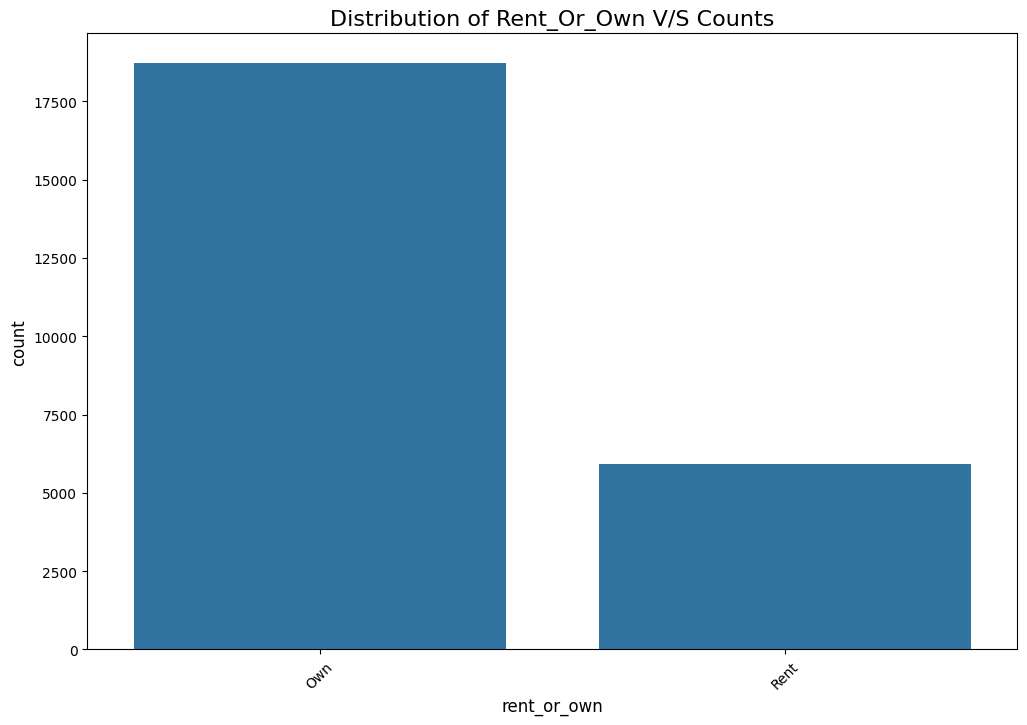

In [ ]:
plot_count(x='rent_or_own',data=df,title=f"Distribution of Rent_Or_Own",xlabel="rent_or_own",ylabel="count")

**A significantly larger proportion of people own their living space compared to those who rent.**

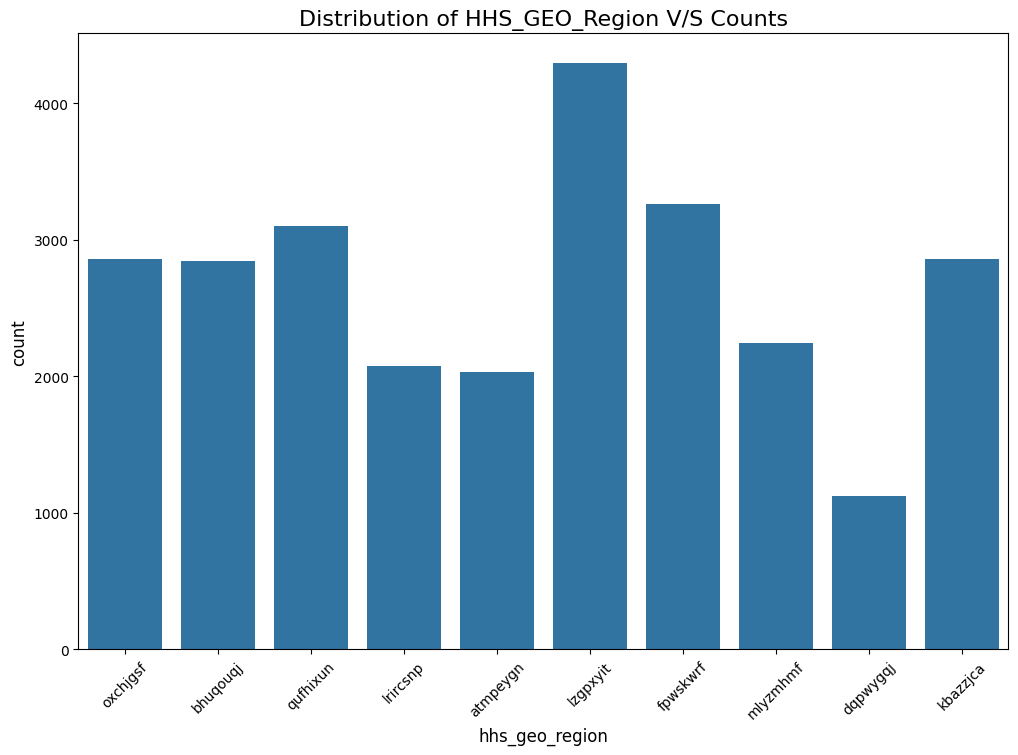

In [ ]:
plot_count(x='hhs_geo_region',data=df,title=f"Distribution of HHS_GEO_Region",xlabel="hhs_geo_region",ylabel="count")

**1. The region labeled "lzqpykit" has the highest count, indicating it is the most represented region.**

**2. Regions such as "dqpiwgdj" have significantly lower counts, suggesting they are less represented.**

**3. Other regions, such as "oxrhjgsf", "bhuoqwij", and "kbaizfca", have moderate representation, falling between the extremes.**

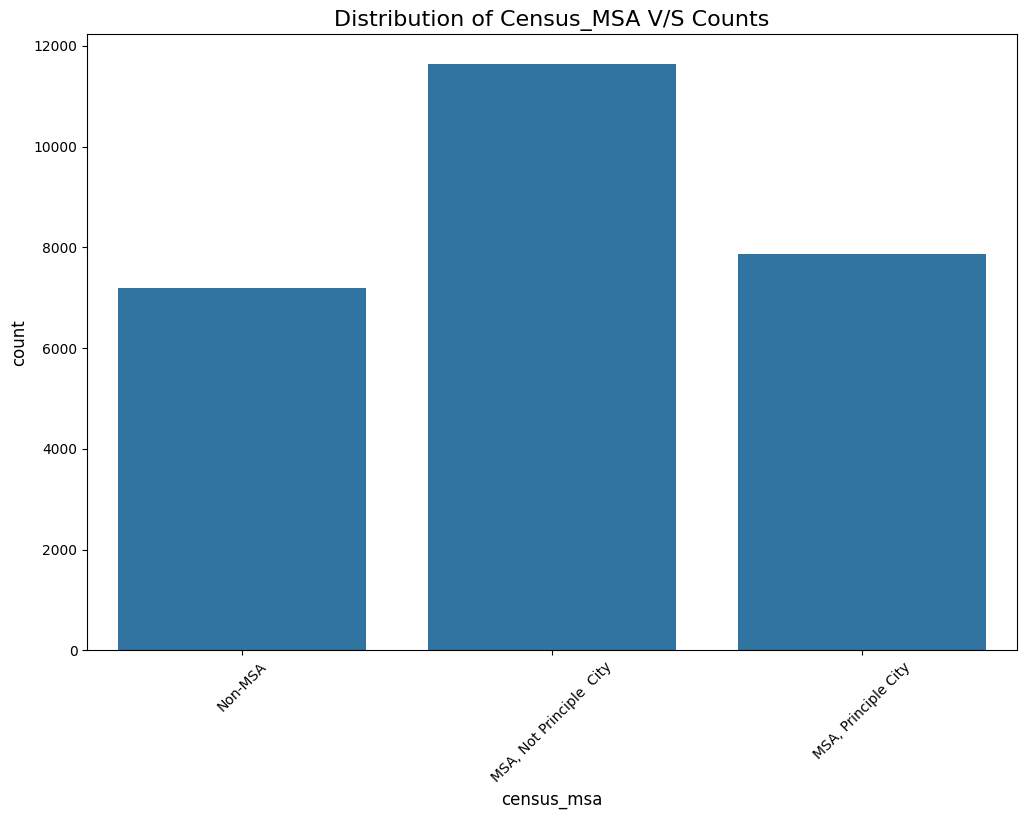

In [ ]:
plot_count(x='census_msa',data=df,title=f"Distribution of Census_MSA",xlabel="census_msa",ylabel="count")

**1. The category "MSA, Not Principle City" has the highest count, indicating it is the most represented category.**

**2. Both "Non-MSA" and "MSA, Principle City" have lower and relatively similar counts compared to the "Not Principle City" category.**

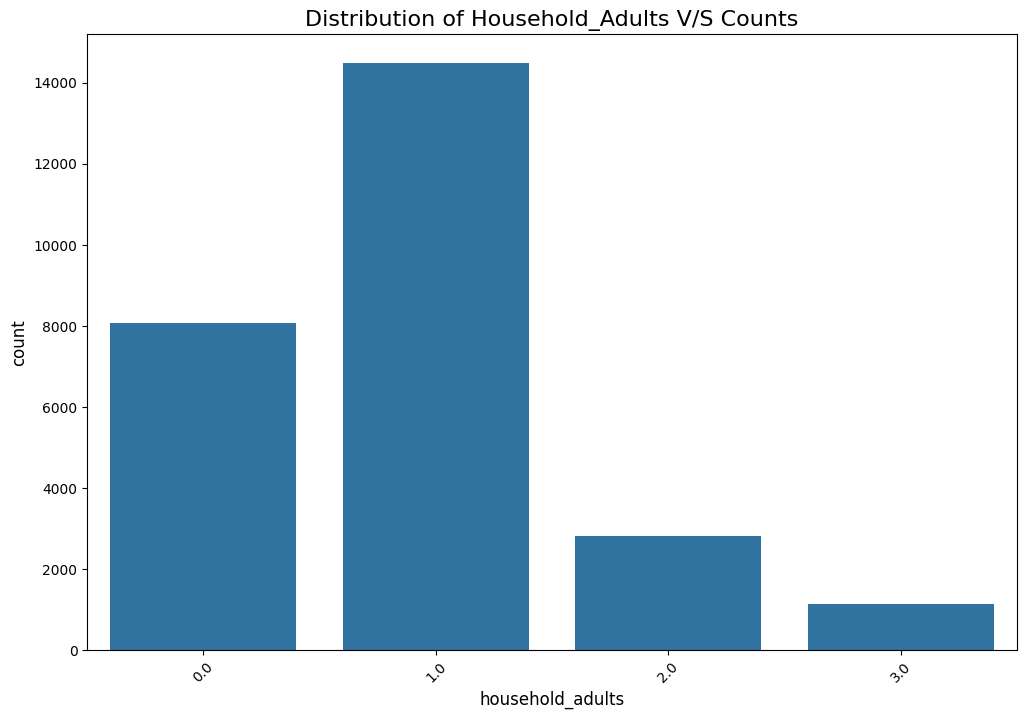

In [ ]:
plot_count(x='household_adults',data=df,title=f"Distribution of Household_Adults",xlabel="household_adults",ylabel="count")

**The most frequent number of adults in households is 1, with the highest count.**

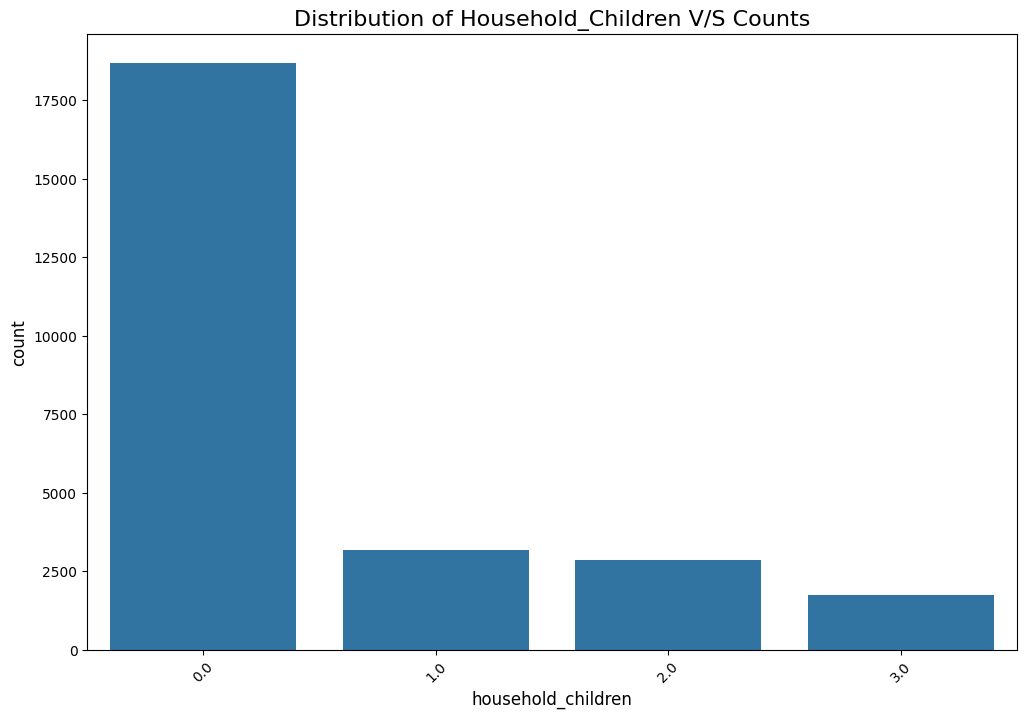

In [ ]:
plot_count(x='household_children',data=df,title=f"Distribution of Household_Children",xlabel="household_children",ylabel="count")

**This distribution highlights a trend where child-free households dominate, and the number of households decreases as the number of children increases.**

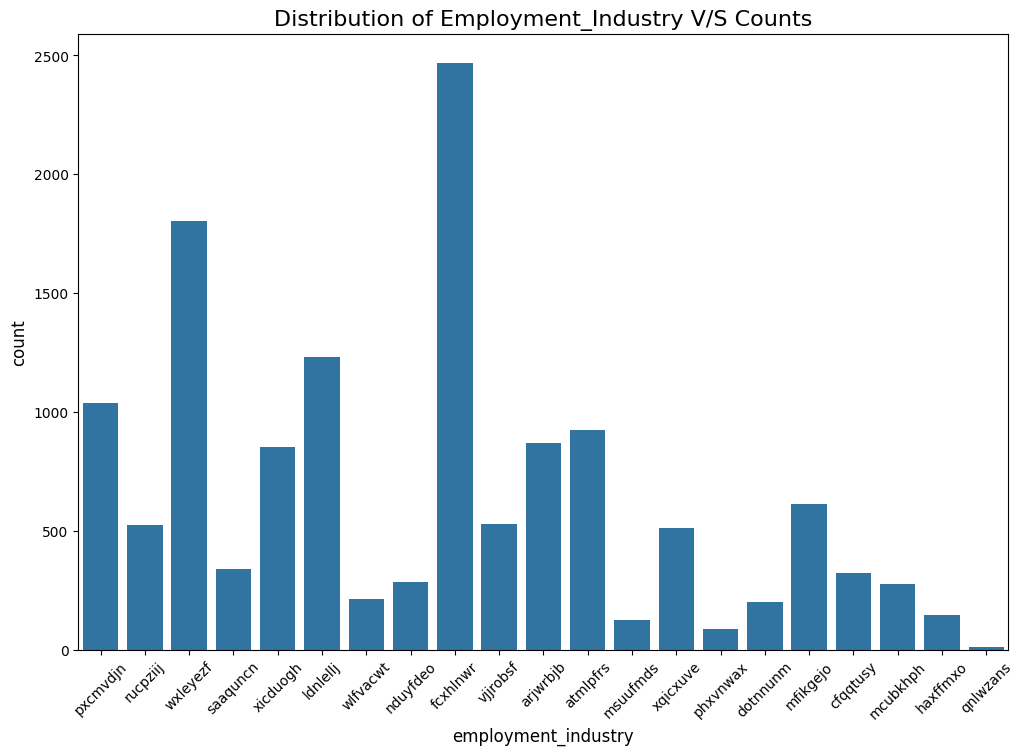

In [ ]:
plot_count(x='employment_industry',data=df,title=f"Distribution of Employment_Industry",xlabel="employment_industry",ylabel="count")

**This distribution indicates a concentration of employment in specific industries, with several industries having comparatively lower representation**

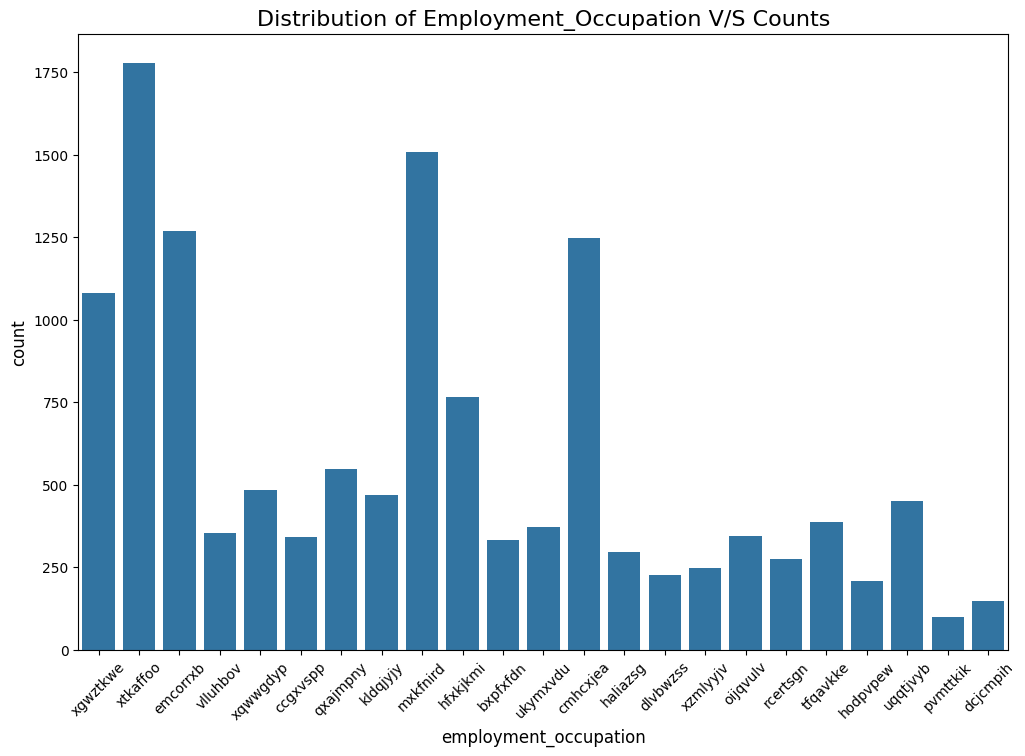

In [ ]:
plot_count(x='employment_occupation',data=df,title=f"Distribution of Employment_Occupation",xlabel="employment_occupation",ylabel="count")

**1. Certain categories (e.g., "xklzfoo" and "mxkfmid") have significantly higher counts, indicating they are the most common occupations in the dataset.**

**2. Some categories (e.g., "decfmplh" and "pmrttkxk") have the lowest counts, indicating they are rare.**

**3. There is a noticeable variation in the frequency of different occupations, suggesting unequal representation across the dataset.**

**4. The chart seems to exhibit a skewed distribution, with a few occupations dominating the counts while others are sparsely represented.**

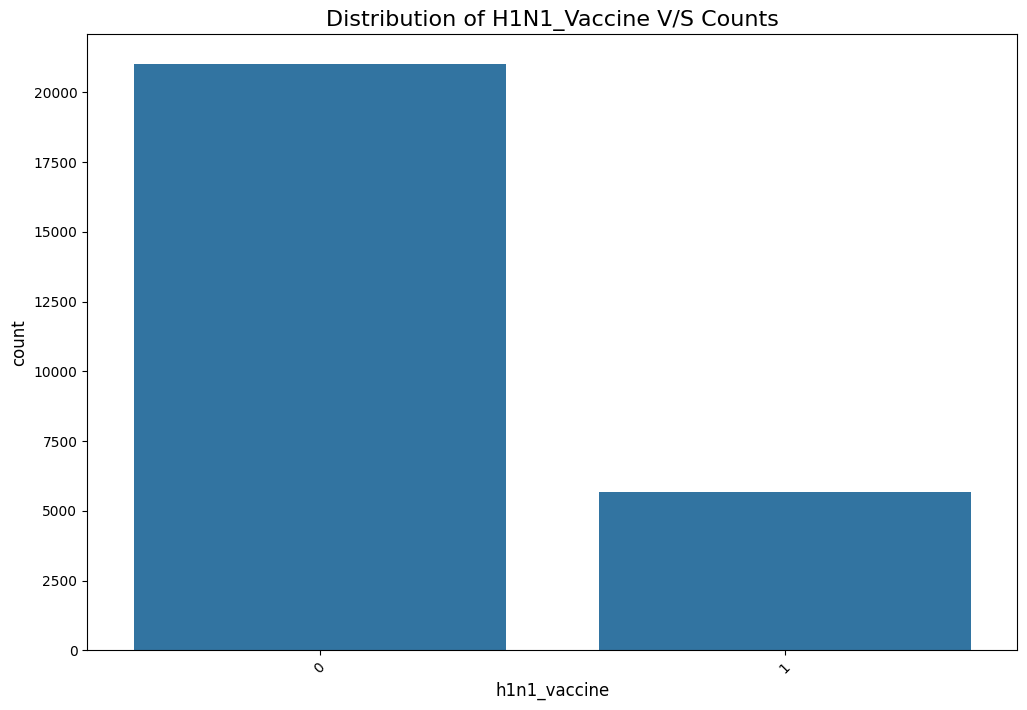

In [ ]:
plot_count(x='h1n1_vaccine',data=df,title=f"Distribution of H1N1_Vaccine",xlabel="h1n1_vaccine",ylabel="count")

**1. The majority of the individuals in the dataset (represented by the count labeled "0") did not take the H1N1 vaccine.**

**2. Smaller Group Received the Vaccine: A significantly smaller group (labeled "1") received the vaccine, indicating low uptake.**

### **Conclusion For Uni-Variate Analysis :**

**Most people in the dataset are moderately concerned about H1N1, know a bit about it, and follow some preventive habits like handwashing, but few take the vaccine or antiviral medication. Older, educated, and higher-income individuals, as well as women, are more represented in the data. Many avoid gatherings, but fewer wear masks, showing mixed health practices. These results suggest the need for better education and outreach to improve awareness, vaccine confidence, and health behavior.**

In [ ]:
df.columns

Index(['respondent_id', 'h1n1_concern', 'h1n1_knowledge',
       'behavioral_antiviral_meds', 'behavioral_avoidance',
       'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'child_under_6_months', 'health_worker',
       'health_insurance', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
       'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'age_group',
       'education', 'race', 'sex', 'income_poverty', 'marital_status',
       'rent_or_own', 'employment_status', 'hhs_geo_region', 'census_msa',
       'household_adults', 'household_children', 'employment_industry',
       'employment_occupation', 'h1n1_vaccine', 'seasonal_vaccine'],
      dtype='object')

### **BI-Variate Analysis For H1N1 Vaccine**

In [48]:
# Dropping columns related Seasonal vaccination as we are analyzing for H1N1 Vaccine

df_h1n1=df.drop(columns=['opinion_seas_vacc_effective','opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'seasonal_vaccine','doctor_recc_seasonal' ])

In [49]:
df_h1n1.columns

Index(['respondent_id', 'h1n1_concern', 'h1n1_knowledge',
       'behavioral_antiviral_meds', 'behavioral_avoidance',
       'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'chronic_med_condition',
       'child_under_6_months', 'health_worker', 'health_insurance',
       'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'opinion_h1n1_sick_from_vacc', 'age_group', 'education', 'race', 'sex',
       'income_poverty', 'marital_status', 'rent_or_own', 'employment_status',
       'hhs_geo_region', 'census_msa', 'household_adults',
       'household_children', 'employment_industry', 'employment_occupation',
       'h1n1_vaccine'],
      dtype='object')

In [50]:
def plot_count(x, data, y='h1n1_vaccine', ylabel='H1N1 Vaccination'):
    title = f"H1N1 Vaccination VS {x.upper()}"  # Define the title inside the function
    xlabel = f"{x.upper()}"
    plt.figure(figsize=(12, 8))
    sns.countplot(x=x, data=data, hue=y)
    plt.title(title, fontsize=16)
    plt.xlabel(x.upper(), fontsize=12)
    plt.xticks(rotation=45)
    plt.ylabel(ylabel, fontsize=12)
    plt.show()


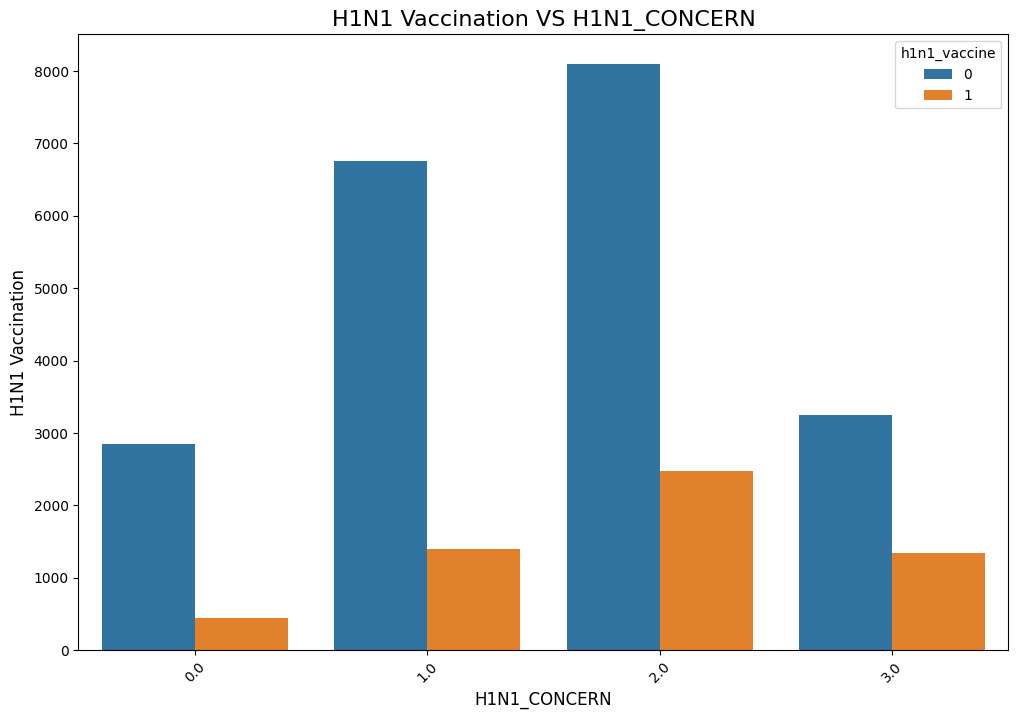

In [ ]:
plot_count(x='h1n1_concern', data=df_h1n1)

**This suggests that individuals with moderate to high concern are more likely to get vaccinated, but overall vaccine uptake remains low.**

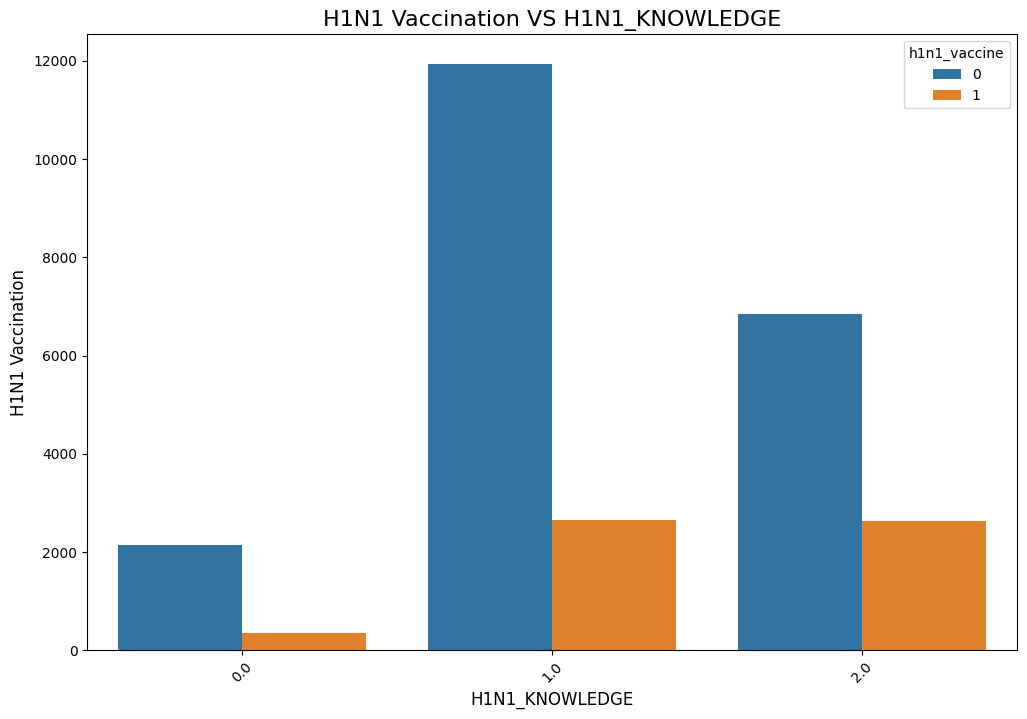

In [ ]:
plot_count(x='h1n1_knowledge', data=df_h1n1)

**Individuals with higher H1N1 knowledge (levels 1.0 and 2.0) are more likely to have taken the H1N1 vaccine**

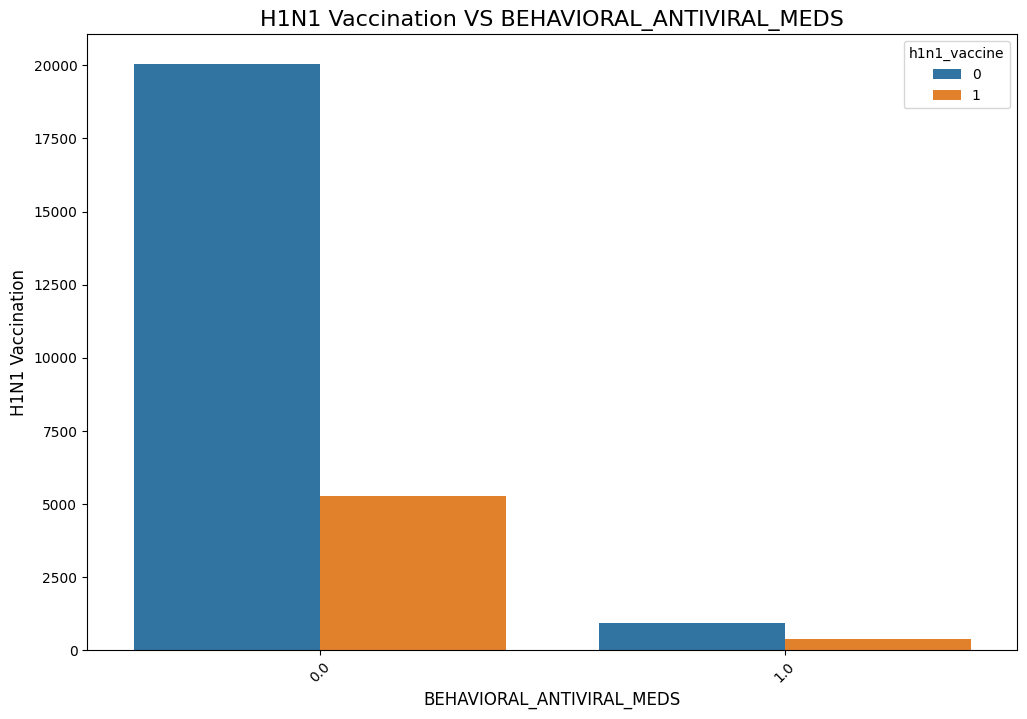

In [ ]:
plot_count(x='behavioral_antiviral_meds', data=df_h1n1)

**most individuals do not use antiviral medications (BEHAVIORAL_ANTIVIRAL_MEDS = 0.0), with far more unvaccinated than vaccinated. Among those likely to use antivirals (1.0), both vaccination and non-vaccination rates are very low. There is no strong link between antiviral use and H1N1 vaccination.**

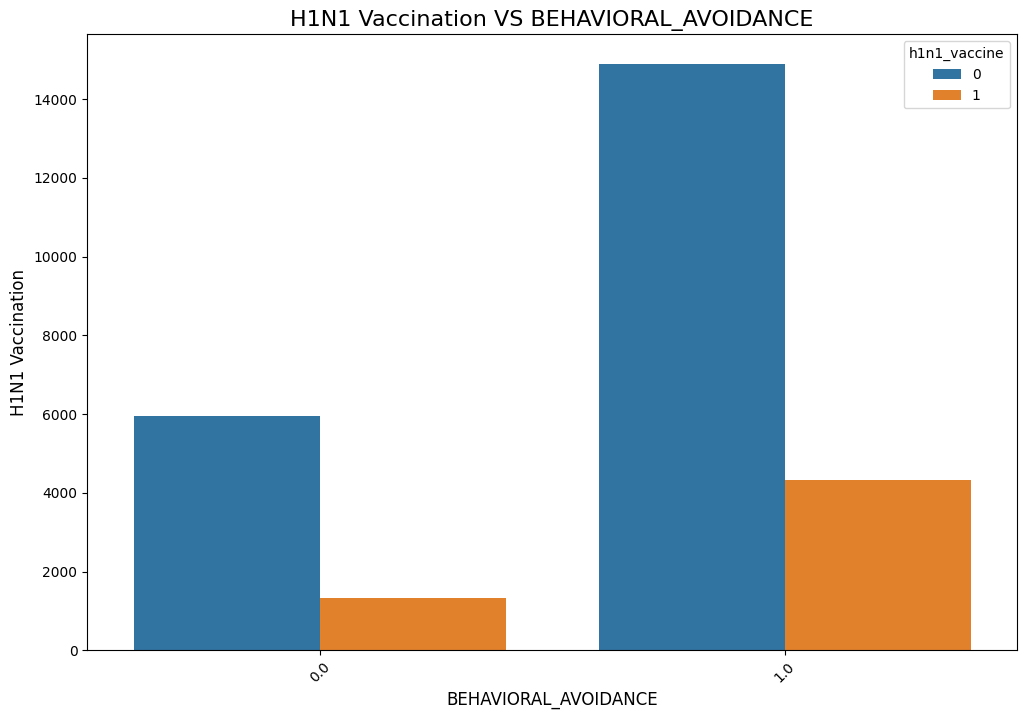

In [ ]:
plot_count(x='behavioral_avoidance', data=df_h1n1)

**People practicing avoidance behaviors (BEHAVIORAL_AVOIDANCE = 1.0) are slightly more likely to get vaccinated, but most remain unvaccinated regardless of avoidance behavior**

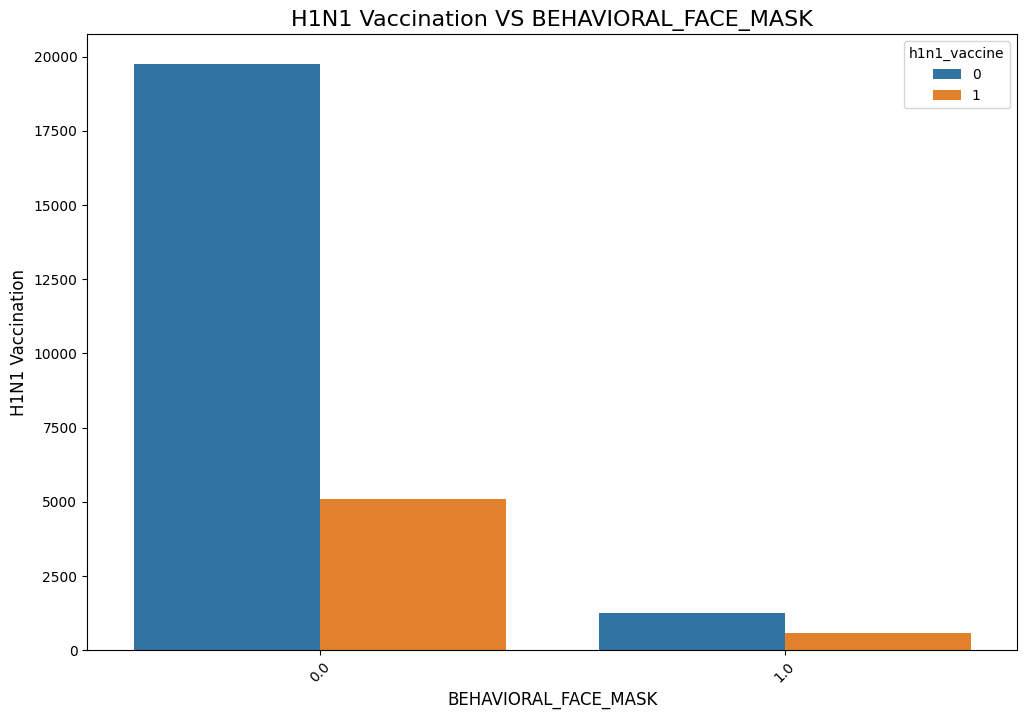

In [ ]:
plot_count(x='behavioral_face_mask', data=df_h1n1)

**The chart shows that most individuals, regardless of face mask usage, were not vaccinated for H1N1. However, those who wore face masks were slightly more likely to be vaccinated compared to those who did not. Overall, vaccination uptake remained low.**

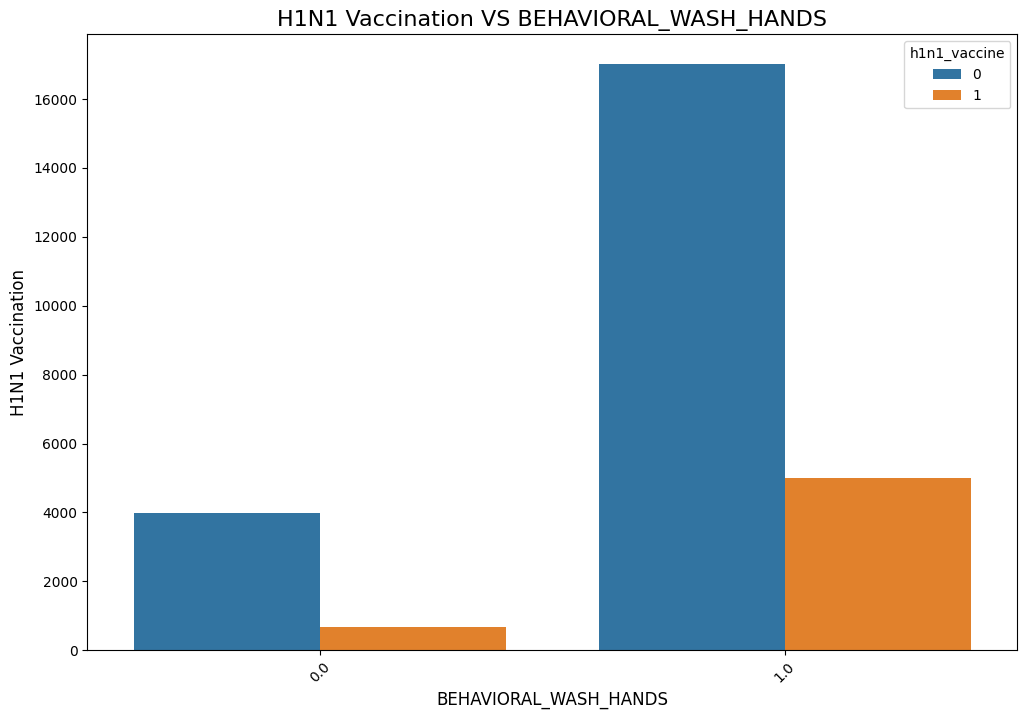

In [ ]:
plot_count(x='behavioral_wash_hands', data=df_h1n1)

**Frequent handwashing is associated with a higher likelihood of H1N1 vaccination, though the majority of individuals—regardless of handwashing behavior—were not vaccinated. This suggests some connection between health-conscious behaviors and vaccination.**

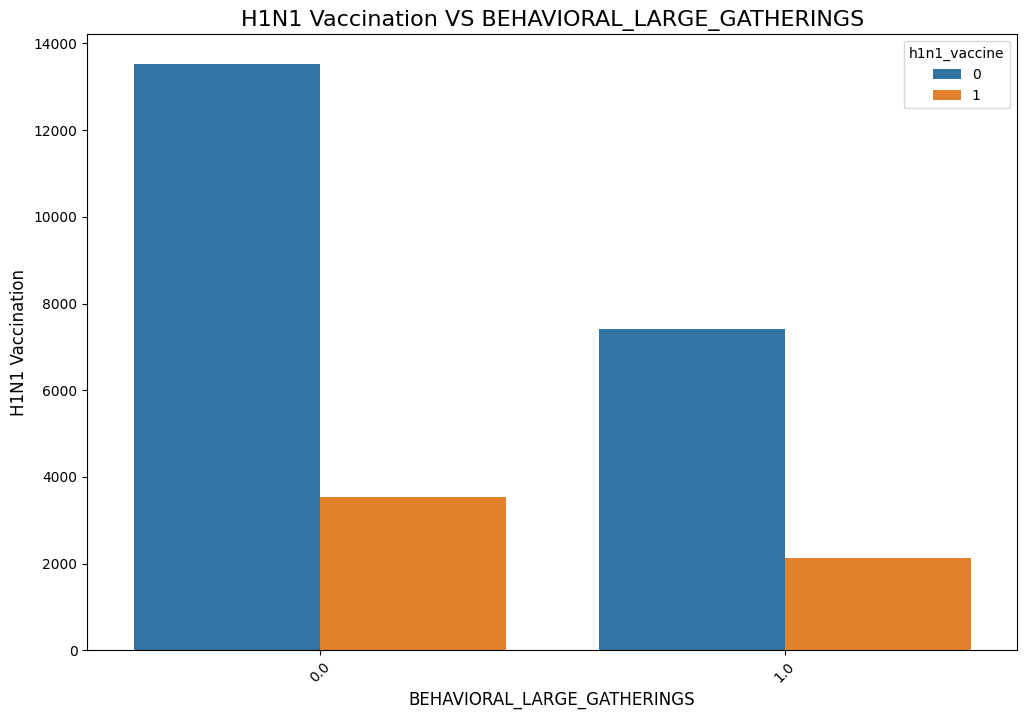

In [ ]:
plot_count(x='behavioral_large_gatherings', data=df_h1n1)

**most people, regardless of attending large gatherings or not, chose not to get the H1N1 vaccine. The trend is consistent across both groups, suggesting that large gatherings did not significantly influence vaccination rates.**

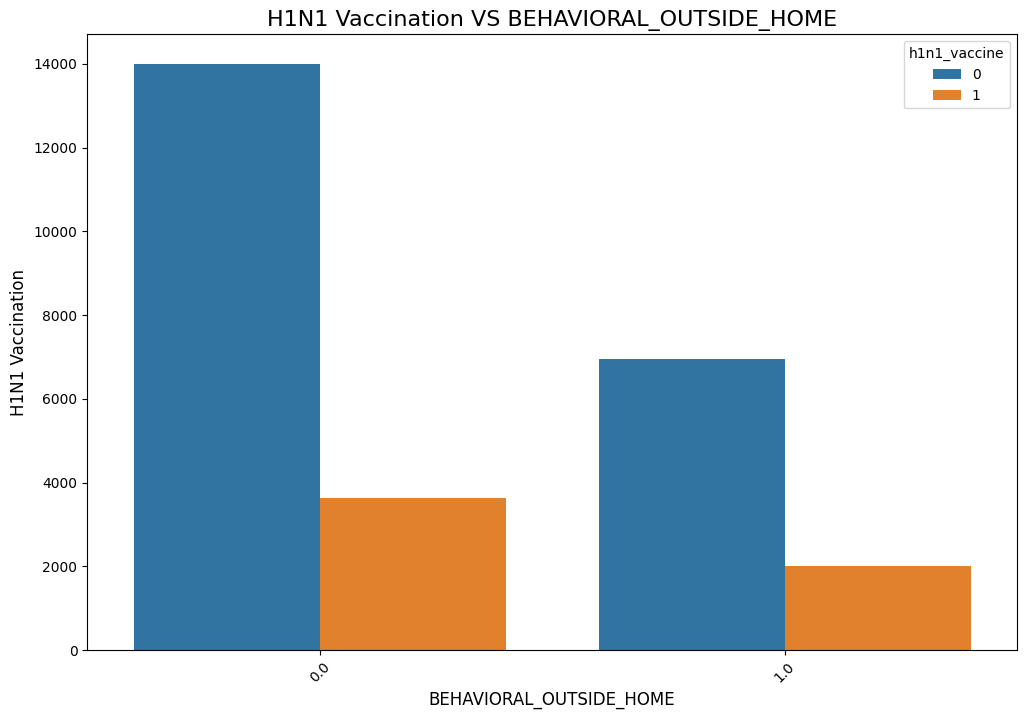

In [ ]:
plot_count(x='behavioral_outside_home', data=df_h1n1)


**The chart shows that most people, whether they stayed at home or went outside frequently, did not get the H1N1 vaccine. The overall trend indicates that going outside did not significantly impact vaccination rates.**

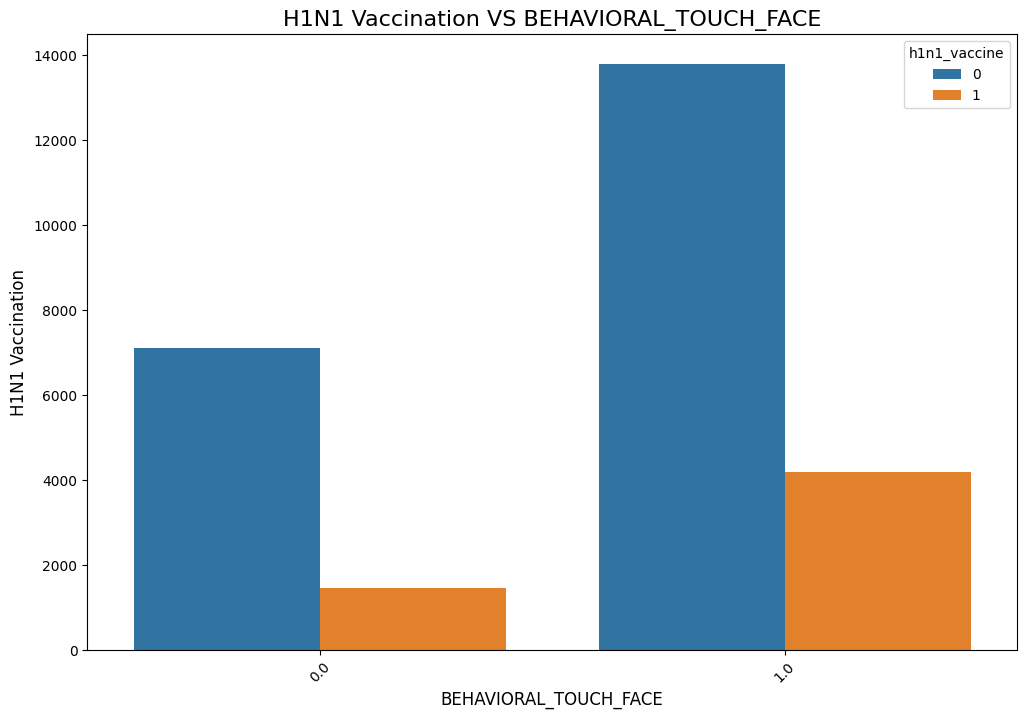

In [ ]:
plot_count(x='behavioral_touch_face', data=df_h1n1)

**touching the face is not a major differentiating factor for H1N1 vaccination decisions, as the trend of low vaccination remains consistent across both behaviors.**

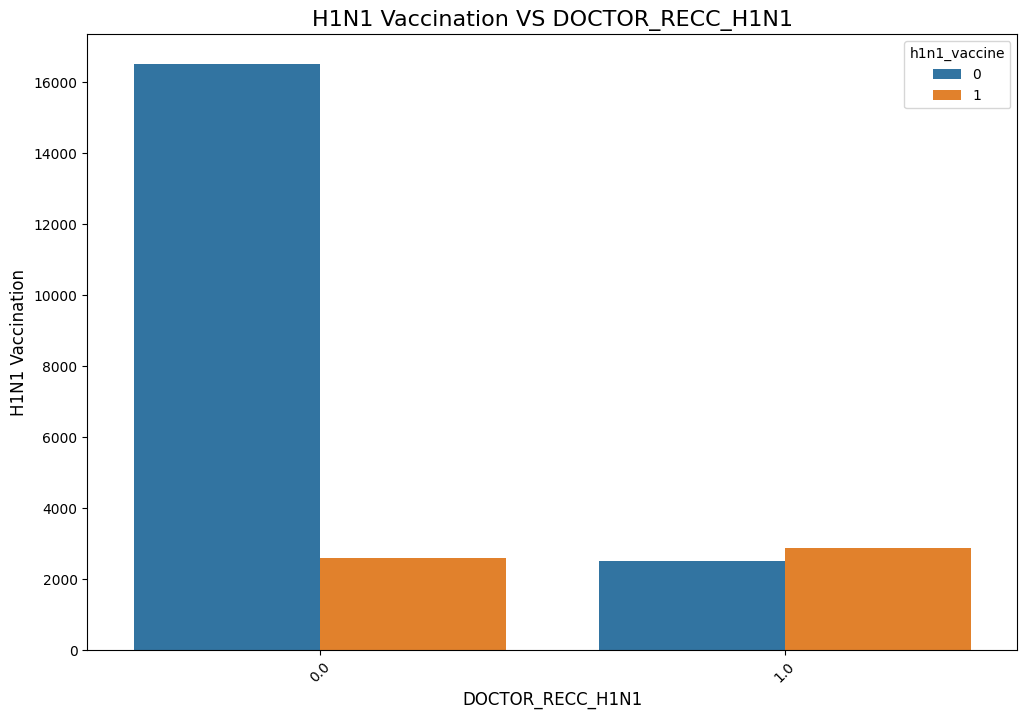

In [ ]:
plot_count(x='doctor_recc_h1n1', data=df_h1n1)


**Doctor recommendations strongly influence H1N1 vaccination. Most people got vaccinated when recommended by a doctor, while the majority did not vaccinate without such a recommendation.**



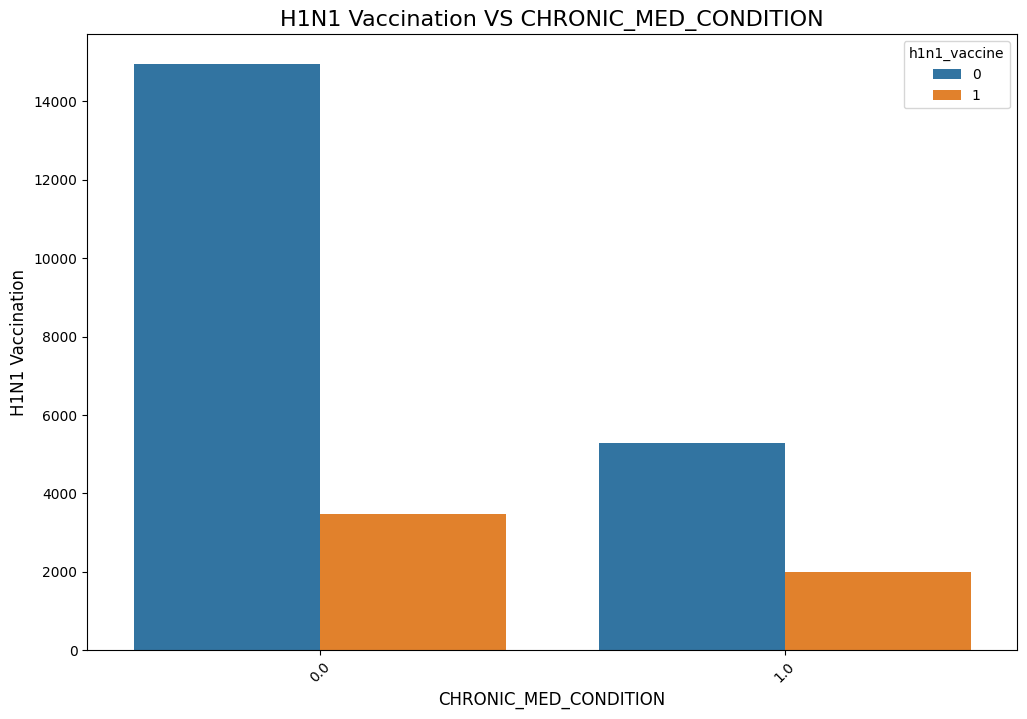

In [ ]:
plot_count(x='chronic_med_condition', data=df_h1n1)

**People with chronic medical conditions are more likely to get vaccinated, likely due to their higher risk of complications from H1N1.**

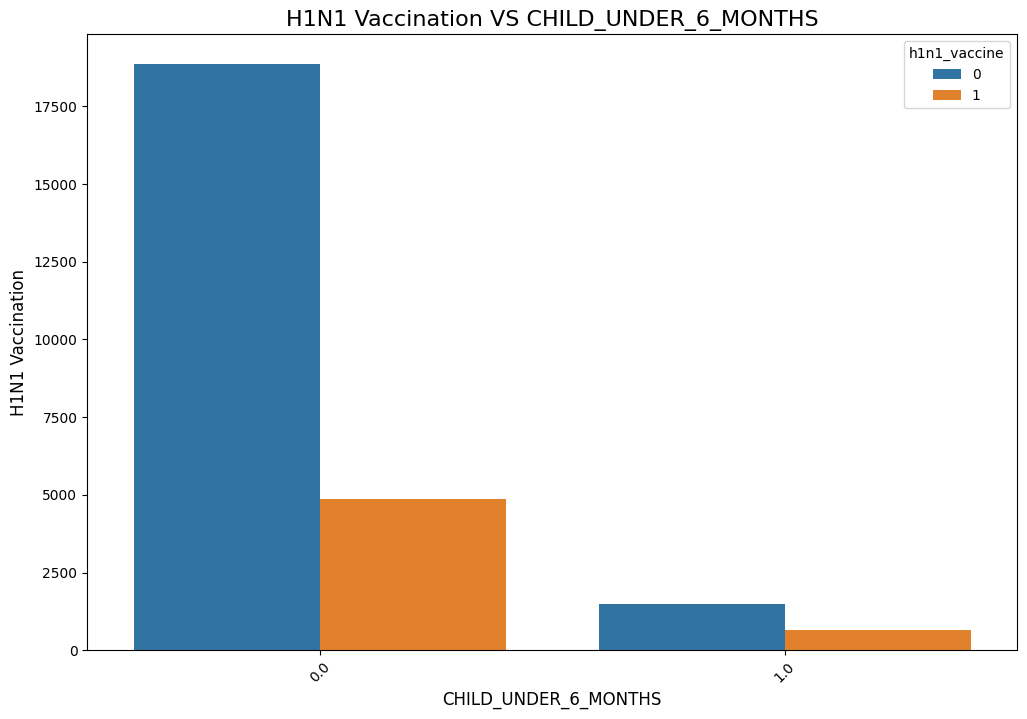

In [ ]:
plot_count(x='child_under_6_months', data=df_h1n1)


**Households with a child under 6 months are more likely to vaccinate against H1N1, likely due to concerns for the infant's safety.**

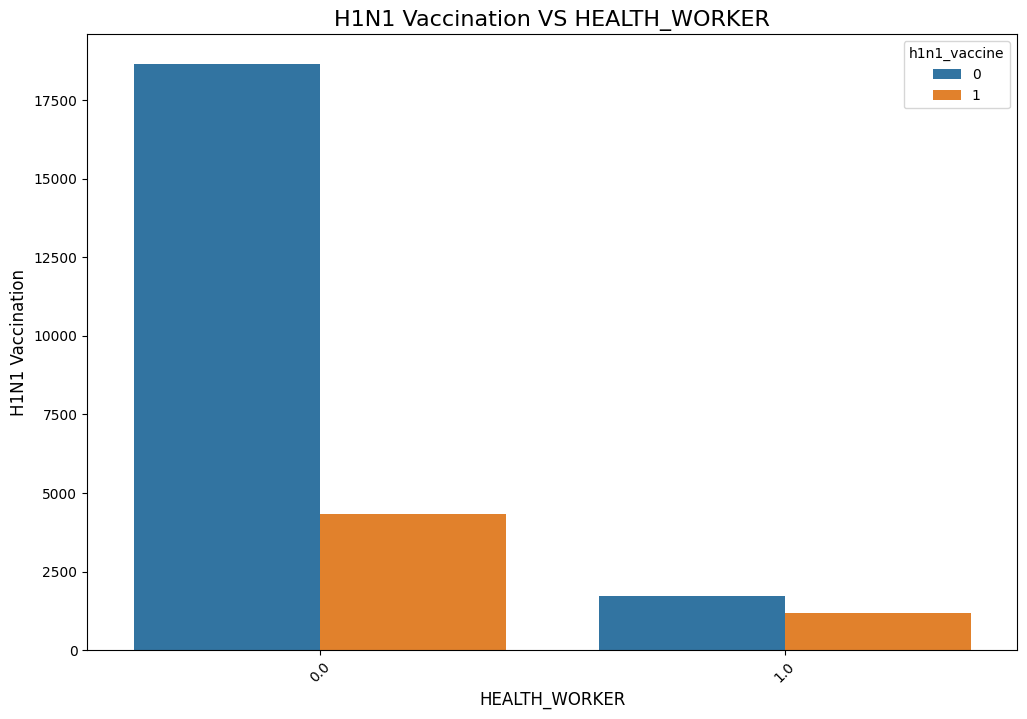

In [ ]:
plot_count(x='health_worker', data=df_h1n1)

**Being a health worker seems to correlate with a higher likelihood of receiving the H1N1 vaccine compared to non-health workers. However, the total number of health workers in the dataset is significantly smaller than non-health workers.**

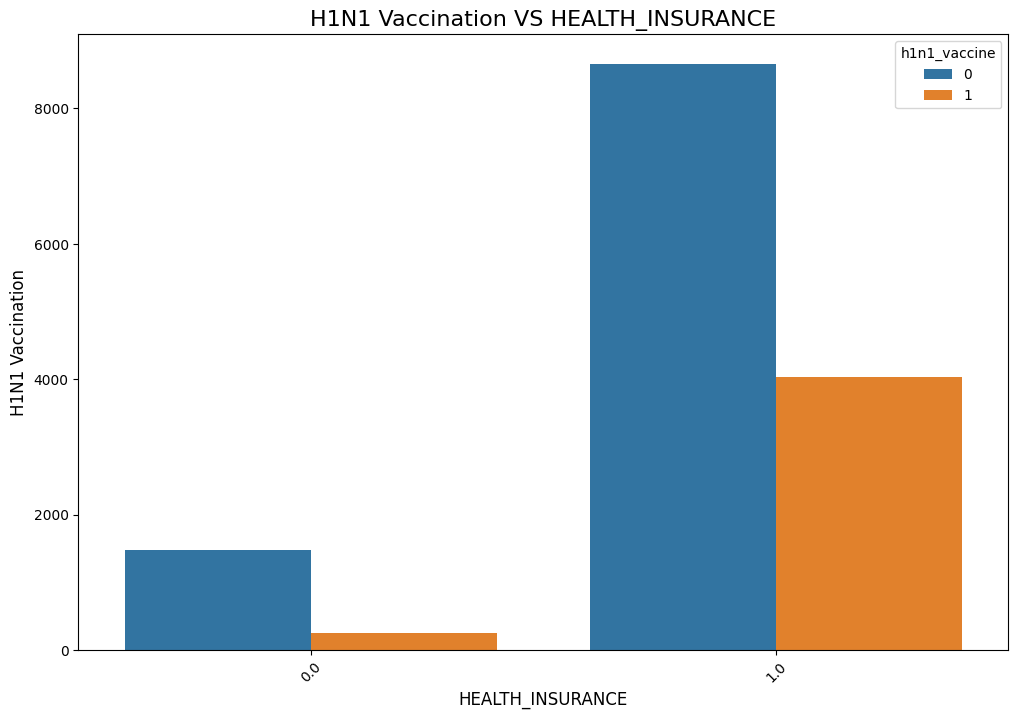

In [ ]:
plot_count(x='health_insurance', data=df_h1n1)

**Having health insurance appears to be associated with a higher likelihood of receiving the H1N1 vaccine. However, even among those with health insurance, a considerable number remained unvaccinated.**

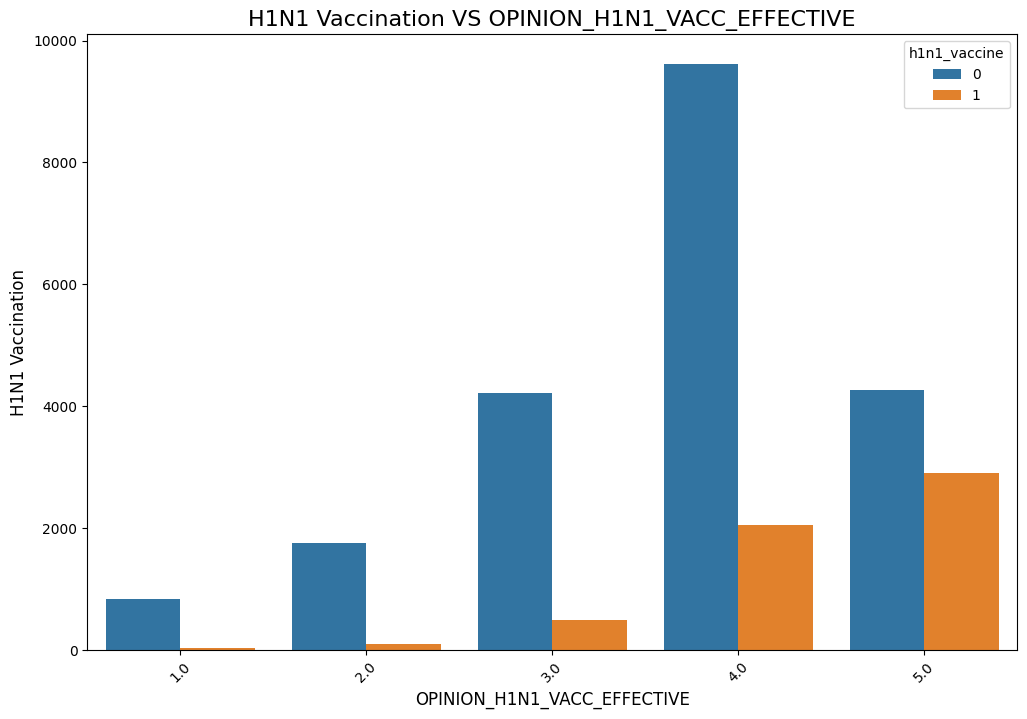

In [ ]:
plot_count(x='opinion_h1n1_vacc_effective', data=df_h1n1)


**People who think the H1N1 vaccine is effective are more likely to get vaccinated. Those with low opinions of the vaccine rarely get vaccinated, while those with high opinions are vaccinated more often. However, even some people who believe the vaccine is effective didn’t get vaccinated.**

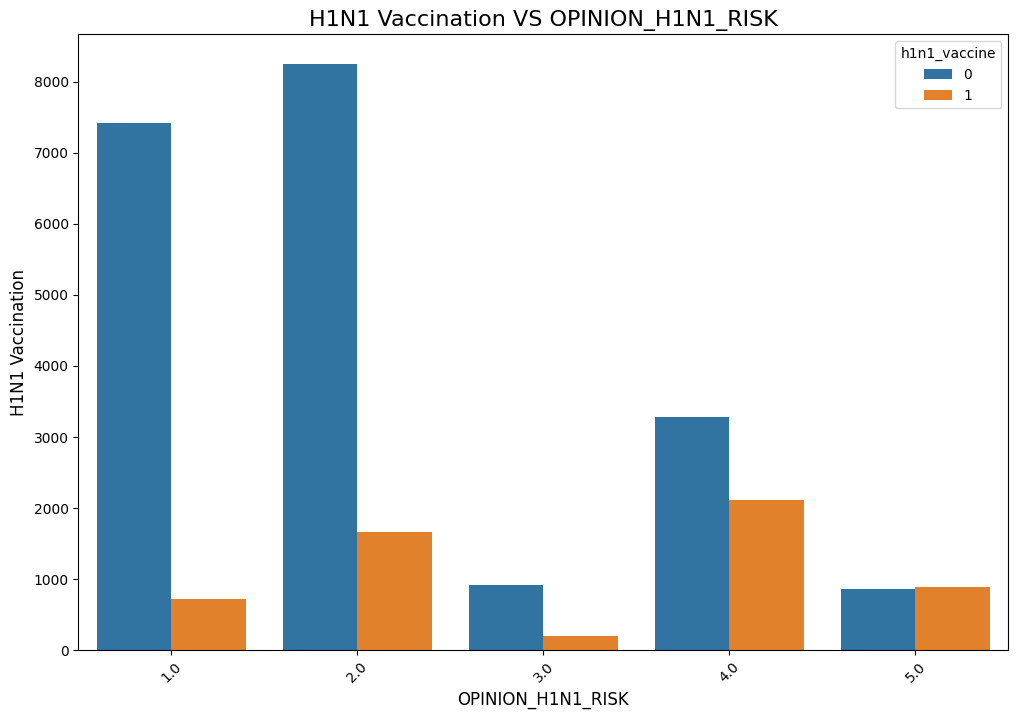

In [ ]:
plot_count(x='opinion_h1n1_risk', data=df_h1n1)

**The likelihood of getting the H1N1 vaccine increases with the individual's perception of risk associated with H1N1.**

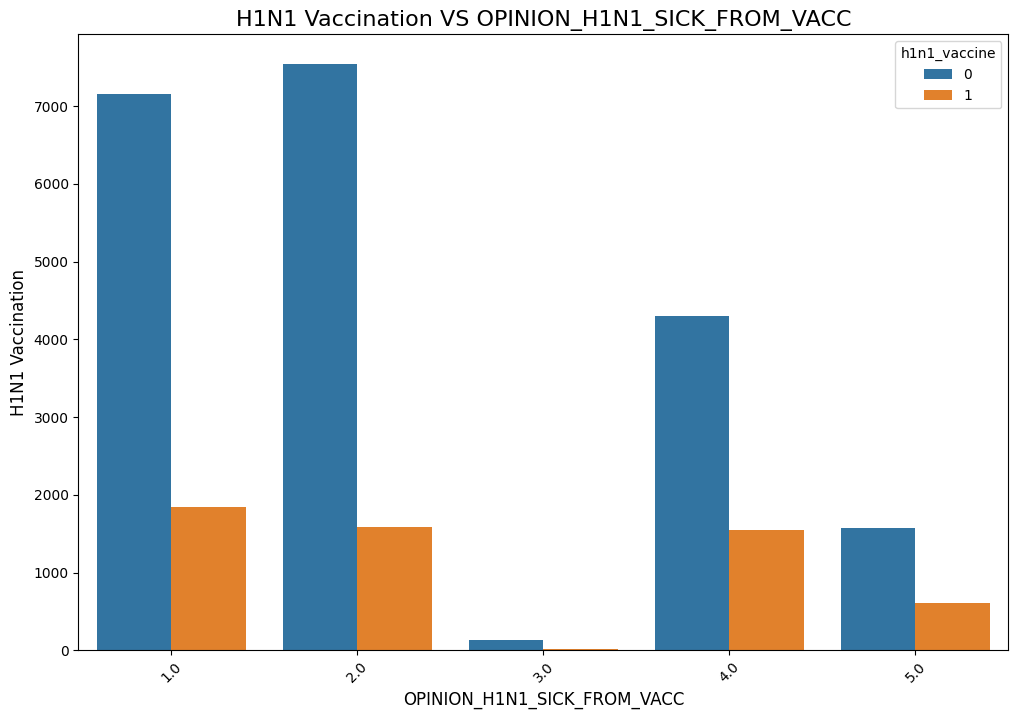

In [ ]:
plot_count(x='opinion_h1n1_sick_from_vacc', data=df_h1n1)

**A strong belief that the H1N1 vaccine might cause sickness is associated with lower vaccination rates. Individuals who perceive less risk of sickness from the vaccine are more likely to get vaccinated. This highlights the importance of addressing concerns about vaccine safety to improve vaccination uptake.**

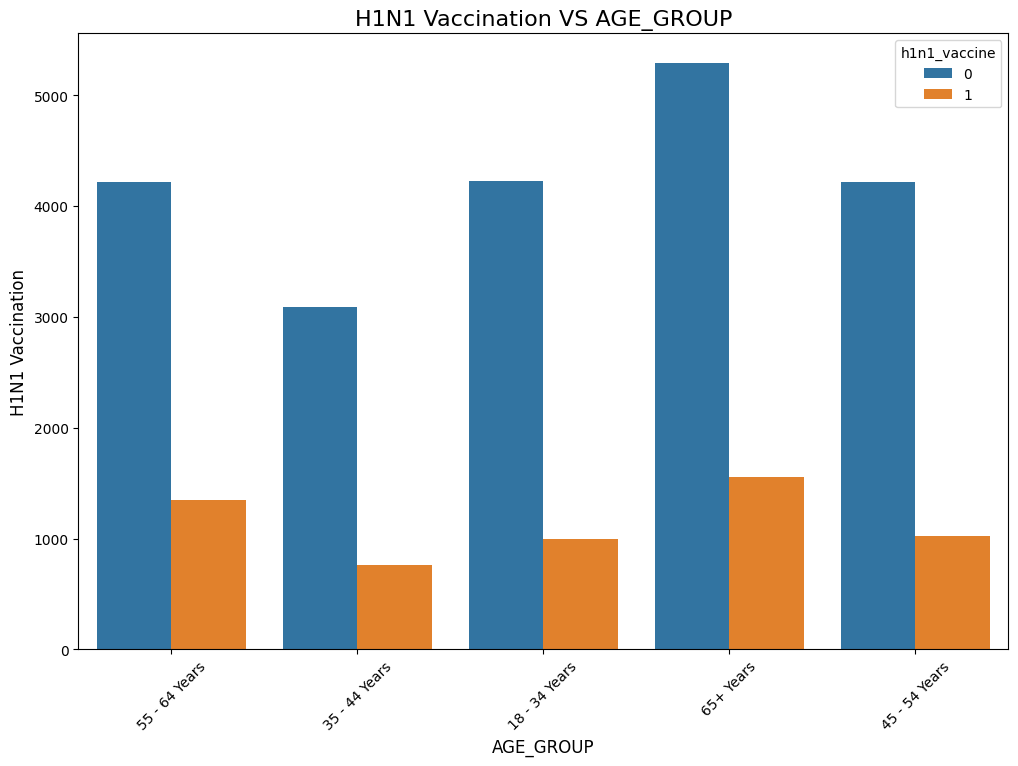

In [ ]:
plot_count(x='age_group', data=df_h1n1)

**Older adults (55+ years) have higher H1N1 vaccination rates, while younger age groups (especially 18-34 years) show lower vaccination rates. This suggests older individuals may perceive higher vulnerability or were prioritized for vaccination. Younger groups may need targeted efforts to boost uptake.**

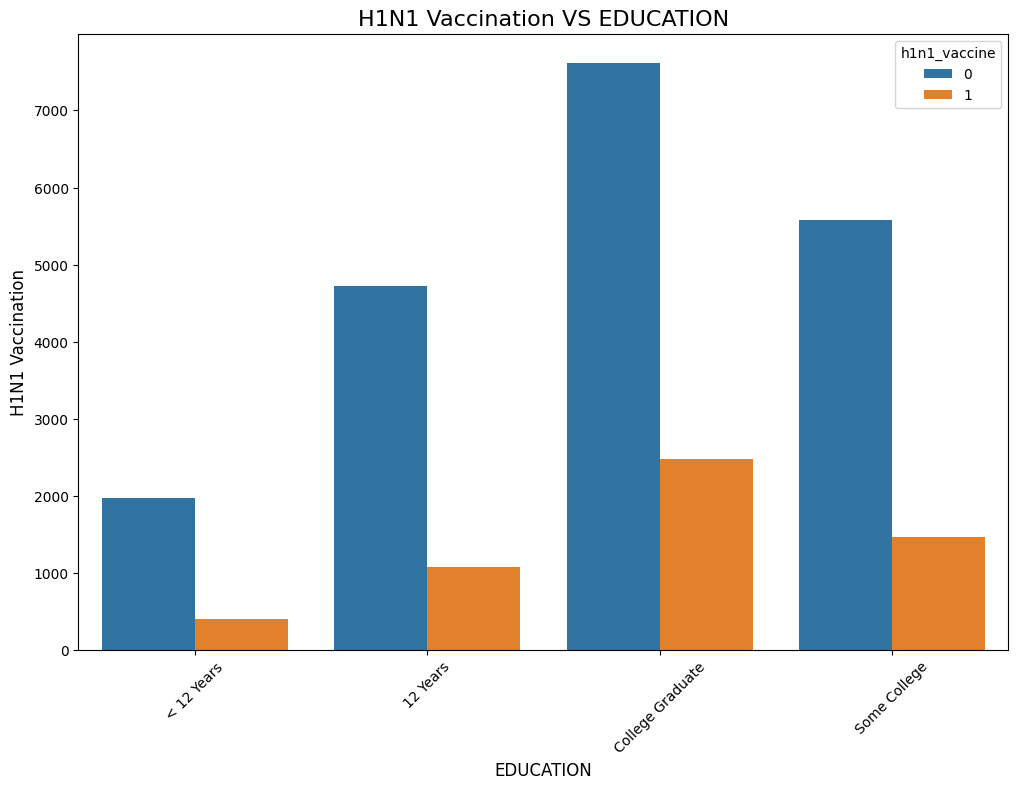

In [ ]:
plot_count(x='education', data=df_h1n1)

**H1N1 vaccination rates increase with higher education levels. College graduates have the highest vaccination rates, while those with less than 12 years of education have the lowest.**





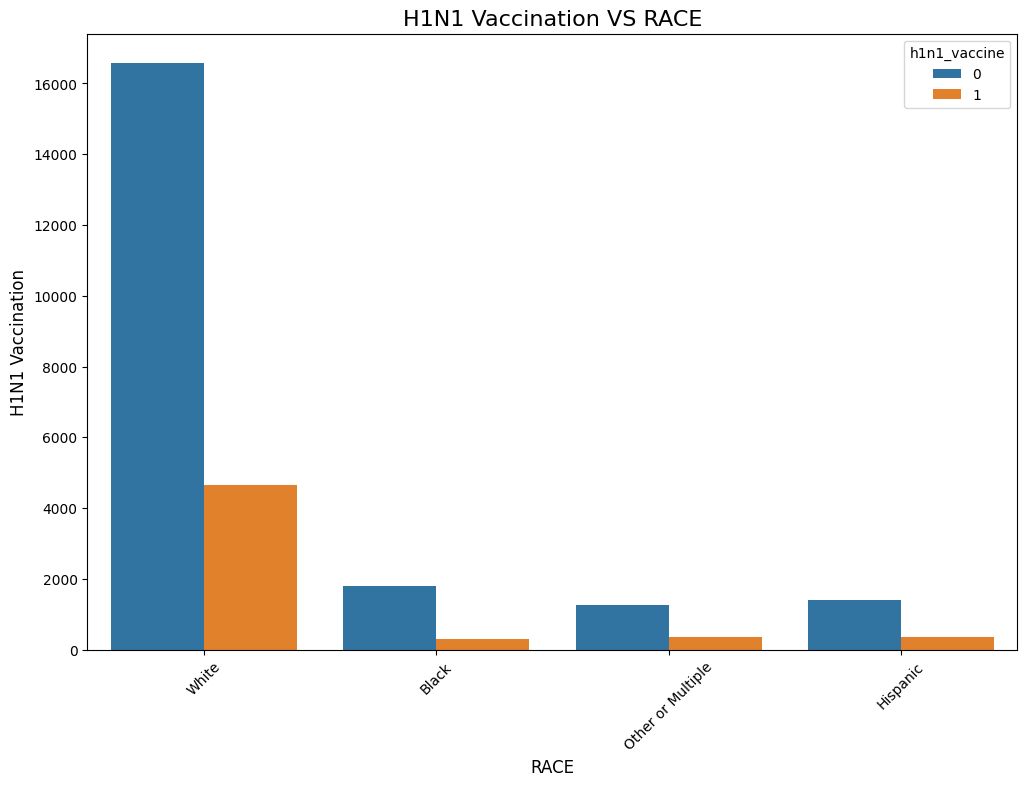

In [22]:
plot_count(x='race', data=df_h1n1)

**The White group has the highest number of vaccinated individuals, while other groups (Black, Hispanic, and "Other or Multiple") have significantly lower vaccination rates. Unvaccinated individuals outnumber vaccinated ones across all racial groups.**

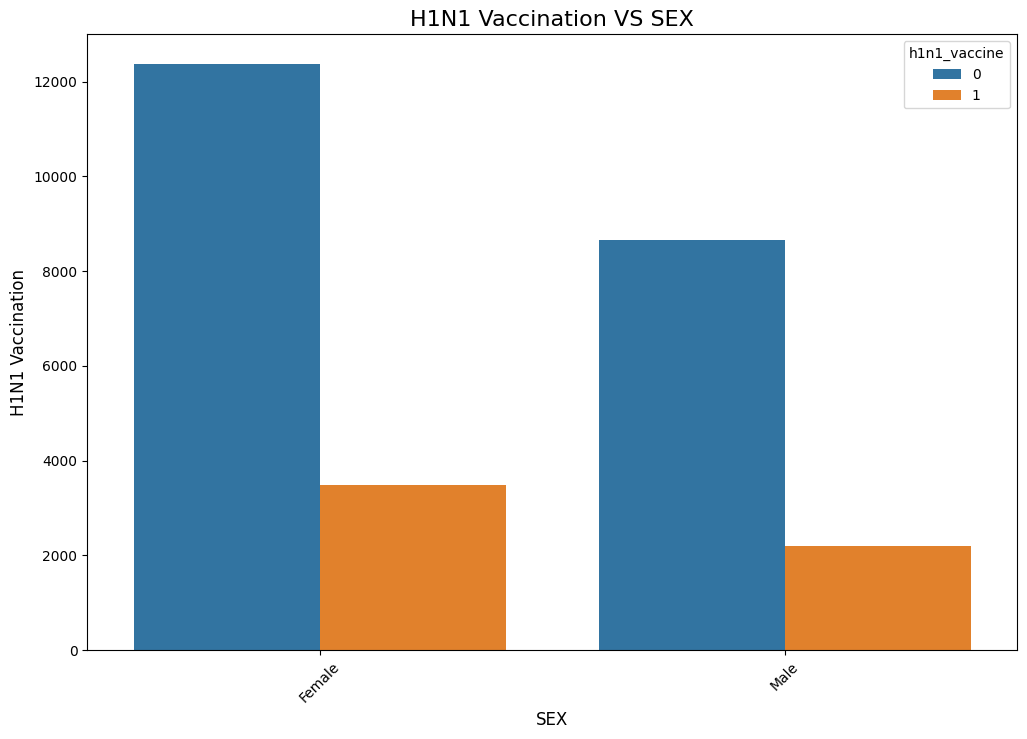

In [23]:
plot_count(x='sex', data=df_h1n1)

**Females have slightly higher H1N1 vaccination rates than males, but the majority of individuals in both genders are unvaccinated**

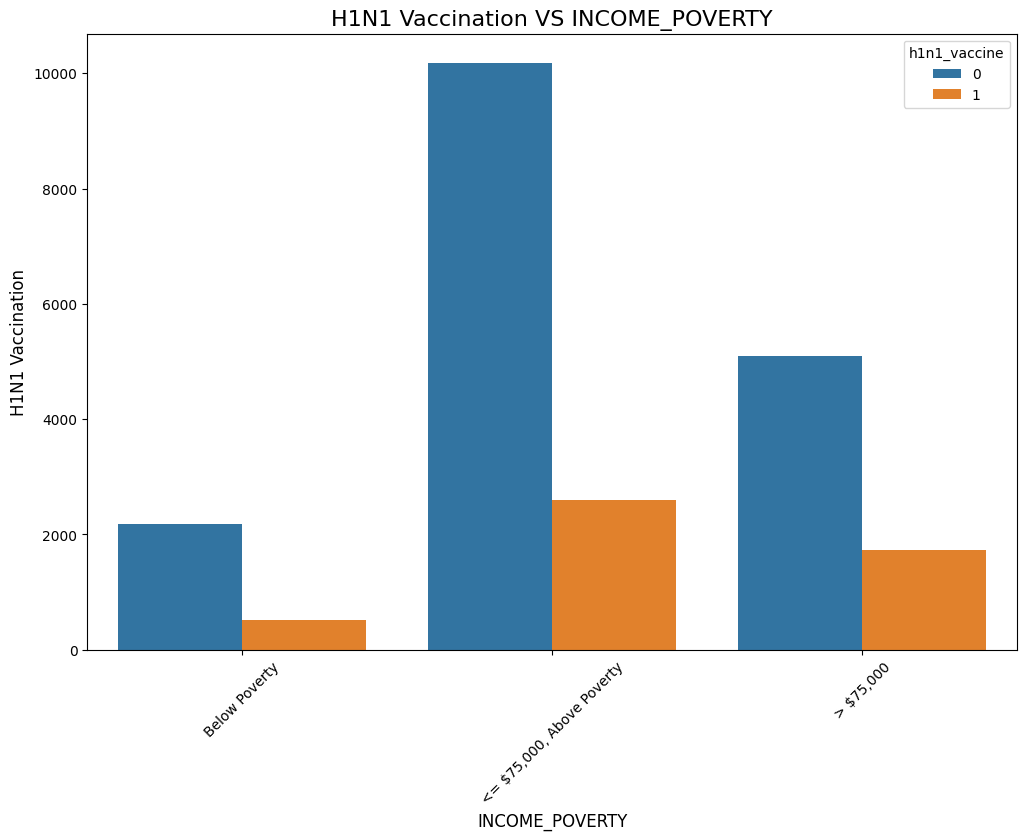

In [24]:
plot_count(x='income_poverty', data=df_h1n1)

**Higher income levels correlate with higher H1N1 vaccination rates, while individuals below the poverty line show the lowest vaccination uptake. Economic factors likely influence access and awareness.**

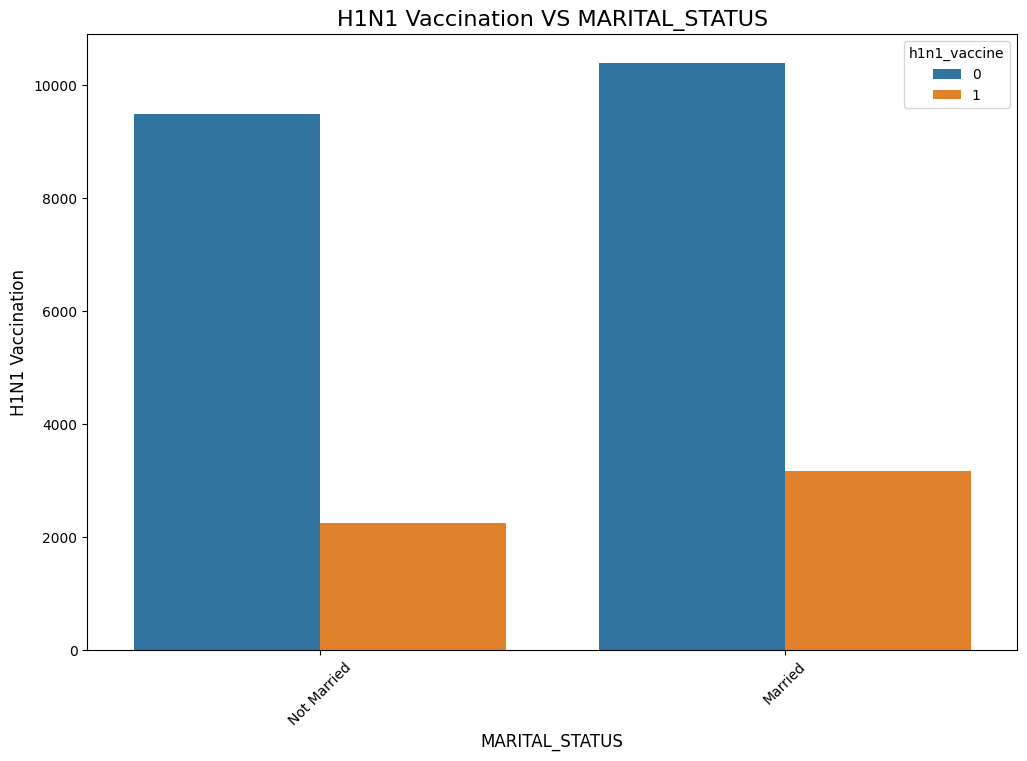

In [25]:
plot_count(x='marital_status', data=df_h1n1)

**Marital status shows no significant impact on H1N1 vaccination rates; both married and unmarried groups have low uptake**

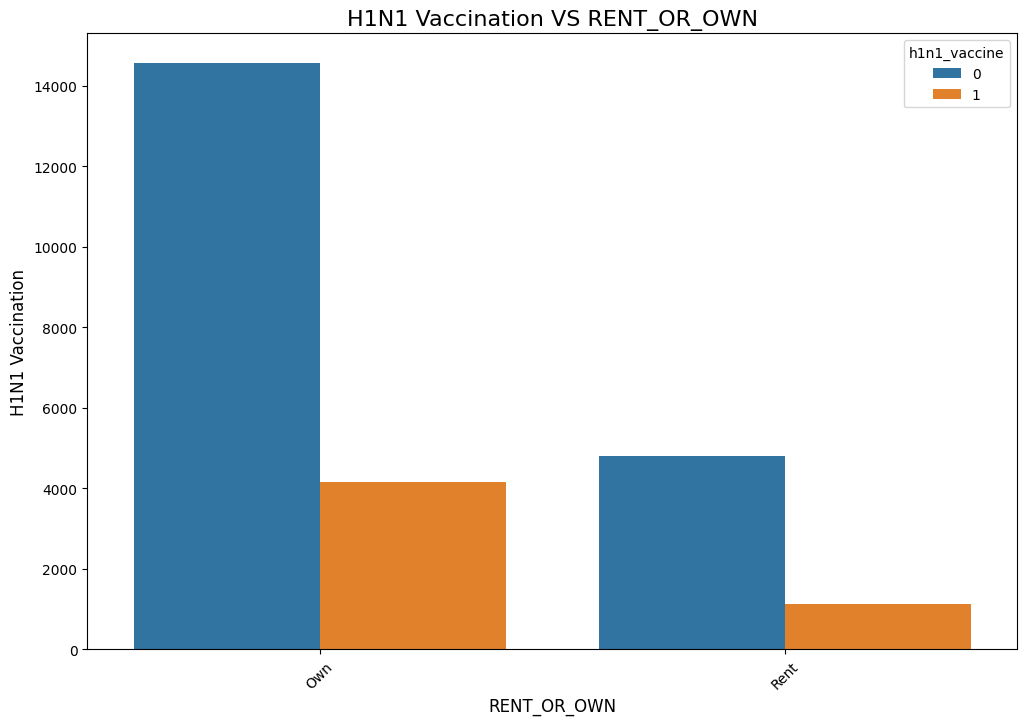

In [ ]:
plot_count(x='rent_or_own', data=df_h1n1)

**Homeownership appears associated with slightly higher vaccination rates, potentially linked to socioeconomic stability**

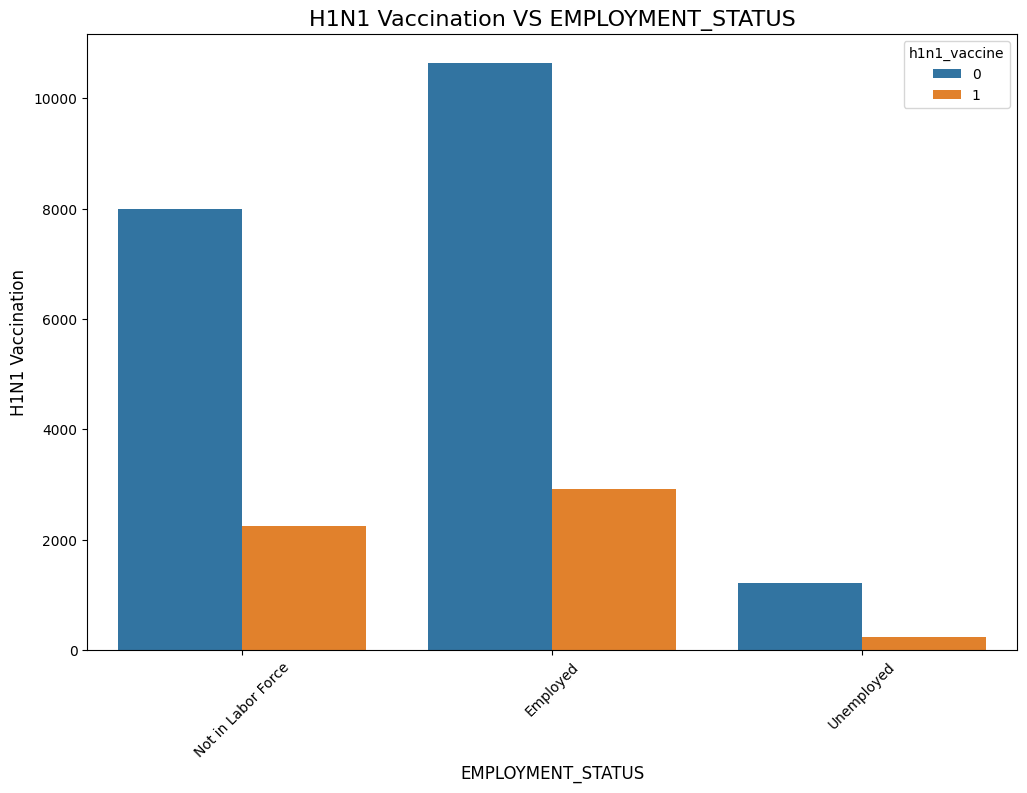

In [26]:
plot_count(x='employment_status', data=df_h1n1)

**Employed individuals have the highest H1N1 vaccination rates, while those not in the labor force or unemployed show lower vaccination uptake. Employment status may influence vaccination likelihood.**

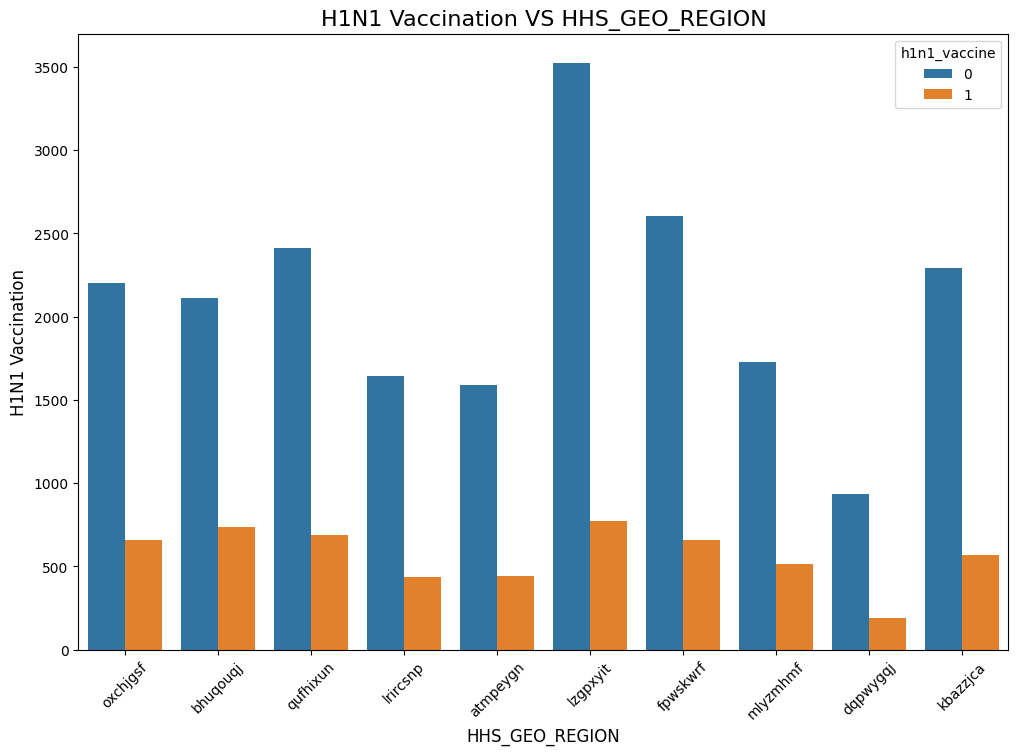

In [27]:
plot_count(x='hhs_geo_region', data=df_h1n1)


**H1N1 vaccination rates vary across regions, with lzgpxyit and kzazzjca showing the highest counts. Vaccinated individuals are fewer in all regions, indicating regional differences in vaccination uptake**

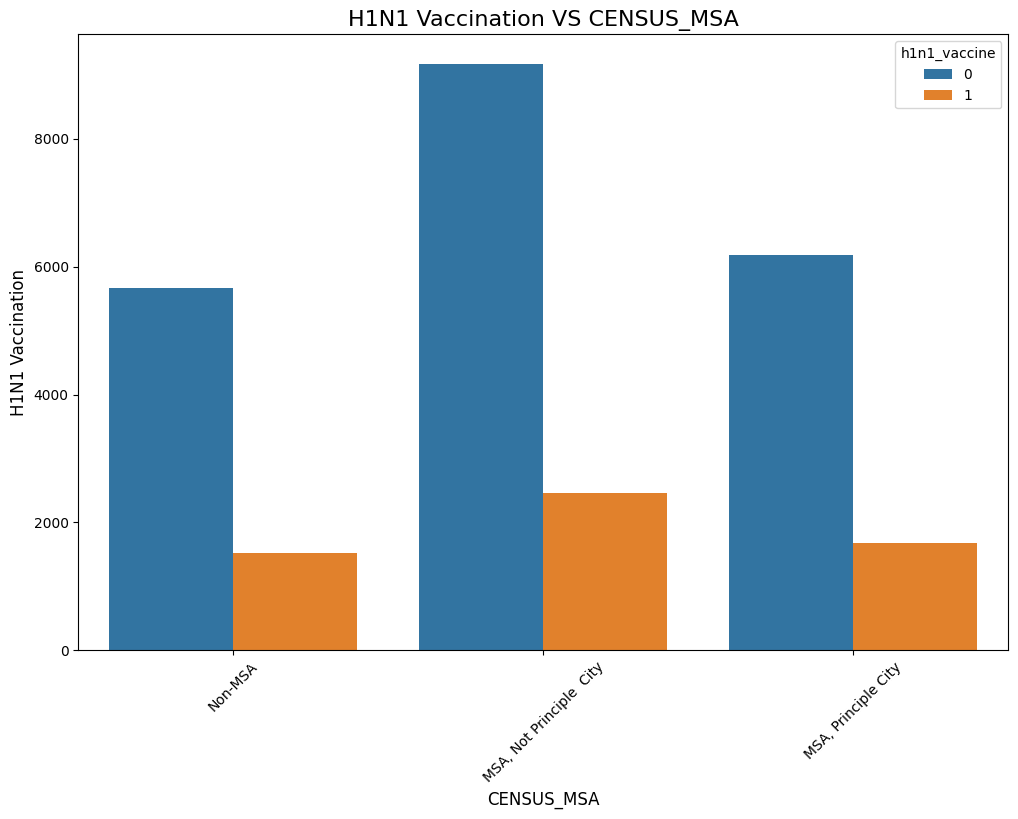

In [28]:
plot_count(x='census_msa', data=df_h1n1)

**H1N1 vaccination rates are low across all Census MSA categories. Most individuals are unvaccinated, with "MSA, Not Principal City" having the largest overall population and unvaccinated count, while "Non-MSA" has the fewest in both groups.**

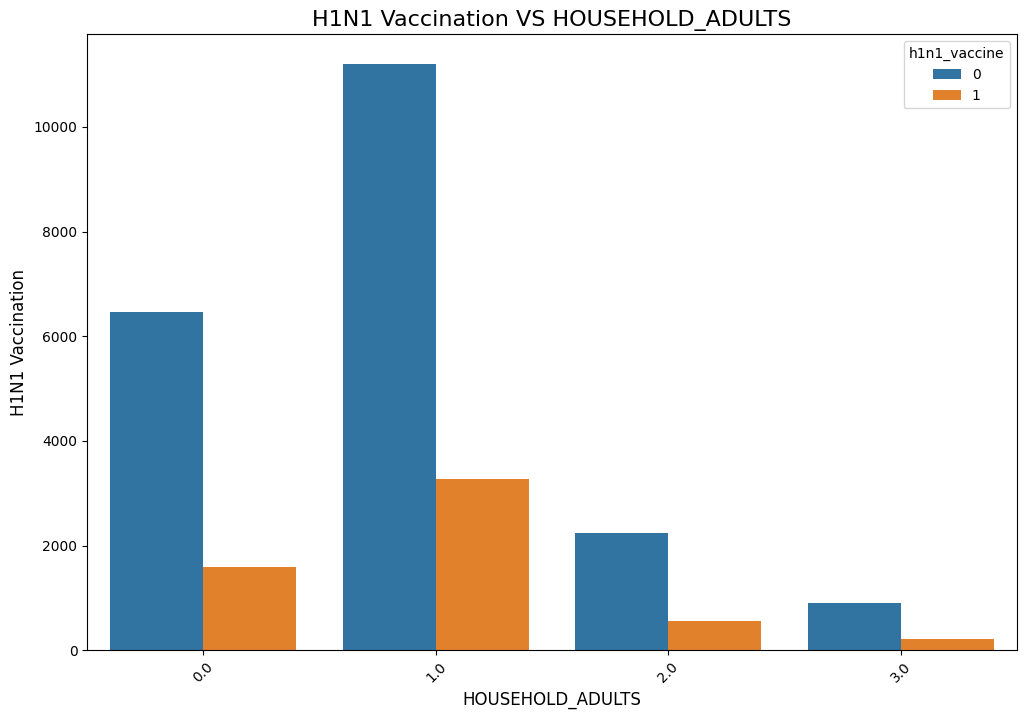

In [29]:
plot_count(x='household_adults', data=df_h1n1)

**H1N1 vaccination rates are low across all household sizes. Households with 1 adult have the highest counts of both vaccinated and unvaccinated individuals, while vaccination decreases in larger households.**

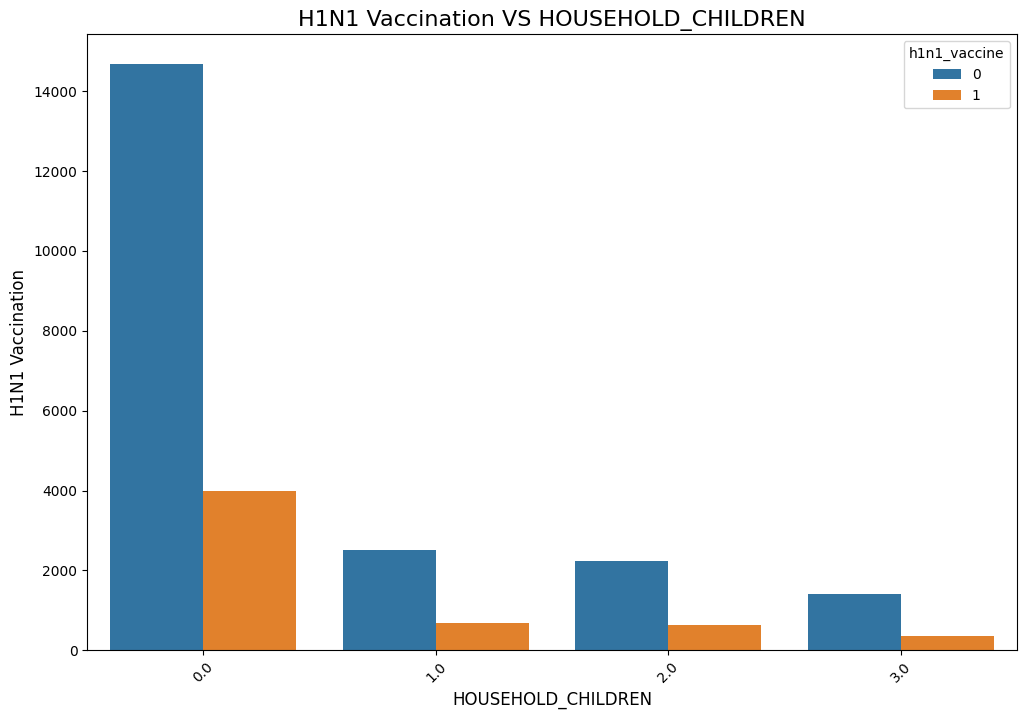

In [30]:
plot_count(x='household_children', data=df_h1n1)

**H1N1 vaccination rates are highest in households without children and decline as the number of children increases. Unvaccinated individuals consistently outnumber vaccinated ones across all household sizes**

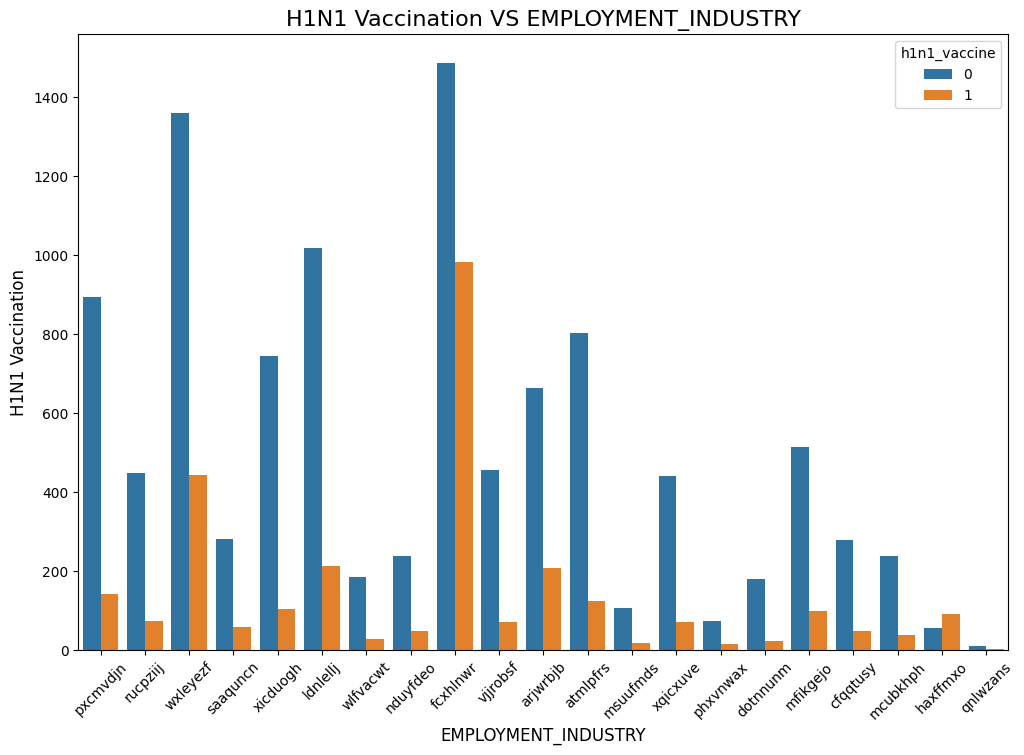

In [31]:
plot_count(x='employment_industry', data=df_h1n1)

**H1N1 vaccination rates vary significantly across employment industries, with most industries having far more unvaccinated individuals than vaccinated ones. Targeted efforts are needed to address these disparities and improve vaccine uptake**

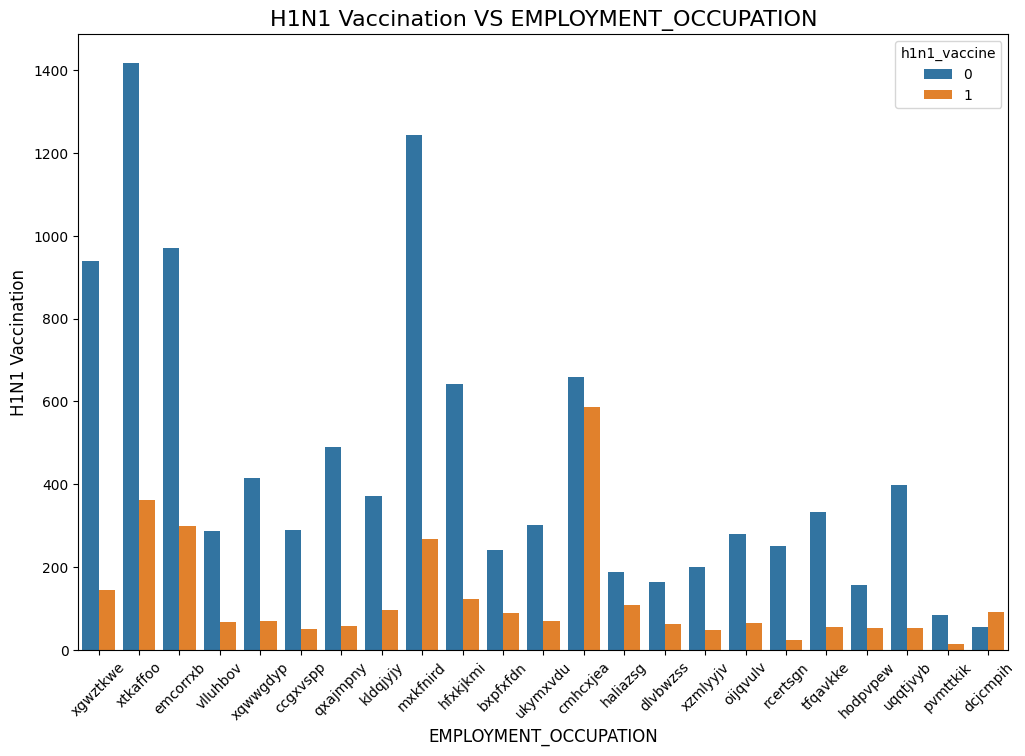

In [ ]:
plot_count(x='employment_occupation', data=df_h1n1)

**H1N1 vaccination rates are low across most occupations, with unvaccinated individuals far outnumbering vaccinated ones. Efforts should focus on boosting vaccine uptake, particularly in occupations with minimal participation.**

## **Conclusion BI- Variate Analysis:**
H1N1 vaccination rates are low across most groups, with ***Key Factors*** influencing uptake including ***Health Awareness, Socioeconomic Status, and Doctor Recommendations.*** Older adults, health workers, those with higher education, income, and health insurance are more likely to get vaccinated. Behaviors like frequent handwashing, face mask usage, and avoiding large gatherings slightly increase vaccination rates. Barriers include vaccine safety concerns, younger age, lower income, and limited knowledge about H1N1. Focused interventions are needed to address these issues and improve vaccination uptake.


### **TRAINNG AND TESTING A MODEL**

In [51]:
# Define our X and y
X = df.drop(columns = ['respondent_id', 'h1n1_vaccine', 'seasonal_vaccine'], axis=1)
y = df['h1n1_vaccine']

In [52]:
# Train - Test Set Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42 )

In [53]:
# Set up lists for each columns datatypes
num_cols = []
ohe_cols = []
freq_cols = []

for c in X.columns:
    if X[c].dtype in ['float64', 'int64']:
        num_cols.append(c)
    elif X[c].nunique() < 10:
        ohe_cols.append(c)
    else:
        freq_cols.append(c)

In [54]:
# We wanted to see each column category
print(f'Numerical Columns:', num_cols)
print('\n')
print(f'Object Columns (with less than 10 unique values):', ohe_cols)
print('\n')
print(f'Object Columns (with more than 10 unique values):', freq_cols)

Numerical Columns: ['h1n1_concern', 'h1n1_knowledge', 'behavioral_antiviral_meds', 'behavioral_avoidance', 'behavioral_face_mask', 'behavioral_wash_hands', 'behavioral_large_gatherings', 'behavioral_outside_home', 'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal', 'chronic_med_condition', 'child_under_6_months', 'health_worker', 'health_insurance', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk', 'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective', 'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'household_adults', 'household_children']


Object Columns (with less than 10 unique values): ['age_group', 'education', 'race', 'sex', 'income_poverty', 'marital_status', 'rent_or_own', 'employment_status', 'census_msa']


Object Columns (with more than 10 unique values): ['hhs_geo_region', 'employment_industry', 'employment_occupation']


In [55]:
# Preprocessing with Pipelines
num_transformer = Pipeline(steps=[
    ('num_imputer', IterativeImputer(max_iter=100, random_state=42)),   # replace missing values by IterativeImputer
    ('minmaxscaler', MinMaxScaler())                                    # Scale the numbers by MinMaxScaler
])

ohe_transformer = Pipeline(steps=[
    ('ohe_imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),  # replace missing categories by SimpleImputer
    ('ohe_encoder', OneHotEncoder(handle_unknown='ignore'))                     # Transform each category into a new column
])

freq_transformer = Pipeline(steps=[
    ('freq_encoder', ce.count.CountEncoder(normalize=True, min_group_size=.05)), # replace category names with frequency counts by CountEncoder
    ('freq_imputer', IterativeImputer(max_iter=100, random_state=42))            # replace missing values by IterativeImputer
])

In [56]:
# Preprocessor defined using ColumnTransformer by packaging the all components together
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, num_cols),
        ('ohe', ohe_transformer, ohe_cols),
        ('freq', freq_transformer, freq_cols)
    ])

In [57]:
# Fitting preprocessor to see the components as a whole
preprocessor.fit(X_train)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('num_imputer',
                                                  IterativeImputer(max_iter=100,
                                                                   random_state=42)),
                                                 ('minmaxscaler',
                                                  MinMaxScaler())]),
                                 ['h1n1_concern', 'h1n1_knowledge',
                                  'behavioral_antiviral_meds',
                                  'behavioral_avoidance',
                                  'behavioral_face_mask',
                                  'behavioral_wash_hands',
                                  'behavioral_large_gatherings',
                                  'behavioral_outside_home',
                                  'behavioral...
                                 ['age_group', 'education', 'race', 'sex',
                                  'income_poverty', 'marital_status',
                                  'rent_or_own', 'employment_status',
                                  'census_msa']),
                                ('freq',
                                 Pipeline(steps=[('freq_encoder',
                                                  CountEncoder(combine_min_nan_groups=True,
                                                               min_group_size=0.05,
                                                               normalize=True)),
                                                 ('freq_imputer',
                                                  IterativeImputer(max_iter=100,
                                                                   random_state=42))]),
                                 ['hhs_geo_region', 'employment_industry',
                                  'employment_occupation'])])

In [58]:
# Let'see what this looks like after the preprocessor transformation
X_train_transformed = preprocessor.transform(X_train)
X_train_transformed.shape

(21365, 59)

In [59]:
# Visualize it with Pandas dataframe
pd.DataFrame(X_train_transformed).head()

0    1         2         3         4         5    6    7    8   \
0  0.666667  0.5  0.014625  0.967488  0.043917  0.894587  0.0  1.0  1.0   
1  0.666667  0.5  1.000000  0.967488  1.000000  0.894587  1.0  1.0  1.0   
2  0.000000  0.5  0.014625  0.000000  0.043917  0.894587  0.0  1.0  0.0   
3  0.333333  0.5  0.014625  0.000000  0.043917  0.000000  0.0  0.0  0.0   
4  0.333333  0.0  0.014625  0.000000  0.043917  0.894587  0.0  0.0  0.0   

         9         10   11   12       13        14    15        16    17  \
0  0.133733  0.134134  1.0  0.0  0.08447  0.000000  1.00  0.759586  0.25   
1  0.133733  0.134134  0.0  0.0  0.08447  0.684270  1.00  0.759586  0.75   
2  0.133733  0.134134  0.0  0.0  0.08447  0.912059  0.00  0.278757  0.00   
3  0.133733  0.134134  0.0  0.0  0.08447  0.912059  0.75  0.278757  0.00   
4  0.133733  0.134134  0.0  0.0  0.08447  0.912059  0.50  0.278757  1.00   

     18    19    20        21        22   23   24   25   26   27   28   29  \
0  0.75  0.75  0.25  0.333333  0.000000  0.0  0.0  1.0  0.0  0.0  0.0  0.0   
1  1.00  0.75  0.75  0.000000  0.000000  0.0  0.0  1.0  0.0  0.0  0.0  0.0   
2  0.00  0.75  0.00  0.333333  0.333333  0.0  1.0  0.0  0.0  0.0  0.0  0.0   
3  0.75  0.25  0.25  0.000000  0.000000  0.0  0.0  1.0  0.0  0.0  0.0  0.0   
4  1.00  0.25  1.00  0.333333  0.333333  0.0  0.0  0.0  0.0  1.0  0.0  0.0   

    30   31   32   33   34   35   36   37   38   39   40   41   42   43   44  \
0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0   
1  1.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0  1.0   
2  0.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0  1.0  1.0  0.0   
3  1.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0   
4  1.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0   

    45   46   47   48   49   50   51   52   53   54   55        56        57  \
0  0.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0  0.159420  0.497402   
1  0.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.159420  0.066791   
2  0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.117061  0.341774   
3  0.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0  0.105032  0.341774   
4  0.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  0.082659  0.497402   

         58  
0  0.502504  
1  0.374865  
2  0.065809  
3  0.374865  
4  0.502504

# **Modeling Iterations**



### **MODEL 1: Decision Tree Classifier**

In [60]:
# Setting up the DecisionTreeClassifier to go though the pipeline
dtc = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', DecisionTreeClassifier(class_weight='balanced', max_depth = 5))
])


In [61]:
# fitting the model to the training data
dtc.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   IterativeImputer(max_iter=100,
                                                                                    random_state=42)),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['h1n1_concern',
                                                   'h1n1_knowledge',
                                                   'behavioral_antiviral_meds',
                                                   'behavioral_avoidance',
                                                   'behavioral_face_mask',
                                                   'behavioral_wash_hands',
                                                   'behavioral_large_gatherings',
                                                   'beha...
                                                   'employment_status',
                                                   'census_msa']),
                                                 ('freq',
                                                  Pipeline(steps=[('freq_encoder',
                                                                   CountEncoder(combine_min_nan_groups=True,
                                                                                min_group_size=0.05,
                                                                                normalize=True)),
                                                                  ('freq_imputer',
                                                                   IterativeImputer(max_iter=100,
                                                                                    random_state=42))]),
                                                  ['hhs_geo_region',
                                                   'employment_industry',
                                                   'employment_occupation'])])),
                ('classifier',
                 DecisionTreeClassifier(class_weight='balanced', max_depth=5))])

              precision    recall  f1-score   support

           0       0.92      0.81      0.86      4212
           1       0.51      0.74      0.60      1130

    accuracy                           0.79      5342
   macro avg       0.71      0.78      0.73      5342
weighted avg       0.83      0.79      0.81      5342



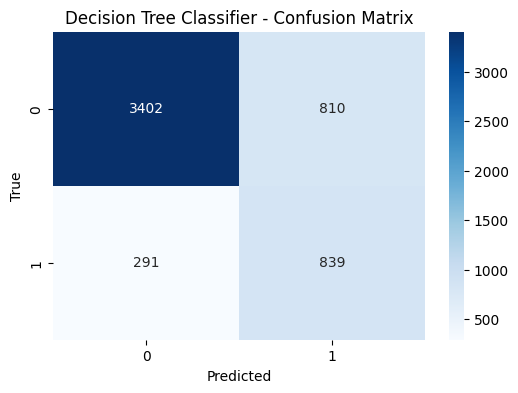

Train F1 Score (Micro) for Decision Tree Classifier is : 0.7926983384039317
Test F1 Score (Micro) for Decision Tree Classifier is : 0.793897416697866
The Roc_Auc score for Decision Tree Classifier is : 0.8483047802738068


In [62]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Predictions for test and train sets
pred_1 = dtc.predict(X_test)
train_pred_1 = dtc.predict(X_train)

# Classification report for test set
print(classification_report(y_test, pred_1))

# Confusion matrix
cm = confusion_matrix(y_test, pred_1)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Decision Tree Classifier - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# F1 scores for training and testing datasets using micro average
train_score_1 = f1_score(y_train, train_pred_1, average='micro')
score_1 = f1_score(y_test, pred_1, average='micro')

# Print F1 scores
print('Train F1 Score (Micro) for Decision Tree Classifier is : {}'.format(train_score_1))
print('Test F1 Score (Micro) for Decision Tree Classifier is : {}'.format(score_1))


# Print roc auc scores
roc_auc = roc_auc_score(y_test, dtc.predict_proba(X_test)[:, 1])
print('The Roc_Auc score for Decision Tree Classifier is : {}'.format(roc_auc))


## **MODEL 2: Logistic Regression**

In [63]:
# Setting up the logistic regression model to go through the pipeline
logreg = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=500, C=1, class_weight= 'balanced', solver= 'lbfgs',
                                      random_state=42))
])


In [64]:
# fitting the model to the training data
logreg.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   IterativeImputer(max_iter=100,
                                                                                    random_state=42)),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['h1n1_concern',
                                                   'h1n1_knowledge',
                                                   'behavioral_antiviral_meds',
                                                   'behavioral_avoidance',
                                                   'behavioral_face_mask',
                                                   'behavioral_wash_hands',
                                                   'behavioral_large_gatherings',
                                                   'beha...
                                                   'census_msa']),
                                                 ('freq',
                                                  Pipeline(steps=[('freq_encoder',
                                                                   CountEncoder(combine_min_nan_groups=True,
                                                                                min_group_size=0.05,
                                                                                normalize=True)),
                                                                  ('freq_imputer',
                                                                   IterativeImputer(max_iter=100,
                                                                                    random_state=42))]),
                                                  ['hhs_geo_region',
                                                   'employment_industry',
                                                   'employment_occupation'])])),
                ('classifier',
                 LogisticRegression(C=1, class_weight='balanced', max_iter=500,
                                    random_state=42))])

              precision    recall  f1-score   support

           0       0.91      0.79      0.85      4212
           1       0.48      0.72      0.58      1130

    accuracy                           0.78      5342
   macro avg       0.70      0.76      0.71      5342
weighted avg       0.82      0.78      0.79      5342



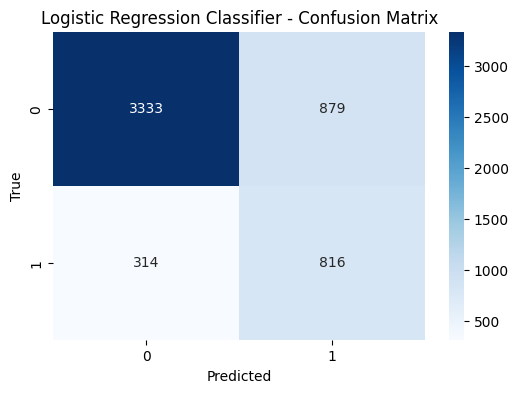

Train F1 Score (Micro) for Logistic Regression Classifier is : 0.775754739059209
Test F1 Score (Micro) for Logistic Regression Classifier is : 0.7766754024709847
The Roc_Auc score for Logistic Regression Classifier is : 0.8328774088361108


In [65]:
# Predictions for test and train sets
pred_2 = logreg.predict(X_test)
train_pred_2 = logreg.predict(X_train)

# Classification report for test set
print(classification_report(y_test, pred_2))

# Confusion matrix
cm = confusion_matrix(y_test, pred_2)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Logistic Regression Classifier - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# F1 scores for training and testing datasets using micro average
train_score_2 = f1_score(y_train, train_pred_2, average='micro')
score_2 = f1_score(y_test, pred_2, average='micro')

# Print F1 scores
print('Train F1 Score (Micro) for Logistic Regression Classifier is : {}'.format(train_score_2))
print('Test F1 Score (Micro) for Logistic Regression Classifier is : {}'.format(score_2))


# Print roc auc scores
roc_auc = roc_auc_score(y_test, logreg.predict_proba(X_test)[:, 1])
print('The Roc_Auc score for Logistic Regression Classifier is : {}'.format(roc_auc))


## **MODEL 3: KNN Classifier**

In [66]:
# Setting up the KNN model to go through the pipeline
knn = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', KNeighborsClassifier(n_neighbors=5, p=1, weights= 'distance'))
])

In [67]:
# fitting the model to the training data
knn.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   IterativeImputer(max_iter=100,
                                                                                    random_state=42)),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['h1n1_concern',
                                                   'h1n1_knowledge',
                                                   'behavioral_antiviral_meds',
                                                   'behavioral_avoidance',
                                                   'behavioral_face_mask',
                                                   'behavioral_wash_hands',
                                                   'behavioral_large_gatherings',
                                                   'beha...
                                                   'rent_or_own',
                                                   'employment_status',
                                                   'census_msa']),
                                                 ('freq',
                                                  Pipeline(steps=[('freq_encoder',
                                                                   CountEncoder(combine_min_nan_groups=True,
                                                                                min_group_size=0.05,
                                                                                normalize=True)),
                                                                  ('freq_imputer',
                                                                   IterativeImputer(max_iter=100,
                                                                                    random_state=42))]),
                                                  ['hhs_geo_region',
                                                   'employment_industry',
                                                   'employment_occupation'])])),
                ('classifier', KNeighborsClassifier(p=1, weights='distance'))])

              precision    recall  f1-score   support

           0       0.83      0.95      0.88      4212
           1       0.56      0.26      0.35      1130

    accuracy                           0.80      5342
   macro avg       0.69      0.60      0.62      5342
weighted avg       0.77      0.80      0.77      5342



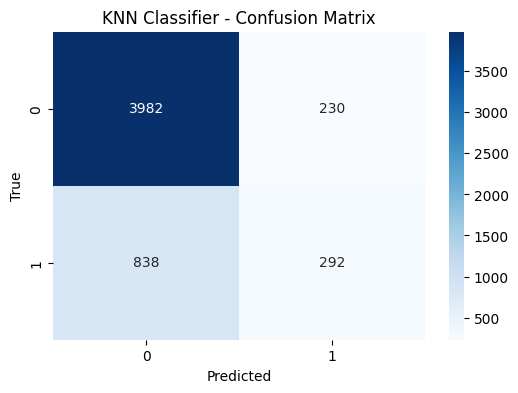

Train F1 Score (Micro) for KNN Classifier is : 1.0
Test F1 Score (Micro) for KNN Classifier is : 0.8000748783227256
The Roc_Auc score for kNN Classifier is : 0.6995481725201489


In [68]:
# Predictions for test and train sets
pred_3 = knn.predict(X_test)
train_pred_3 = knn.predict(X_train)

# Classification report for test set
print(classification_report(y_test, pred_3))

# Confusion matrix
cm = confusion_matrix(y_test, pred_3)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('KNN Classifier - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# F1 scores for training and testing datasets using micro average
train_score_3 = f1_score(y_train, train_pred_3, average='micro')
score_3 = f1_score(y_test, pred_3, average='micro')

# Print F1 scores
print('Train F1 Score (Micro) for KNN Classifier is : {}'.format(train_score_3))
print('Test F1 Score (Micro) for KNN Classifier is : {}'.format(score_3))


# Print roc auc scores
roc_auc = roc_auc_score(y_test, knn.predict_proba(X_test)[:, 1])
print('The Roc_Auc score for kNN Classifier is : {}'.format(roc_auc))


## **MODEL 4: Gradient Boosting Classifier**

In [69]:
# Setting up the gradient boosting classifier to go through the pipeline
gbc = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(learning_rate= 0.1, max_depth= 5, n_estimators= 200,
        random_state=42))
])

In [70]:
# fitting the model to the training data
gbc.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   IterativeImputer(max_iter=100,
                                                                                    random_state=42)),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['h1n1_concern',
                                                   'h1n1_knowledge',
                                                   'behavioral_antiviral_meds',
                                                   'behavioral_avoidance',
                                                   'behavioral_face_mask',
                                                   'behavioral_wash_hands',
                                                   'behavioral_large_gatherings',
                                                   'beha...
                                                   'census_msa']),
                                                 ('freq',
                                                  Pipeline(steps=[('freq_encoder',
                                                                   CountEncoder(combine_min_nan_groups=True,
                                                                                min_group_size=0.05,
                                                                                normalize=True)),
                                                                  ('freq_imputer',
                                                                   IterativeImputer(max_iter=100,
                                                                                    random_state=42))]),
                                                  ['hhs_geo_region',
                                                   'employment_industry',
                                                   'employment_occupation'])])),
                ('classifier',
                 GradientBoostingClassifier(max_depth=5, n_estimators=200,
                                            random_state=42))])

              precision    recall  f1-score   support

           0       0.88      0.94      0.91      4212
           1       0.71      0.51      0.59      1130

    accuracy                           0.85      5342
   macro avg       0.79      0.73      0.75      5342
weighted avg       0.84      0.85      0.84      5342



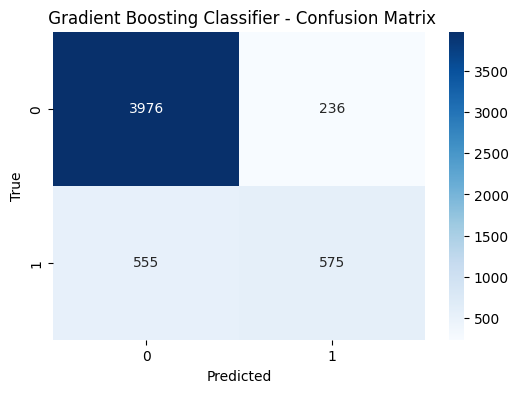

Train F1 Score (Micro) for Gradient Boosting Classifier is : 0.8917388251813714
Test F1 Score (Micro) for Gradient Boosting Classifier is : 0.8519281168101834
The Roc_Auc score for Gradient Boosting Classifier is : 0.8669036633638405


In [71]:
# Predictions for test and train sets
pred_4 = gbc.predict(X_test)
train_pred_4 = gbc.predict(X_train)

# Classification report for test set
print(classification_report(y_test, pred_4))

# Confusion matrix
cm = confusion_matrix(y_test, pred_4)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(' Gradient Boosting Classifier - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# F1 scores for training and testing datasets using micro average
train_score_4 = f1_score(y_train, train_pred_4, average='micro')
score_4 = f1_score(y_test, pred_4, average='micro')

# Print F1 scores
print('Train F1 Score (Micro) for Gradient Boosting Classifier is : {}'.format(train_score_4))
print('Test F1 Score (Micro) for Gradient Boosting Classifier is : {}'.format(score_4))


# Print roc auc scores
roc_auc = roc_auc_score(y_test, gbc.predict_proba(X_test)[:, 1])
print('The Roc_Auc score for Gradient Boosting Classifier is : {}'.format(roc_auc))

## **MODEL 6: XG Boosting Classifier**

In [72]:
# Setting up the XG Boosting model to go through the pipeline
xgb = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', xgboost.XGBClassifier(learning_rate= 1, max_depth= 2, n_estimators= 100, random_state=42))
])

In [73]:
# fitting the model to the training data
xgb.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   IterativeImputer(max_iter=100,
                                                                                    random_state=42)),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['h1n1_concern',
                                                   'h1n1_knowledge',
                                                   'behavioral_antiviral_meds',
                                                   'behavioral_avoidance',
                                                   'behavioral_face_mask',
                                                   'behavioral_wash_hands',
                                                   'behavioral_large_gatherings',
                                                   'beha...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=2, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=100, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

              precision    recall  f1-score   support

           0       0.88      0.95      0.91      4212
           1       0.72      0.52      0.60      1130

    accuracy                           0.85      5342
   macro avg       0.80      0.73      0.75      5342
weighted avg       0.84      0.85      0.84      5342



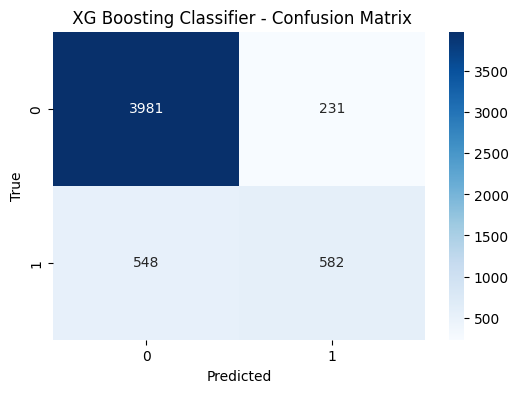

Train F1 Score (Micro) for XG Boosting Classifier is : 0.8635150947811842
Test F1 Score (Micro) for XG Boosting Classifier is : 0.8541744664919506
The Roc_Auc score for XG Boosting Classifier is : 0.8619786282765634


In [74]:
# Predictions for test and train sets
pred_5 = xgb.predict(X_test)
train_pred_5 = xgb.predict(X_train)

# Classification report for test set
print(classification_report(y_test, pred_5))

# Confusion matrix
cm = confusion_matrix(y_test, pred_5)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(' XG Boosting Classifier - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# F1 scores for training and testing datasets using micro average
train_score_5 = f1_score(y_train, train_pred_5, average='micro')
score_5 = f1_score(y_test, pred_5, average='micro')

# Print F1 scores
print('Train F1 Score (Micro) for XG Boosting Classifier is : {}'.format(train_score_5))
print('Test F1 Score (Micro) for XG Boosting Classifier is : {}'.format(score_5))


# Print roc auc scores
roc_auc = roc_auc_score(y_test, xgb.predict_proba(X_test)[:, 1])
print('The Roc_Auc score for XG Boosting Classifier is : {}'.format(roc_auc))

## **MODEL 6: Random Forest Classifier**

In [75]:
# Setting up the RandomForestClassifier to go through the pipeline
rfc = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier(class_weight= 'balanced', max_depth= 5, min_samples_leaf= 1,
                                          n_estimators= 200, random_state=42))
])

In [76]:
# fitting the model to the training data
rfc.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   IterativeImputer(max_iter=100,
                                                                                    random_state=42)),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['h1n1_concern',
                                                   'h1n1_knowledge',
                                                   'behavioral_antiviral_meds',
                                                   'behavioral_avoidance',
                                                   'behavioral_face_mask',
                                                   'behavioral_wash_hands',
                                                   'behavioral_large_gatherings',
                                                   'beha...
                                                  Pipeline(steps=[('freq_encoder',
                                                                   CountEncoder(combine_min_nan_groups=True,
                                                                                min_group_size=0.05,
                                                                                normalize=True)),
                                                                  ('freq_imputer',
                                                                   IterativeImputer(max_iter=100,
                                                                                    random_state=42))]),
                                                  ['hhs_geo_region',
                                                   'employment_industry',
                                                   'employment_occupation'])])),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced', max_depth=5,
                                        n_estimators=200, random_state=42))])

              precision    recall  f1-score   support

           0       0.92      0.81      0.86      4212
           1       0.51      0.74      0.61      1130

    accuracy                           0.80      5342
   macro avg       0.72      0.78      0.73      5342
weighted avg       0.83      0.80      0.81      5342



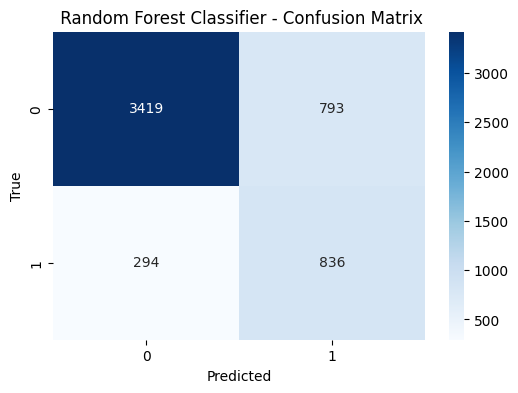

Train F1 Score (Micro) for Random Forest Classifier is : 0.7932131991575005
Test F1 Score (Micro) for Random Forest Classifier is : 0.796518157993261
The Roc_Auc score for Random Forest Classifier is : 0.8494911294321325


In [77]:
# Predictions for test and train sets
pred_6 = rfc.predict(X_test)
train_pred_6 = rfc.predict(X_train)

# Classification report for test set
print(classification_report(y_test, pred_6))

# Confusion matrix
cm = confusion_matrix(y_test, pred_6)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(' Random Forest Classifier - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# F1 scores for training and testing datasets using micro average
train_score_6 = f1_score(y_train, train_pred_6, average='micro')
score_6 = f1_score(y_test, pred_6, average='micro')

# Print F1 scores
print('Train F1 Score (Micro) for Random Forest Classifier is : {}'.format(train_score_6))
print('Test F1 Score (Micro) for Random Forest Classifier is : {}'.format(score_6))


# Print roc auc scores
roc_auc = roc_auc_score(y_test, rfc.predict_proba(X_test)[:, 1])
print('The Roc_Auc score for Random Forest Classifier is : {}'.format(roc_auc))

## **Comparison of Model ROC Curves**

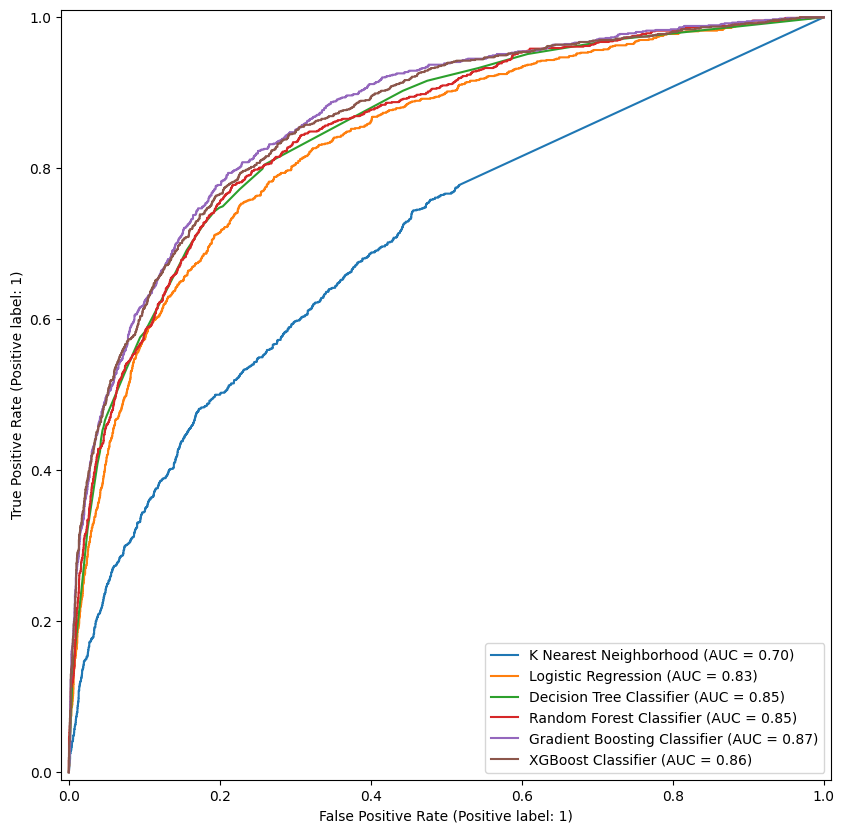

In [90]:
fig, ax = plt.subplots(figsize=(10, 10))
RocCurveDisplay.from_estimator(knn, X_test, y_test, name='K Nearest Neighborhood', ax=ax)
RocCurveDisplay.from_estimator(logreg, X_test, y_test, name='Logistic Regression', ax=ax)
RocCurveDisplay.from_estimator(dtc, X_test, y_test, name='Decision Tree Classifier', ax=ax)
RocCurveDisplay.from_estimator(rfc, X_test, y_test, name='Random Forest Classifier', ax=ax)
RocCurveDisplay.from_estimator(gbc, X_test, y_test, name='Gradient Boosting Classifier', ax=ax)
RocCurveDisplay.from_estimator(xgb, X_test, y_test, name='XGBoost Classifier', ax=ax)
plt.show()

In [93]:

# ROC AUC scores
roc_auc_dtc = roc_auc_score(y_test, dtc.predict_proba(X_test)[:, 1])
roc_auc_logreg = roc_auc_score(y_test, logreg.predict_proba(X_test)[:, 1])
roc_auc_knn = roc_auc_score(y_test, knn.predict_proba(X_test)[:, 1])
roc_auc_gbc = roc_auc_score(y_test, gbc.predict_proba(X_test)[:, 1])
roc_auc_xgb = roc_auc_score(y_test, xgb.predict_proba(X_test)[:, 1])
roc_auc_rfc = roc_auc_score(y_test, rfc.predict_proba(X_test)[:, 1])

# F1 scores
train_score_1 = f1_score(y_train, train_pred_1, average='micro')
score_1 = f1_score(y_test, pred_1, average='micro')

train_score_2 = f1_score(y_train, train_pred_2, average='micro')
score_2 = f1_score(y_test, pred_2, average='micro')

train_score_3 = f1_score(y_train, train_pred_3, average='micro')
score_3 = f1_score(y_test, pred_3, average='micro')

train_score_4 = f1_score(y_train, train_pred_4, average='micro')
score_4 = f1_score(y_test, pred_4, average='micro')

train_score_5 = f1_score(y_train, train_pred_5, average='micro')
score_5 = f1_score(y_test, pred_5, average='micro')

train_score_6 = f1_score(y_train, train_pred_6, average='micro')
score_6 = f1_score(y_test, pred_6, average='micro')

# Create a DataFrame with ROC AUC and F1 scores
metrics_df = pd.DataFrame({
    'Model': ['Decision Tree', 'Logistic Regression', 'KNN', 'Gradient Boosting', 'XGBoost', 'Random Forest'],
    'ROC AUC': [roc_auc_dtc, roc_auc_logreg, roc_auc_knn, roc_auc_gbc, roc_auc_xgb, roc_auc_rfc],
    'Train F1 Score': [train_score_1, train_score_2, train_score_3, train_score_4, train_score_5, train_score_6],
    'Test F1 Score': [score_1, score_2, score_3, score_4, score_5, score_6]
})




In [94]:
# Display the DataFrame
metrics_df

Model   ROC AUC  Train F1 Score  Test F1 Score
0        Decision Tree  0.848305        0.792698       0.793897
1  Logistic Regression  0.832877        0.775755       0.776675
2                  KNN  0.699548        1.000000       0.800075
3    Gradient Boosting  0.866904        0.891739       0.851928
4              XGBoost  0.861979        0.863515       0.854174
5        Random Forest  0.849491        0.793213       0.796518

**The Gradient Boosting Classifier is the best model for predicting H1N1 where high scores for both F1 Score 89.17% and ROC AUC 86.69% where it is performing really well.**

## **Final Model: Gradient Boosting Classifier**

In [79]:
final_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', GradientBoostingClassifier(learning_rate =0.1, n_estimators=200,
                                              max_depth=5,
                                              random_state=42))
])


In [80]:
output_final_model = final_model.fit(X_train, y_train)

              precision    recall  f1-score   support

           0       0.88      0.94      0.91      4212
           1       0.71      0.51      0.59      1130

    accuracy                           0.85      5342
   macro avg       0.79      0.73      0.75      5342
weighted avg       0.84      0.85      0.84      5342



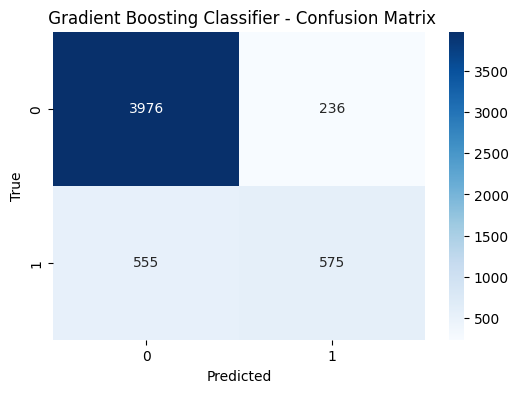

Train F1 Score (Micro) for Gradient Boosting Classifier is : 0.8917388251813714
Test F1 Score (Micro) for Gradient Boosting Classifier is : 0.8519281168101834
The Roc_Auc score for Gradient Boosting Classifier is : 0.8669036633638405


In [81]:
# Predictions for test and train sets
final_pred = final_model.predict(X_test)
train_final_pred = final_model.predict(X_train)

# Classification report for test set
print(classification_report(y_test, final_pred))

# Confusion matrix
cm = confusion_matrix(y_test, final_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(' Gradient Boosting Classifier - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# F1 scores for training and testing datasets using micro average
train_score = f1_score(y_train, train_final_pred, average='micro')
score = f1_score(y_test, final_pred, average='micro')

# Print F1 scores
print('Train F1 Score (Micro) for Gradient Boosting Classifier is : {}'.format(train_score))
print('Test F1 Score (Micro) for Gradient Boosting Classifier is : {}'.format(score))


# Print roc auc scores
roc_auc = roc_auc_score(y_test, final_model.predict_proba(X_test)[:, 1])
print('The Roc_Auc score for Gradient Boosting Classifier is : {}'.format(roc_auc))

## **Feature Importance**

In [82]:
# Accessing the features of the preproccesor
final_model['preprocessor']

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('num_imputer',
                                                  IterativeImputer(max_iter=100,
                                                                   random_state=42)),
                                                 ('minmaxscaler',
                                                  MinMaxScaler())]),
                                 ['h1n1_concern', 'h1n1_knowledge',
                                  'behavioral_antiviral_meds',
                                  'behavioral_avoidance',
                                  'behavioral_face_mask',
                                  'behavioral_wash_hands',
                                  'behavioral_large_gatherings',
                                  'behavioral_outside_home',
                                  'behavioral...
                                 ['age_group', 'education', 'race', 'sex',
                                  'income_poverty', 'marital_status',
                                  'rent_or_own', 'employment_status',
                                  'census_msa']),
                                ('freq',
                                 Pipeline(steps=[('freq_encoder',
                                                  CountEncoder(combine_min_nan_groups=True,
                                                               min_group_size=0.05,
                                                               normalize=True)),
                                                 ('freq_imputer',
                                                  IterativeImputer(max_iter=100,
                                                                   random_state=42))]),
                                 ['hhs_geo_region', 'employment_industry',
                                  'employment_occupation'])])

In [83]:
# We are looking at the shape of the preprocessor transformation.
final_model['preprocessor'].fit_transform(X_train).shape

(21365, 59)

In [84]:
# We are looking at the transformed data
pd.DataFrame(final_model['preprocessor'].fit_transform(X_train)).head()

0    1         2         3         4         5    6    7    8   \
0  0.666667  0.5  0.014625  0.967488  0.043917  0.894587  0.0  1.0  1.0   
1  0.666667  0.5  1.000000  0.967488  1.000000  0.894587  1.0  1.0  1.0   
2  0.000000  0.5  0.014625  0.000000  0.043917  0.894587  0.0  1.0  0.0   
3  0.333333  0.5  0.014625  0.000000  0.043917  0.000000  0.0  0.0  0.0   
4  0.333333  0.0  0.014625  0.000000  0.043917  0.894587  0.0  0.0  0.0   

         9         10   11   12       13        14    15        16    17  \
0  0.133733  0.134134  1.0  0.0  0.08447  0.000000  1.00  0.759586  0.25   
1  0.133733  0.134134  0.0  0.0  0.08447  0.684270  1.00  0.759586  0.75   
2  0.133733  0.134134  0.0  0.0  0.08447  0.912059  0.00  0.278757  0.00   
3  0.133733  0.134134  0.0  0.0  0.08447  0.912059  0.75  0.278757  0.00   
4  0.133733  0.134134  0.0  0.0  0.08447  0.912059  0.50  0.278757  1.00   

     18    19    20        21        22   23   24   25   26   27   28   29  \
0  0.75  0.75  0.25  0.333333  0.000000  0.0  0.0  1.0  0.0  0.0  0.0  0.0   
1  1.00  0.75  0.75  0.000000  0.000000  0.0  0.0  1.0  0.0  0.0  0.0  0.0   
2  0.00  0.75  0.00  0.333333  0.333333  0.0  1.0  0.0  0.0  0.0  0.0  0.0   
3  0.75  0.25  0.25  0.000000  0.000000  0.0  0.0  1.0  0.0  0.0  0.0  0.0   
4  1.00  0.25  1.00  0.333333  0.333333  0.0  0.0  0.0  0.0  1.0  0.0  0.0   

    30   31   32   33   34   35   36   37   38   39   40   41   42   43   44  \
0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0   
1  1.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0  1.0   
2  0.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0  1.0  1.0  0.0   
3  1.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0   
4  1.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0   

    45   46   47   48   49   50   51   52   53   54   55        56        57  \
0  0.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0  0.159420  0.497402   
1  0.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.159420  0.066791   
2  0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.117061  0.341774   
3  0.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0  0.105032  0.341774   
4  0.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  0.082659  0.497402   

         58  
0  0.502504  
1  0.374865  
2  0.065809  
3  0.374865  
4  0.502504

In [85]:
# We are looking at the feature importances coming out of. the gradient boosting classifier
final_model['classifier'].feature_importances_

array([0.00920832, 0.01034873, 0.00436439, 0.00426305, 0.00452334,
       0.00295396, 0.0030555 , 0.00316092, 0.00173822, 0.32207698,
       0.02142356, 0.00662465, 0.0086446 , 0.04280848, 0.16741034,
       0.09866239, 0.10389704, 0.01410622, 0.01498698, 0.02672654,
       0.0123885 , 0.00706513, 0.0060407 , 0.00392852, 0.00114876,
       0.00140233, 0.00332274, 0.00583734, 0.0015912 , 0.00558423,
       0.00414725, 0.00125023, 0.00234948, 0.00416288, 0.00233061,
       0.00082759, 0.00356564, 0.00264828, 0.00245693, 0.00171146,
       0.00203881, 0.0023797 , 0.00177598, 0.00195623, 0.00228479,
       0.00088566, 0.00096565, 0.00329588, 0.00172087, 0.00092107,
       0.00152043, 0.00160376, 0.00136264, 0.00315399, 0.00226275,
       0.00331672, 0.01212946, 0.00851764, 0.00316395])

In [86]:
# These are ohe_transformed columns!
ohe_cols_transformed = final_model['preprocessor'].transformers_[1][1]['ohe_encoder'].get_feature_names_out(ohe_cols)
ohe_cols_transformed


array(['age_group_18 - 34 Years', 'age_group_35 - 44 Years',
       'age_group_45 - 54 Years', 'age_group_55 - 64 Years',
       'age_group_65+ Years', 'education_12 Years',
       'education_< 12 Years', 'education_College Graduate',
       'education_Some College', 'education_Unknown', 'race_Black',
       'race_Hispanic', 'race_Other or Multiple', 'race_White',
       'sex_Female', 'sex_Male',
       'income_poverty_<= $75,000, Above Poverty',
       'income_poverty_> $75,000', 'income_poverty_Below Poverty',
       'income_poverty_Unknown', 'marital_status_Married',
       'marital_status_Not Married', 'marital_status_Unknown',
       'rent_or_own_Own', 'rent_or_own_Rent', 'rent_or_own_Unknown',
       'employment_status_Employed',
       'employment_status_Not in Labor Force',
       'employment_status_Unemployed', 'employment_status_Unknown',
       'census_msa_MSA, Not Principle  City',
       'census_msa_MSA, Principle City', 'census_msa_Non-MSA'],
      dtype=object)

In [87]:
# Name of the numerical columns
num_cols

['h1n1_concern',
 'h1n1_knowledge',
 'behavioral_antiviral_meds',
 'behavioral_avoidance',
 'behavioral_face_mask',
 'behavioral_wash_hands',
 'behavioral_large_gatherings',
 'behavioral_outside_home',
 'behavioral_touch_face',
 'doctor_recc_h1n1',
 'doctor_recc_seasonal',
 'chronic_med_condition',
 'child_under_6_months',
 'health_worker',
 'health_insurance',
 'opinion_h1n1_vacc_effective',
 'opinion_h1n1_risk',
 'opinion_h1n1_sick_from_vacc',
 'opinion_seas_vacc_effective',
 'opinion_seas_risk',
 'opinion_seas_sick_from_vacc',
 'household_adults',
 'household_children']

In [88]:
# Putting all columns together
final_cols = [*num_cols, *ohe_cols_transformed, *freq_cols]
final_cols

['h1n1_concern',
 'h1n1_knowledge',
 'behavioral_antiviral_meds',
 'behavioral_avoidance',
 'behavioral_face_mask',
 'behavioral_wash_hands',
 'behavioral_large_gatherings',
 'behavioral_outside_home',
 'behavioral_touch_face',
 'doctor_recc_h1n1',
 'doctor_recc_seasonal',
 'chronic_med_condition',
 'child_under_6_months',
 'health_worker',
 'health_insurance',
 'opinion_h1n1_vacc_effective',
 'opinion_h1n1_risk',
 'opinion_h1n1_sick_from_vacc',
 'opinion_seas_vacc_effective',
 'opinion_seas_risk',
 'opinion_seas_sick_from_vacc',
 'household_adults',
 'household_children',
 'age_group_18 - 34 Years',
 'age_group_35 - 44 Years',
 'age_group_45 - 54 Years',
 'age_group_55 - 64 Years',
 'age_group_65+ Years',
 'education_12 Years',
 'education_< 12 Years',
 'education_College Graduate',
 'education_Some College',
 'education_Unknown',
 'race_Black',
 'race_Hispanic',
 'race_Other or Multiple',
 'race_White',
 'sex_Female',
 'sex_Male',
 'income_poverty_<= $75,000, Above Poverty',
 'income

In [89]:
# Name of the frequency columns
freq_cols

['hhs_geo_region', 'employment_industry', 'employment_occupation']

In [ ]:
# Put together the final cols and the feature importances
# Then sort them by feature importances
import pandas as pd

# Create a dictionary where the feature names are the keys and their importance values are the values
feature_importance_dict = dict(zip(final_cols, final_model['classifier'].feature_importances_))

# Convert the dictionary to a DataFrame and sort by the importance values
feature_importance_df = pd.DataFrame.from_dict(feature_importance_dict, orient='index', columns=['Importance'])
feature_importance_df.sort_values(by='Importance', ascending=False, inplace=True)

# Display the result
feature_importance_df


Importance
doctor_recc_h1n1                            0.322077
health_insurance                            0.167410
opinion_h1n1_risk                           0.103897
opinion_h1n1_vacc_effective                 0.098662
health_worker                               0.042808
opinion_seas_risk                           0.026727
doctor_recc_seasonal                        0.021424
opinion_seas_vacc_effective                 0.014987
opinion_h1n1_sick_from_vacc                 0.014106
opinion_seas_sick_from_vacc                 0.012388
hhs_geo_region                              0.012129
h1n1_knowledge                              0.010349
h1n1_concern                                0.009208
child_under_6_months                        0.008645
employment_industry                         0.008518
household_adults                            0.007065
chronic_med_condition                       0.006625
household_children                          0.006041
age_group_65+ Years                         0.005837
education_< 12 Years                        0.005584
behavioral_face_mask                        0.004523
behavioral_antiviral_meds                   0.004364
behavioral_avoidance                        0.004263
race_Black                                  0.004163
education_College Graduate                  0.004147
age_group_18 - 34 Years                     0.003929
race_White                                  0.003566
age_group_55 - 64 Years                     0.003323
census_msa_Non-MSA                          0.003317
rent_or_own_Rent                            0.003296
employment_occupation                       0.003164
behavioral_outside_home                     0.003161
census_msa_MSA, Not Principle  City         0.003154
behavioral_large_gatherings                 0.003056
behavioral_wash_hands                       0.002954
sex_Female                                  0.002648
sex_Male                                    0.002457
income_poverty_Below Poverty                0.002380
education_Unknown                           0.002349
race_Hispanic                               0.002331
marital_status_Not Married                  0.002285
census_msa_MSA, Principle City              0.002263
income_poverty_> $75,000                    0.002039
marital_status_Married                      0.001956
income_poverty_Unknown                      0.001776
behavioral_touch_face                       0.001738
rent_or_own_Unknown                         0.001721
income_poverty_<= $75,000, Above Poverty    0.001711
employment_status_Unemployed                0.001604
education_12 Years                          0.001591
employment_status_Not in Labor Force        0.001520
age_group_45 - 54 Years                     0.001402
employment_status_Unknown                   0.001363
education_Some College                      0.001250
age_group_35 - 44 Years                     0.001149
rent_or_own_Own                             0.000966
employment_status_Employed                  0.000921
marital_status_Unknown                      0.000886
race_Other or Multiple                      0.000828


**The feature importance analysis shows that the most important factors for predicting vaccination uptake are the doctor's recommendation for the H1N1 vaccine, health insurance, and the perceived effectiveness of the vaccine. Other key features include individuals' perceptions of the risk of infection and whether they are health workers. These factors play a crucial role in vaccination decisions, guiding effective public health messaging.**

## **SEASONAL VACCINE**

### **Exploratory Data Analysis**
#### **Bi-Variate ANalysis**

In [127]:
df.columns

Index(['respondent_id', 'h1n1_concern', 'h1n1_knowledge',
       'behavioral_antiviral_meds', 'behavioral_avoidance',
       'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_h1n1', 'doctor_recc_seasonal',
       'chronic_med_condition', 'child_under_6_months', 'health_worker',
       'health_insurance', 'opinion_h1n1_vacc_effective', 'opinion_h1n1_risk',
       'opinion_h1n1_sick_from_vacc', 'opinion_seas_vacc_effective',
       'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'age_group',
       'education', 'race', 'sex', 'income_poverty', 'marital_status',
       'rent_or_own', 'employment_status', 'hhs_geo_region', 'census_msa',
       'household_adults', 'household_children', 'employment_industry',
       'employment_occupation', 'h1n1_vaccine', 'seasonal_vaccine'],
      dtype='object')

In [128]:
# Dropping the column which is related to H1N1 vaccine
df_seasonal_vaccine=df.drop(columns=['h1n1_concern','h1n1_knowledge', 'doctor_recc_h1n1', 'opinion_h1n1_vacc_effective','opinion_h1n1_risk','opinion_h1n1_sick_from_vacc','h1n1_vaccine'  ])

In [129]:
df_seasonal_vaccine.columns

Index(['respondent_id', 'behavioral_antiviral_meds', 'behavioral_avoidance',
       'behavioral_face_mask', 'behavioral_wash_hands',
       'behavioral_large_gatherings', 'behavioral_outside_home',
       'behavioral_touch_face', 'doctor_recc_seasonal',
       'chronic_med_condition', 'child_under_6_months', 'health_worker',
       'health_insurance', 'opinion_seas_vacc_effective', 'opinion_seas_risk',
       'opinion_seas_sick_from_vacc', 'age_group', 'education', 'race', 'sex',
       'income_poverty', 'marital_status', 'rent_or_own', 'employment_status',
       'hhs_geo_region', 'census_msa', 'household_adults',
       'household_children', 'employment_industry', 'employment_occupation',
       'seasonal_vaccine'],
      dtype='object')

In [130]:
def plot_count(x, data, y='seasonal_vaccine', ylabel='SEASONAL_VACCINE'):
    title = f"SEASONAL Vaccination VS {x.upper()}"  # Define the title inside the function
    xlabel = f"{x.upper()}"
    plt.figure(figsize=(12, 8))
    sns.countplot(x=x, data=data, hue=y)
    plt.title(title, fontsize=16)
    plt.xlabel(x.upper(), fontsize=12)
    plt.xticks(rotation=45)
    plt.ylabel(ylabel, fontsize=12)
    plt.show()

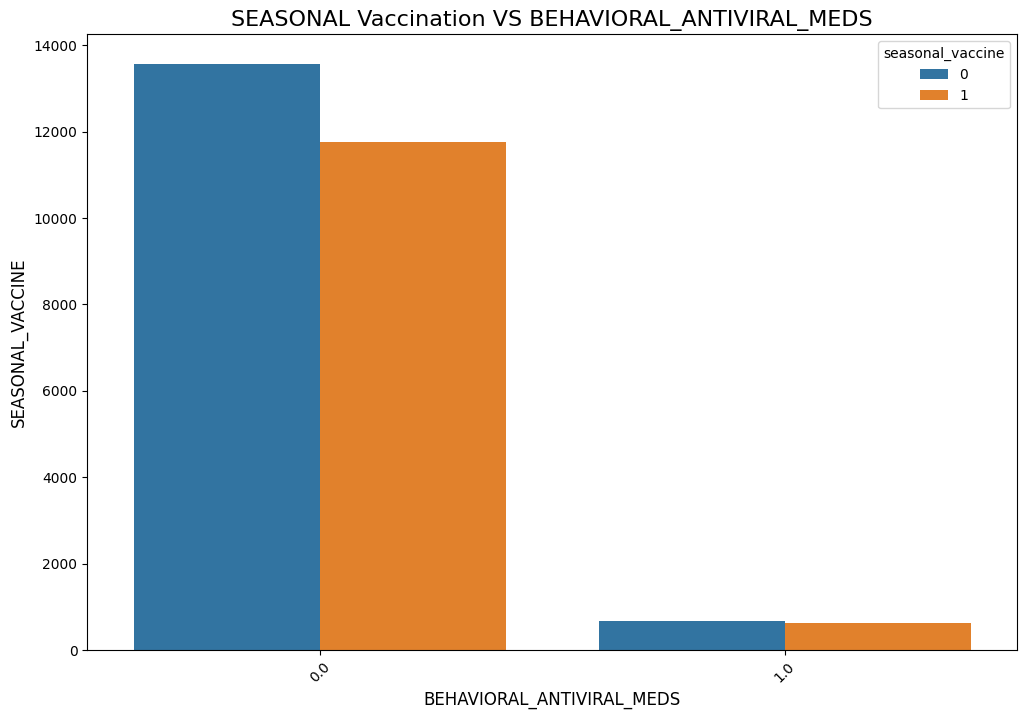

In [131]:
plot_count(x='behavioral_antiviral_meds', data=df_seasonal_vaccine)

**most individuals do not use antiviral medications (BEHAVIORAL_ANTIVIRAL_MEDS = 0.0), with far more unvaccinated than vaccinated. Among those likely to use antivirals (1.0), both vaccination and non-vaccination rates are very low. There is no strong link between antiviral use and seasonal vaccination.**

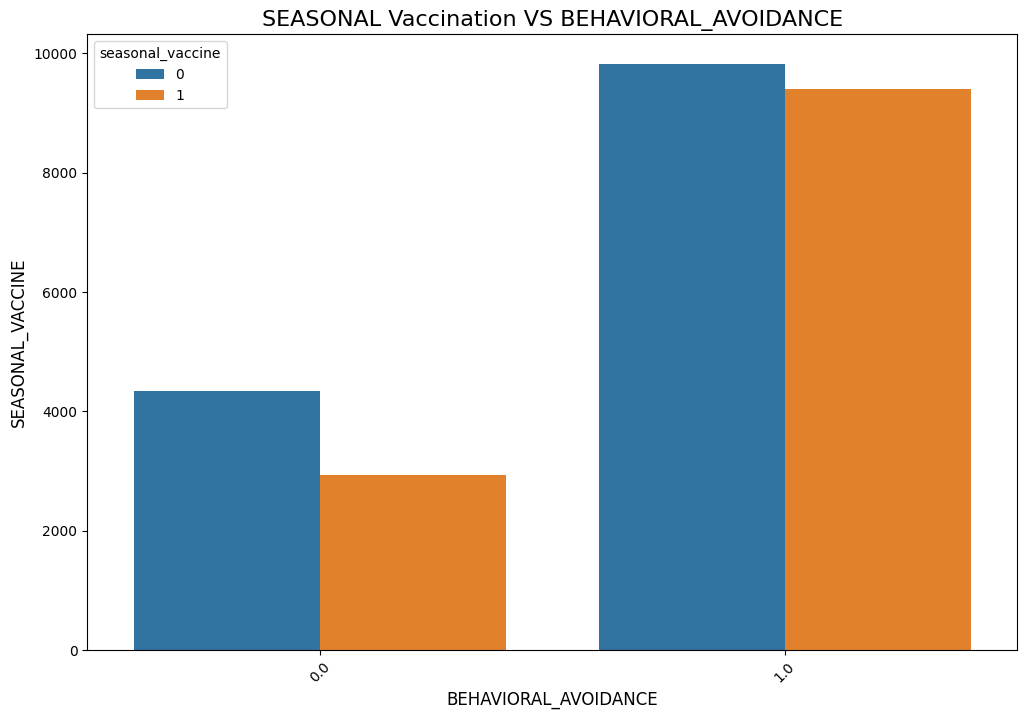

In [132]:
plot_count(x='behavioral_avoidance', data=df_seasonal_vaccine)

**People practicing avoidance behaviors (BEHAVIORAL_AVOIDANCE = 1.0) are slightly more likely to get vaccinated, but most remain unvaccinated regardless of avoidance behavior**

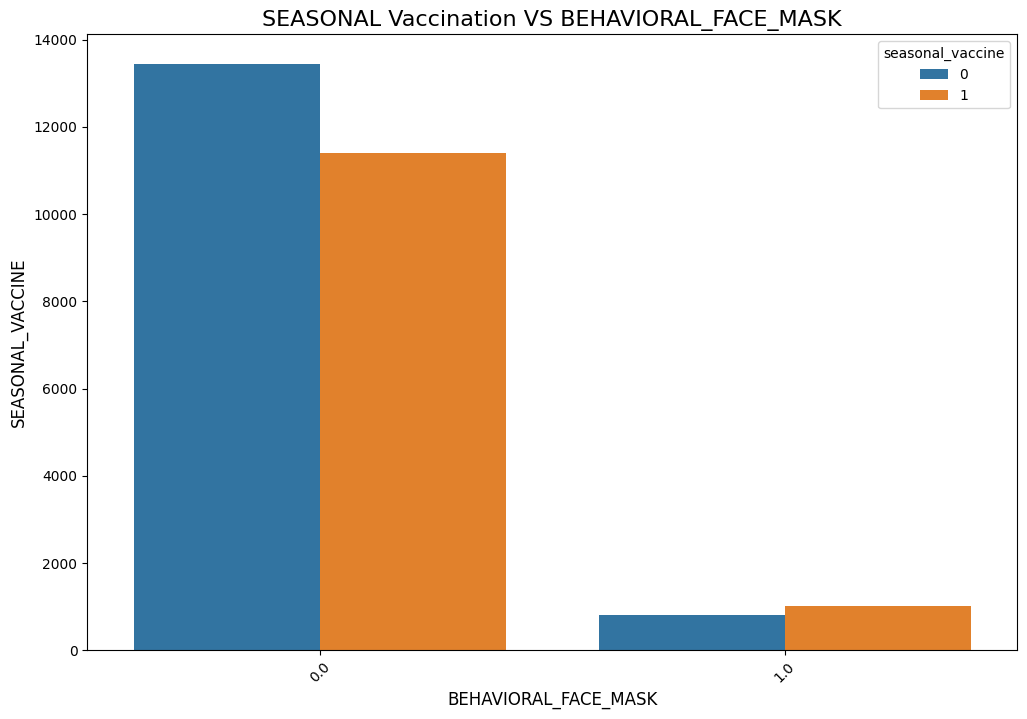

In [133]:
plot_count(x='behavioral_face_mask', data=df_seasonal_vaccine)

**The chart shows that most individuals, regardless of face mask usage, were not vaccinated for seasonal vaccine. However, those who wore face masks were slightly more likely to be vaccinated compared to those who did not. Overall, vaccination uptake remained low.**

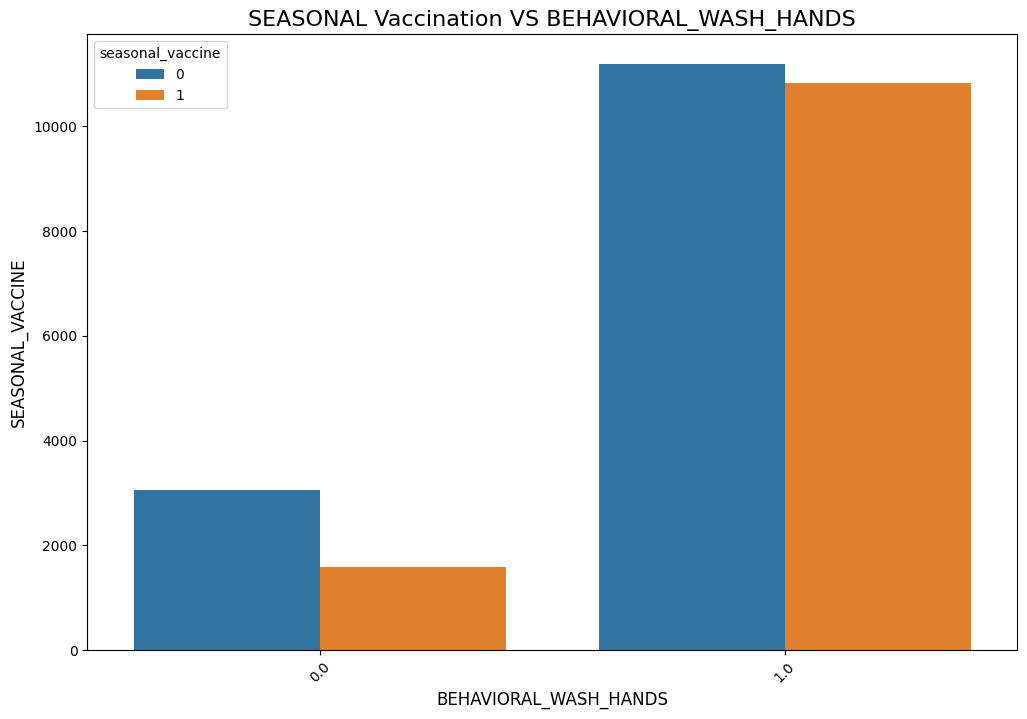

In [134]:
plot_count(x='behavioral_wash_hands', data=df_seasonal_vaccine)

**Frequent handwashing is associated with a higher likelihood of seasonal vaccination, though the majority of individuals—regardless of handwashing behavior—were not vaccinated. This suggests some connection between health-conscious behaviors and vaccination.**

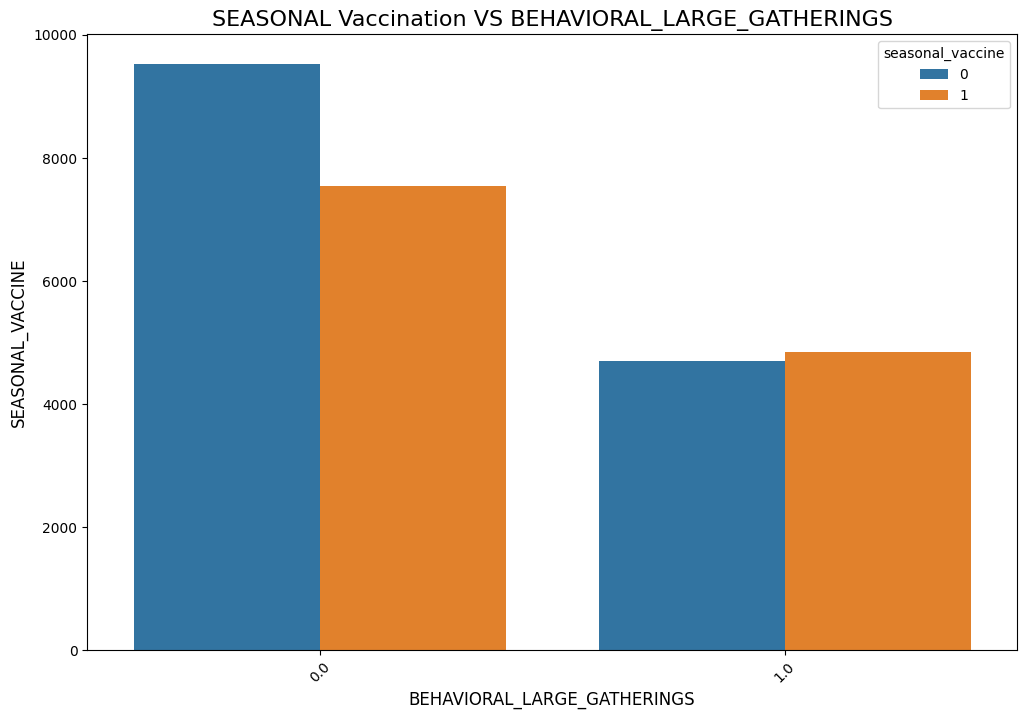

In [135]:
plot_count(x='behavioral_large_gatherings', data=df_seasonal_vaccine)

**most people, regardless of attending large gatherings or not, chose not to get the seasonal vaccine. The trend is consistent across both groups, suggesting that large gatherings did not significantly influence vaccination rates.**

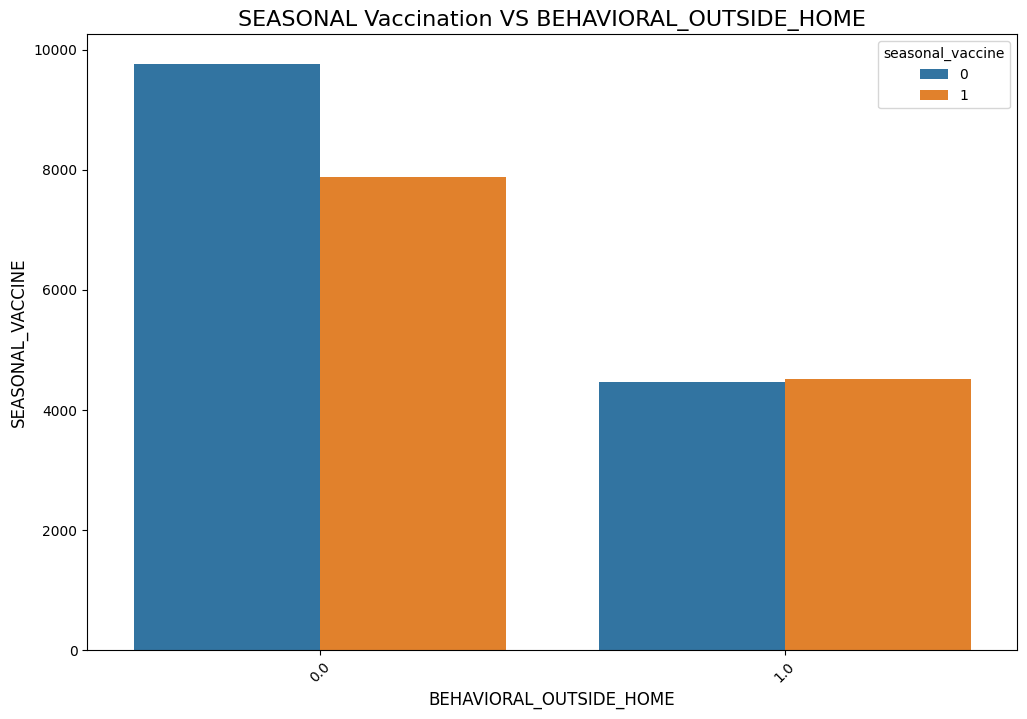

In [108]:
plot_count(x='behavioral_outside_home', data=df_seasonal_vaccine)

**The chart shows that most people, whether they stayed at home or went outside frequently, did not get the seasonal vaccine. The overall trend indicates that going outside did not significantly impact vaccination rates.**

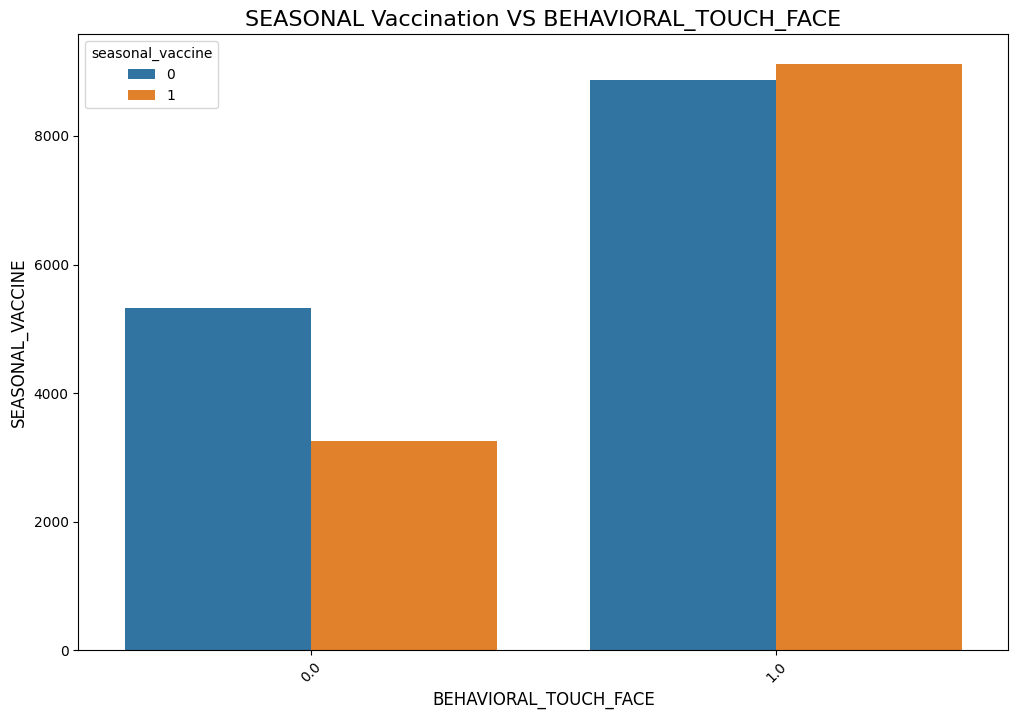

In [136]:
plot_count(x='behavioral_touch_face', data=df_seasonal_vaccine)

**Touching the face is not a major differentiating factor for seasonal vaccination decisions, as the trend of low vaccination remains consistent across both behaviors.**

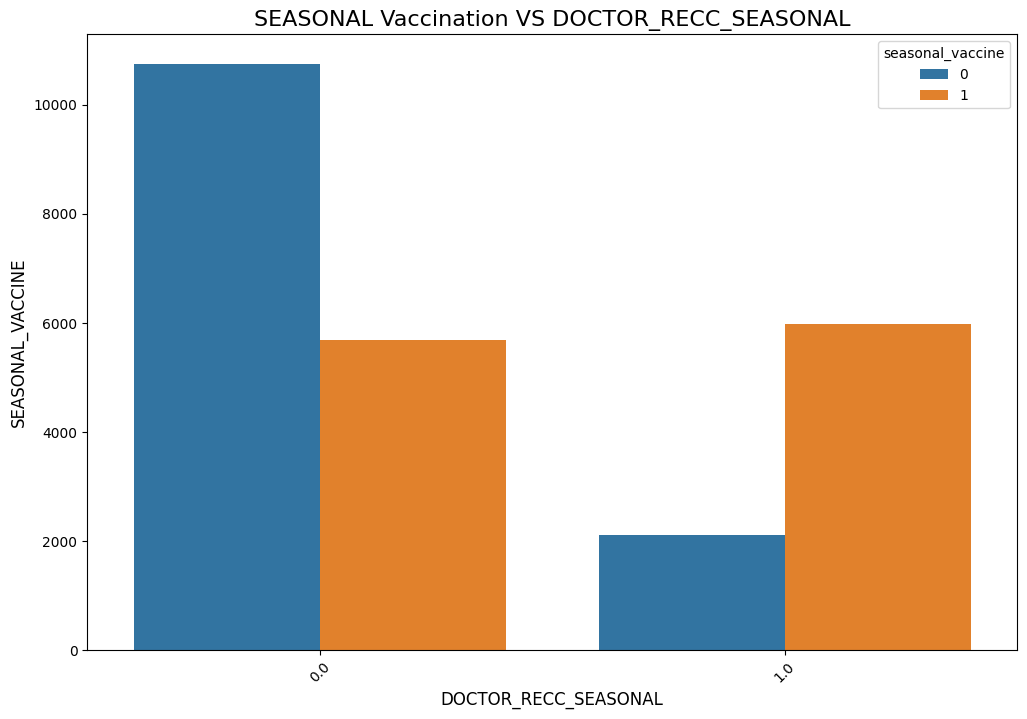

In [137]:
plot_count(x='doctor_recc_seasonal', data=df_seasonal_vaccine)

**Doctor recommendations strongly influence whether individuals take a seasonal vaccine. People are more likely to get vaccinated when a doctor recommends it.**

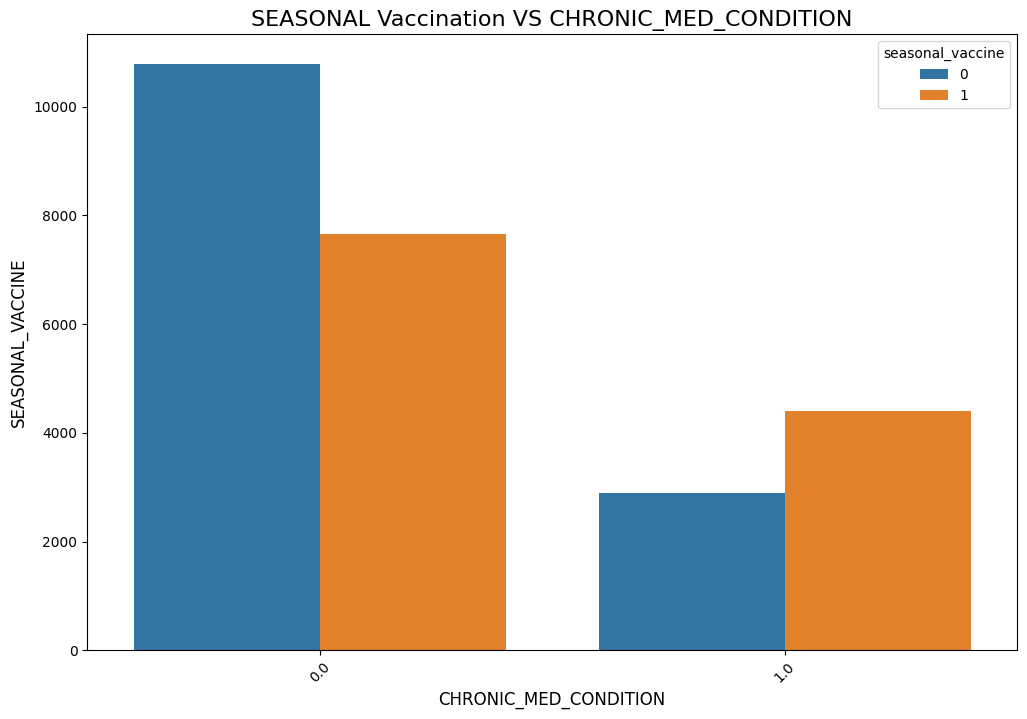

In [138]:
plot_count(x='chronic_med_condition', data=df_seasonal_vaccine)

**People with chronic medical conditions are more likely to get vaccinated, likely due to their higher risk of complications from seasonal vaccination.**

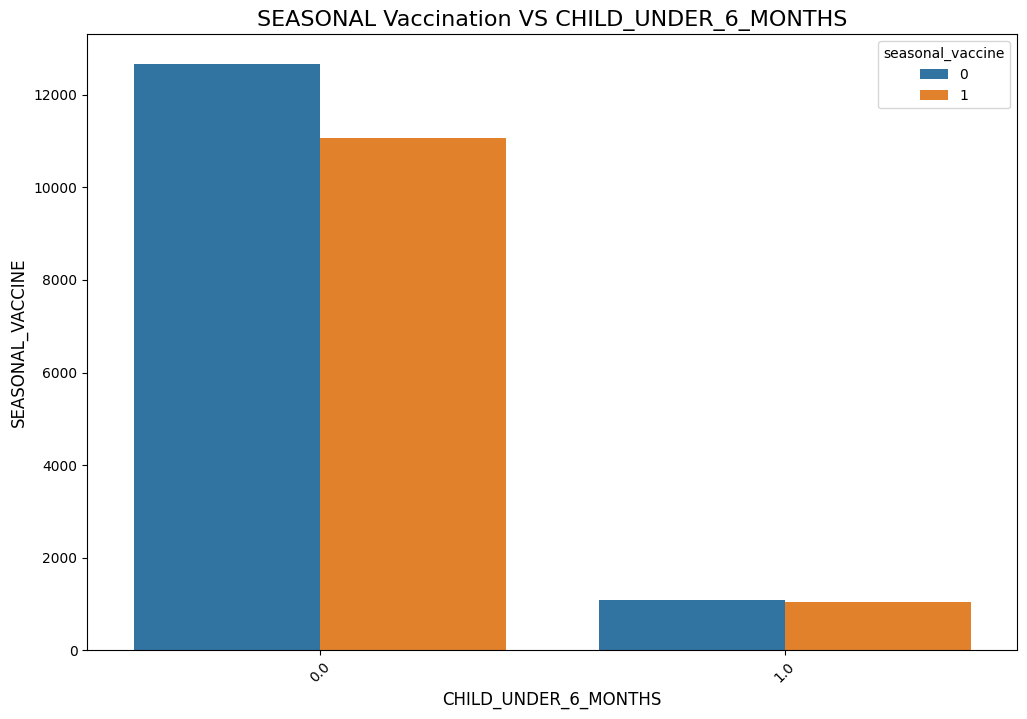

In [139]:
plot_count(x='child_under_6_months', data=df_seasonal_vaccine)

**Households with a child under 6 months are more likely to vaccinate against seaasonal vaccine, likely due to concerns for the infant's safety.**

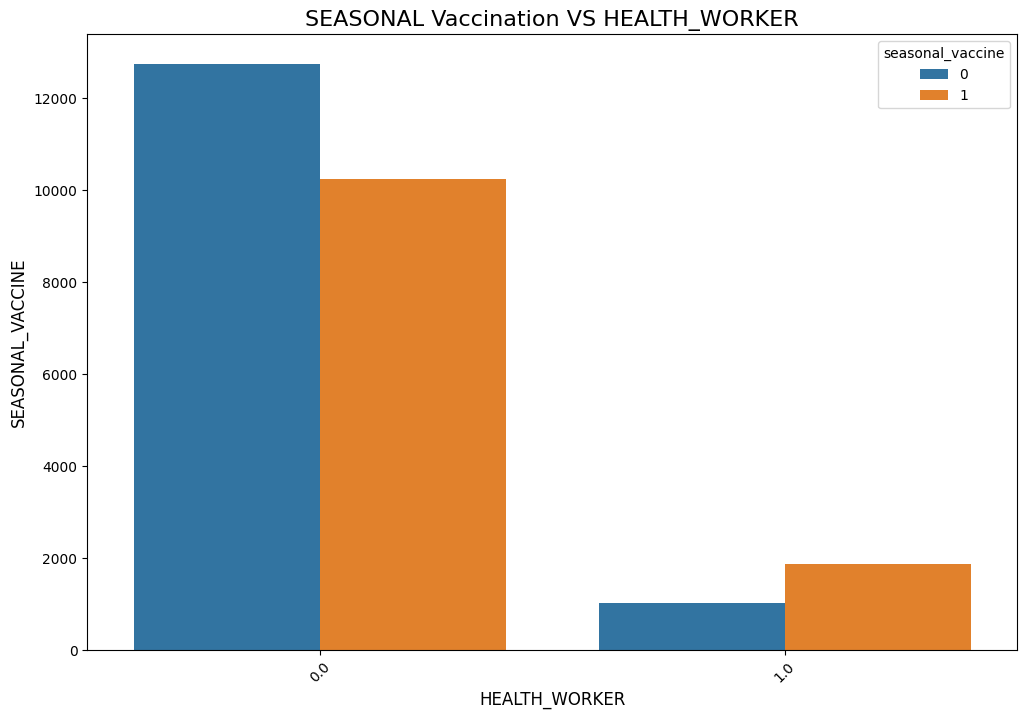

In [140]:
plot_count(x='health_worker', data=df_seasonal_vaccine)

**Being a health worker seems to correlate with a higher likelihood of receiving the seasonal vaccine compared to non-health workers. However, the total number of health workers in the dataset is significantly smaller than non-health workers.**

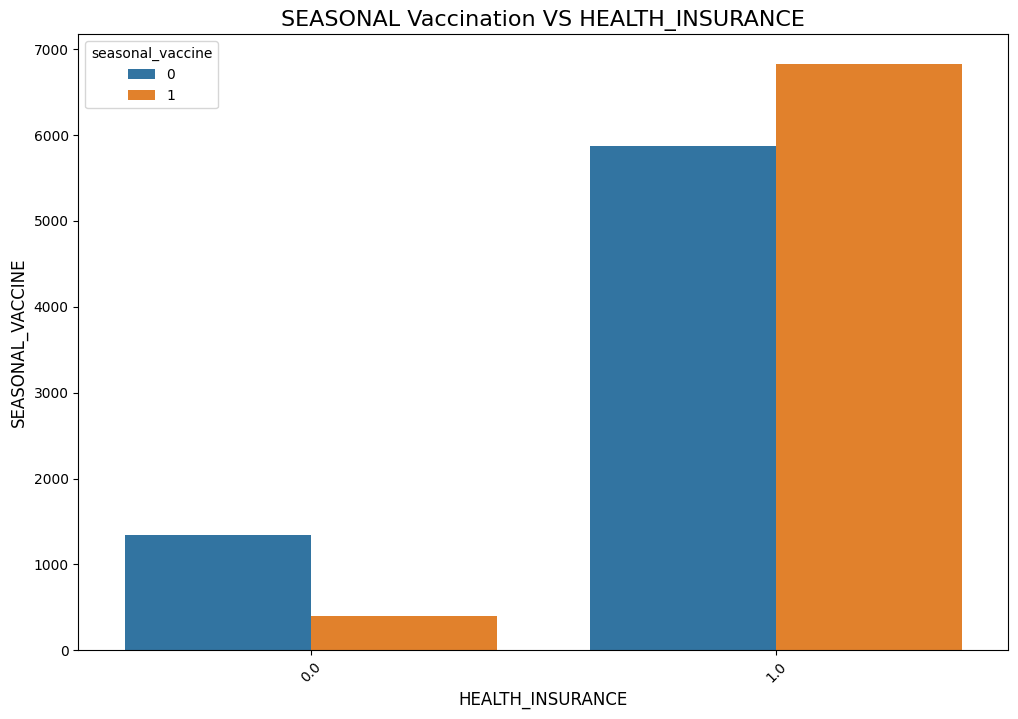

In [141]:
plot_count(x='health_insurance', data=df_seasonal_vaccine)

**Having health insurance appears to be associated with a higher likelihood of receiving the seasonal vaccine. However, even among those with health insurance, a considerable number remained unvaccinated.**

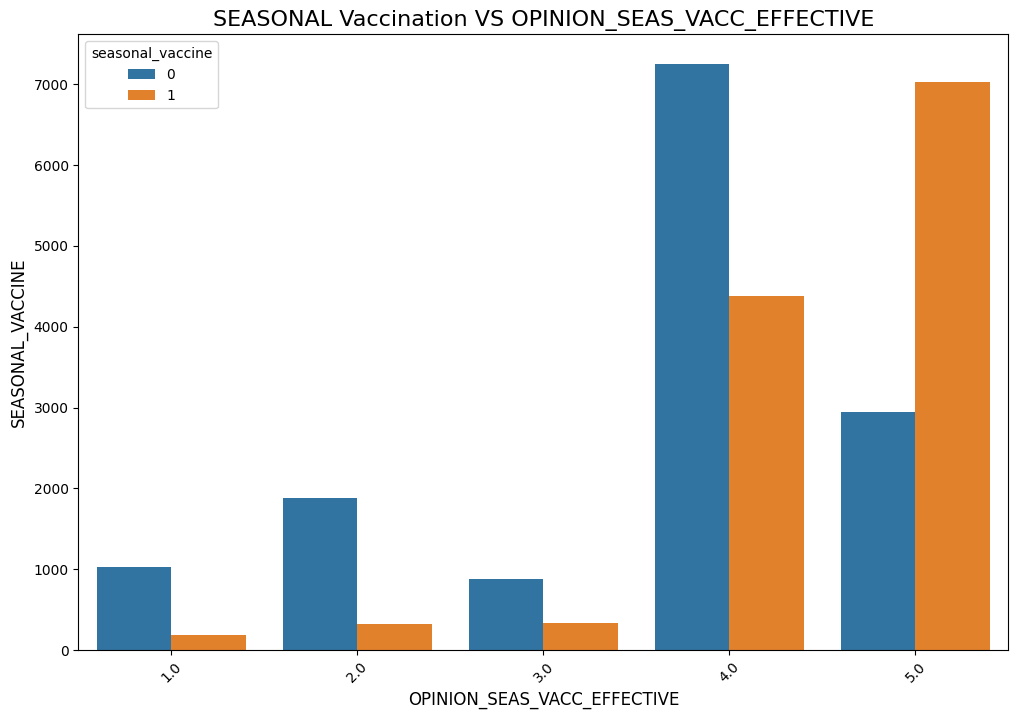

In [142]:
plot_count(x='opinion_seas_vacc_effective', data=df_seasonal_vaccine)


**As opinions on vaccine effectiveness improve, vaccination rates increase significantly, with high effectiveness opinions leading to more individuals getting vaccinated.**

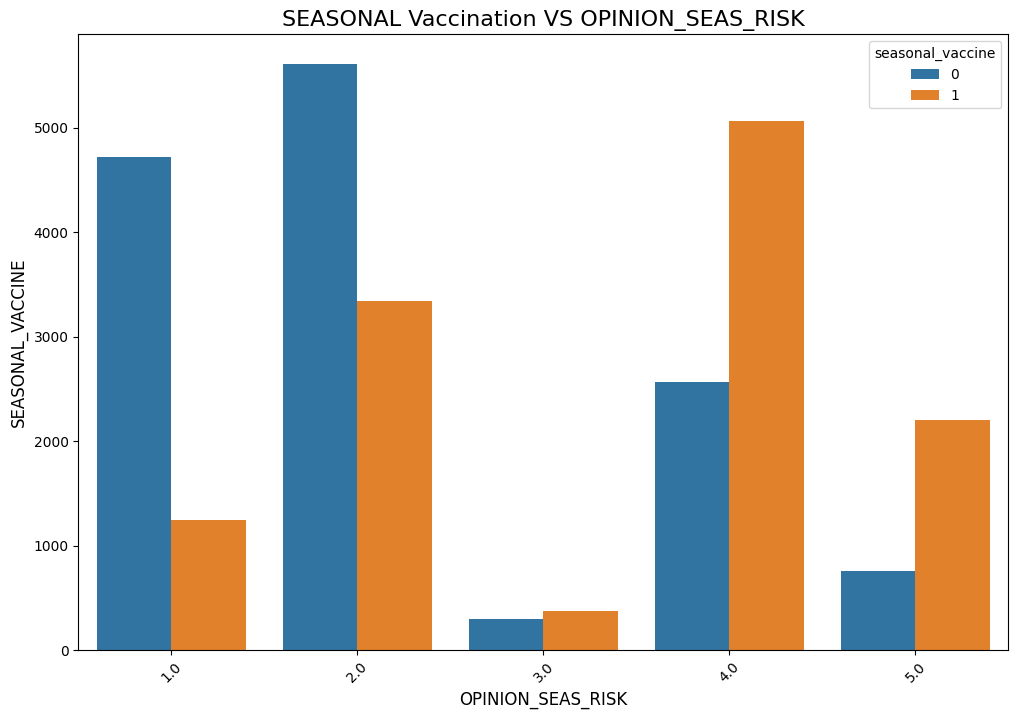

In [143]:
plot_count(x='opinion_seas_risk', data=df_seasonal_vaccine)

**People who perceive a higher risk of seasonal flu (values 4 and 5) are more likely to get vaccinated, while those with lower risk perceptions (values 1 and 2) are less likely. Risk perception plays a key role in vaccination decisions**

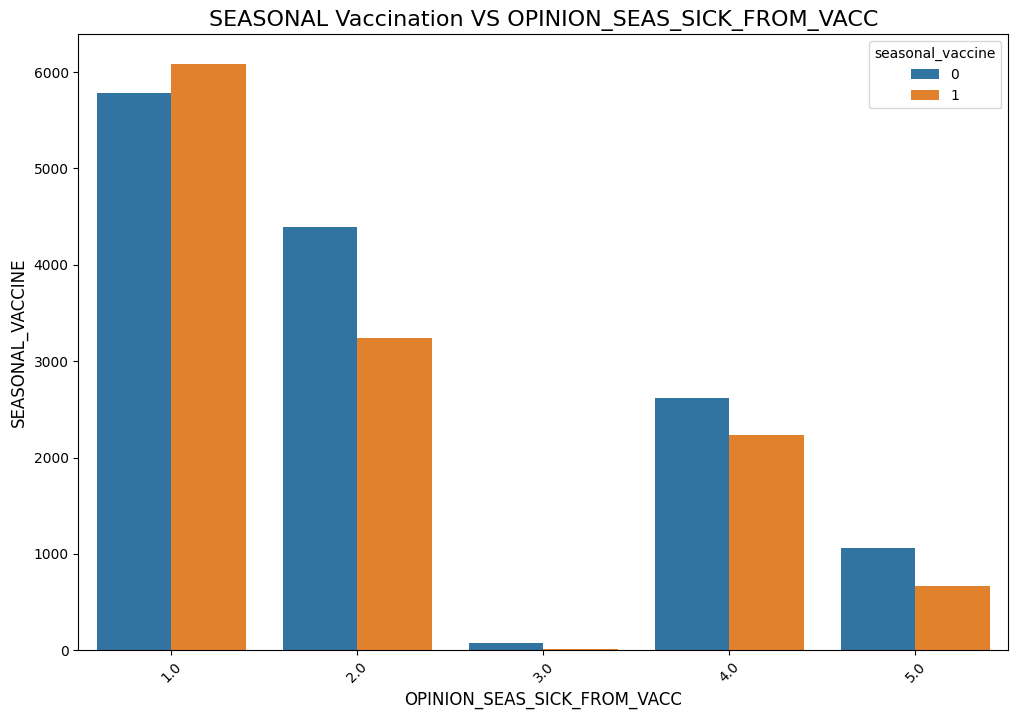

In [144]:
plot_count(x='opinion_seas_sick_from_vacc', data=df_seasonal_vaccine)


**People who believe the seasonal vaccine won’t make them sick are more likely to get vaccinated. On the other hand, those who think the vaccine might make them sick are less likely to take it. Fear of side effects plays an important role in vaccination decisions.**

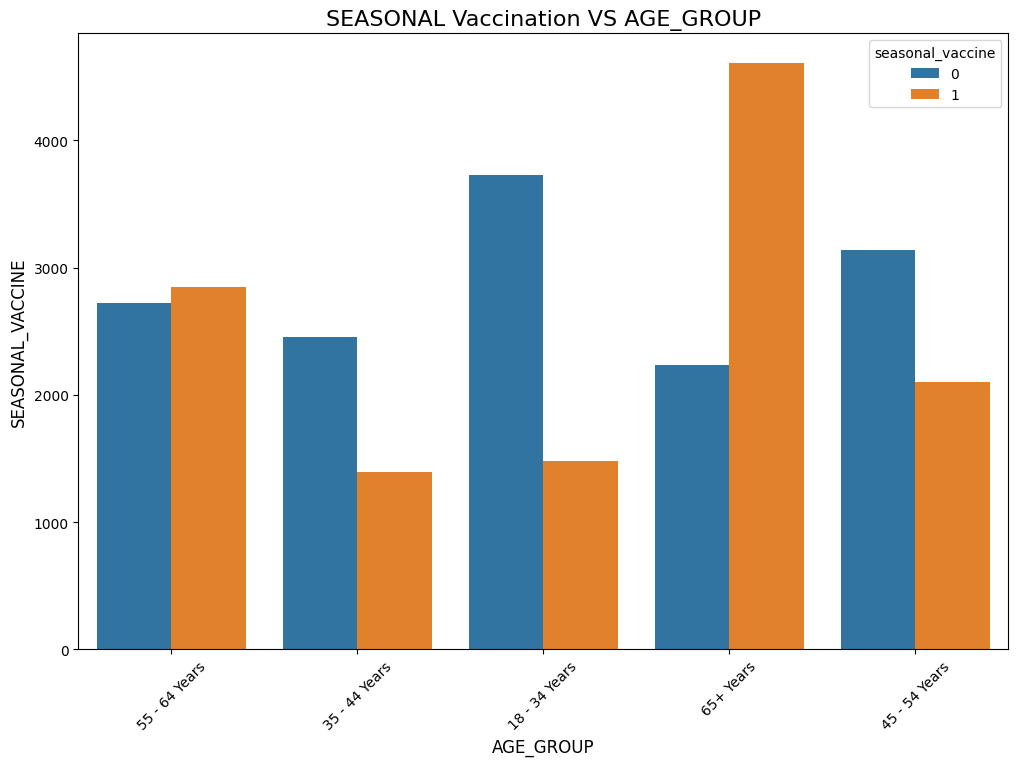

In [145]:
plot_count(x='age_group', data=df_seasonal_vaccine)

**Older people, especially those aged 65+ and 55–64, are more likely to get the seasonal vaccine. Younger people, like those aged 18–34 and 35–44, are less likely to get vaccinated. This shows that older adults take the vaccine more, possibly because they see it as more important for their health.**

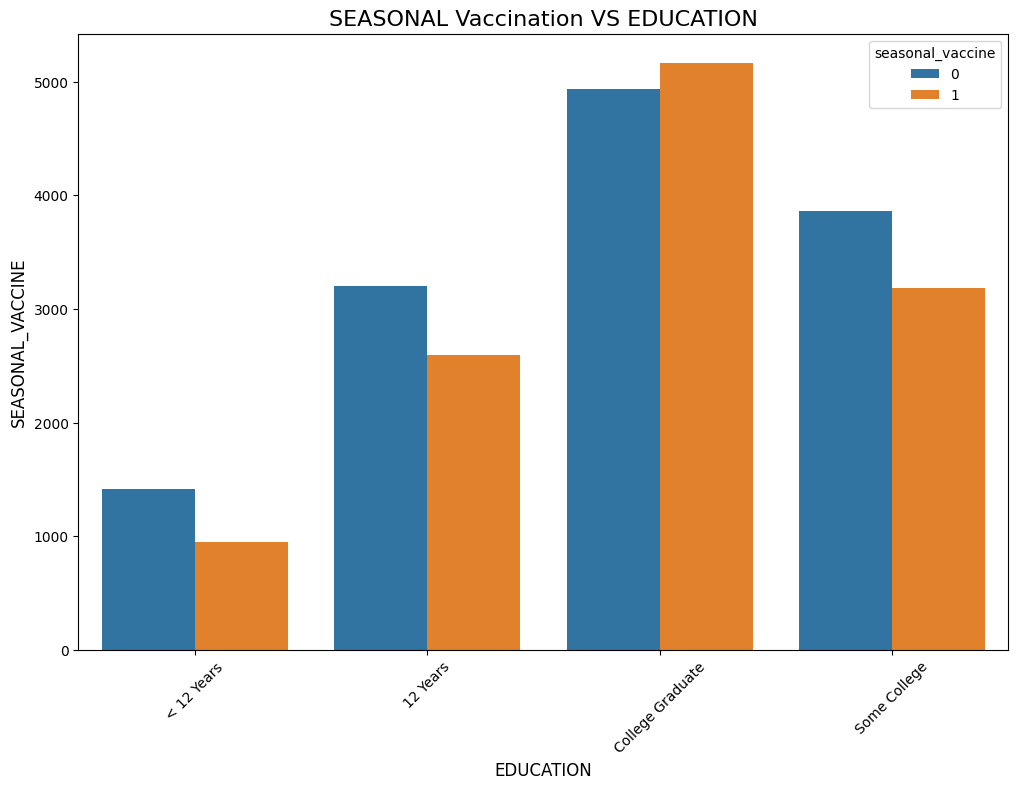

In [146]:
plot_count(x='education', data=df_seasonal_vaccine)

**People with higher education are more likely to get seasonal vaccines. College graduates have the highest vaccination rates, while those with less than 12 years of education have the lowest.**

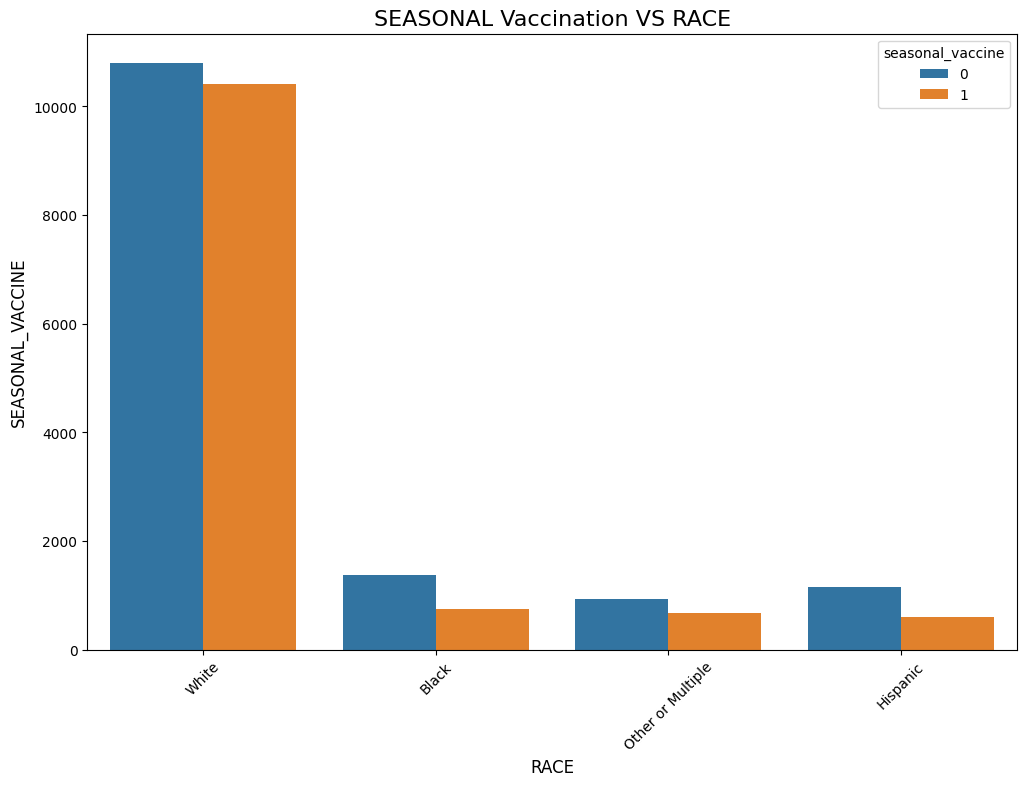

In [147]:
plot_count(x='race', data=df_seasonal_vaccine)

**The White group has the highest number of vaccinated individuals, while other groups (Black, Hispanic, and "Other or Multiple") have significantly lower vaccination rates. Unvaccinated individuals outnumber vaccinated ones across all racial groups.**

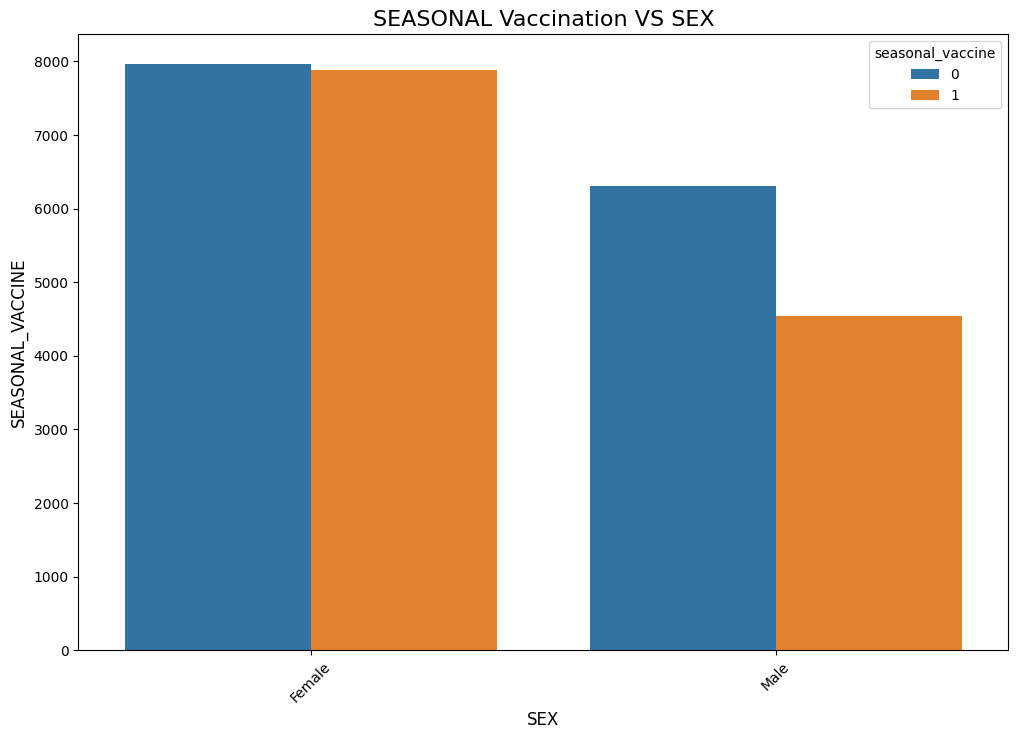

In [148]:
plot_count(x='sex', data=df_seasonal_vaccine)


**Females have slightly higher H1N1 vaccination rates than males, but the majority of individuals in both genders are unvaccinated**

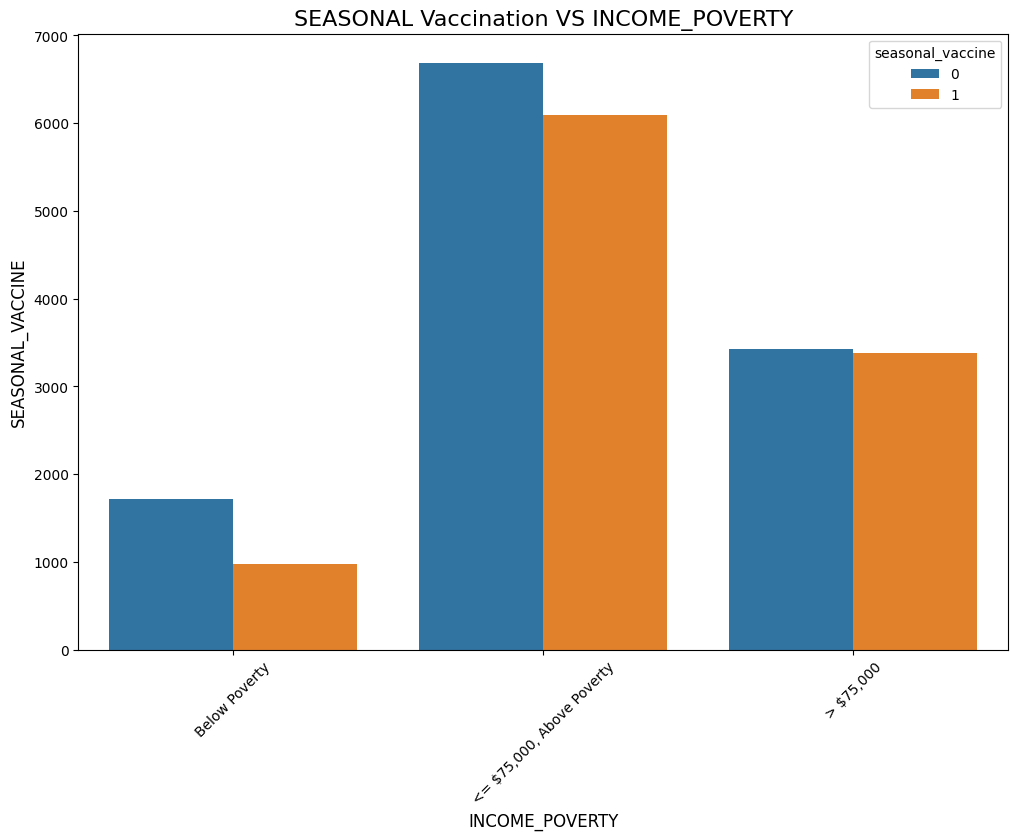

In [149]:
plot_count(x='income_poverty', data=df_seasonal_vaccine)

**Higher income levels correlate with higher seasonal vaccination rates, while individuals below the poverty line show the lowest vaccination uptake. Economic factors likely influence access and awareness.**

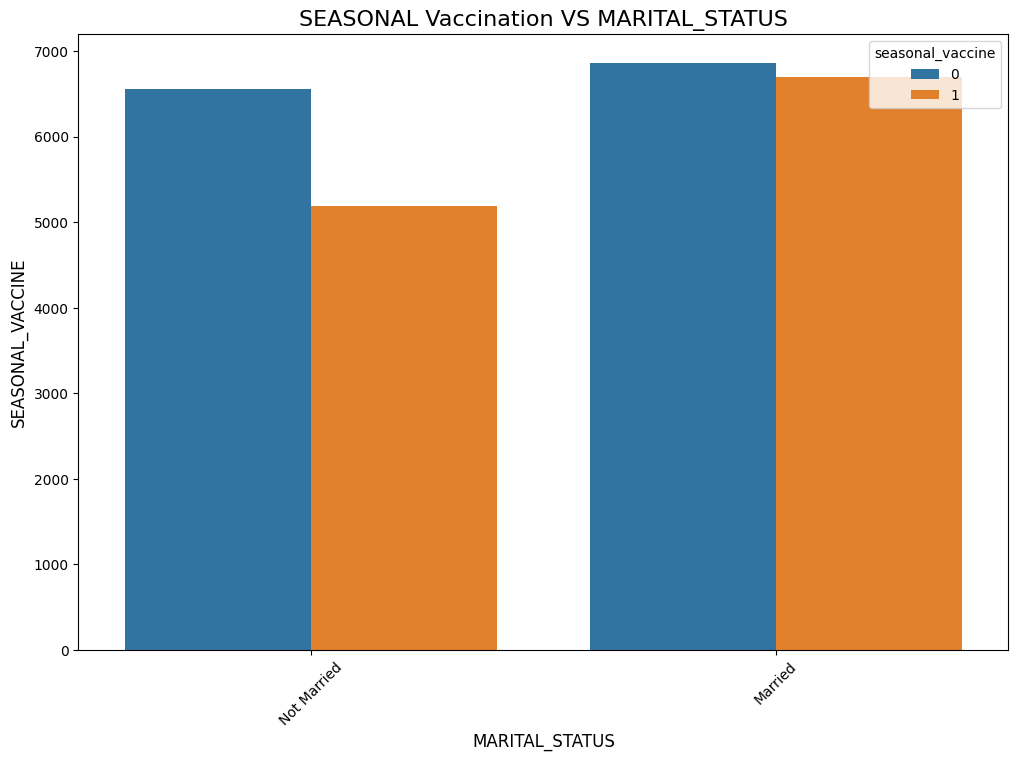

In [150]:
plot_count(x='marital_status', data=df_seasonal_vaccine)


**Married people are more likely to get vaccinated, while unmarried people tend to have lower vaccination rates.**

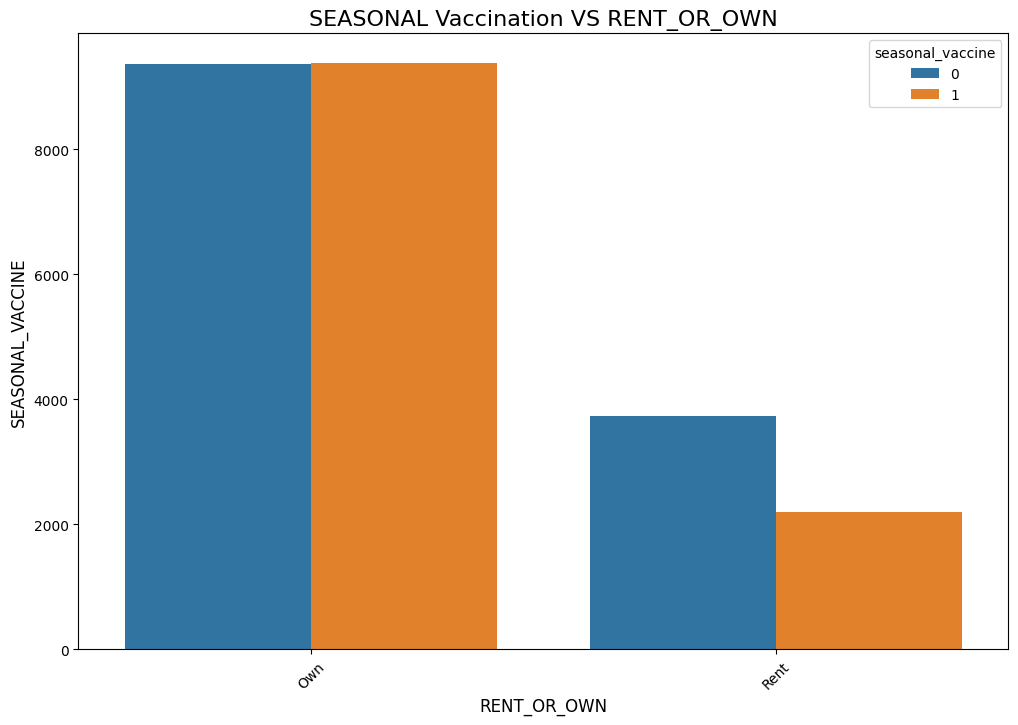

In [151]:
plot_count(x='rent_or_own', data=df_seasonal_vaccine)


**Homeownership appears associated with slightly higher vaccination rates, potentially linked to socioeconomic stability**

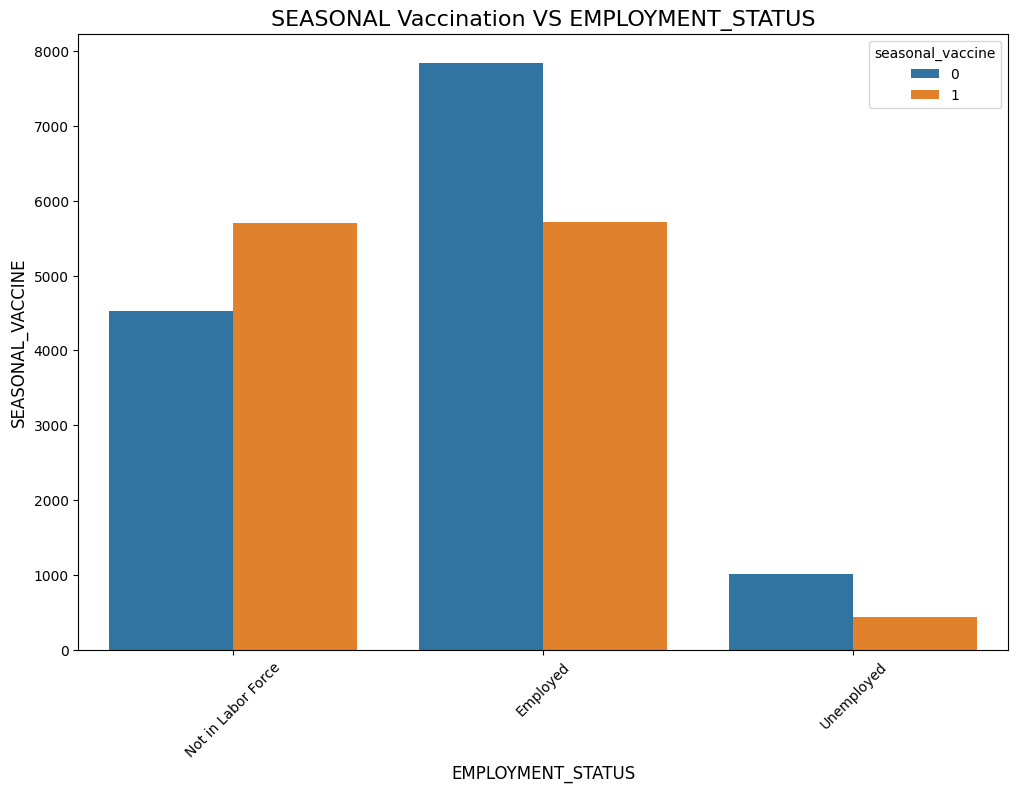

In [152]:
plot_count(x='employment_status', data=df_seasonal_vaccine)

**Employed individuals have the highest seasonal vaccination rates, while those not in the labor force or unemployed show lower vaccination uptake. Employment status may influence vaccination likelihood.**

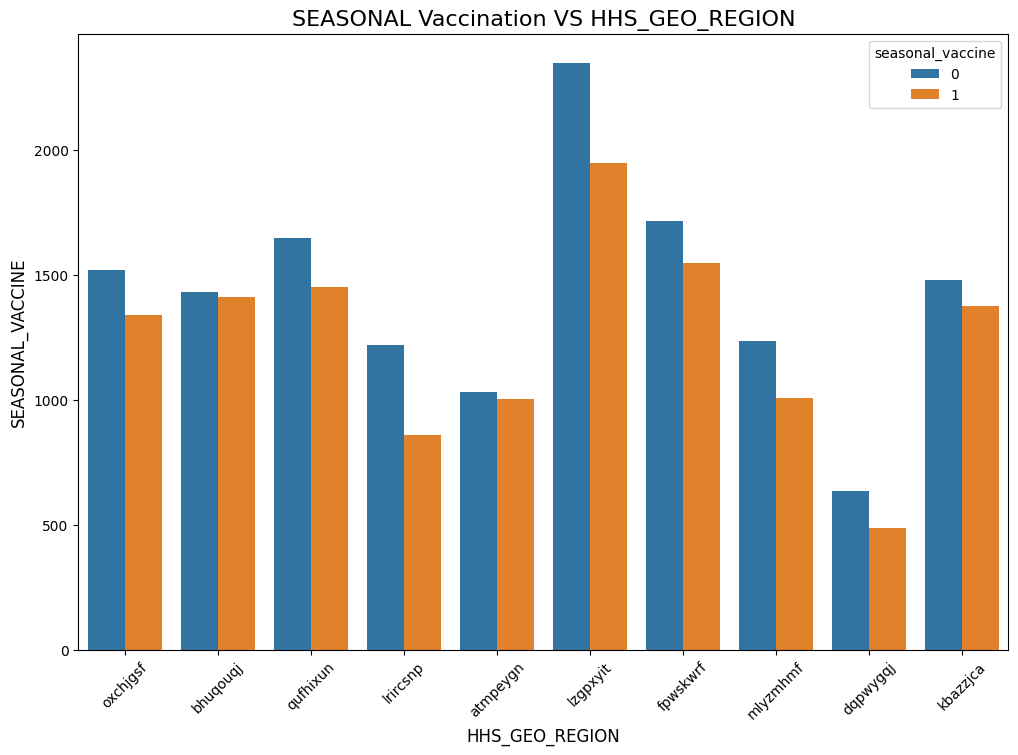

In [153]:
plot_count(x='hhs_geo_region', data=df_seasonal_vaccine)

**Different regions show varying levels of seasonal vaccine uptake. Some regions have more unvaccinated people (e.g., "izpxyibt"), while others have a more balanced number of vaccinated and unvaccinated individuals. Overall, vaccine adoption is uneven across regions.**

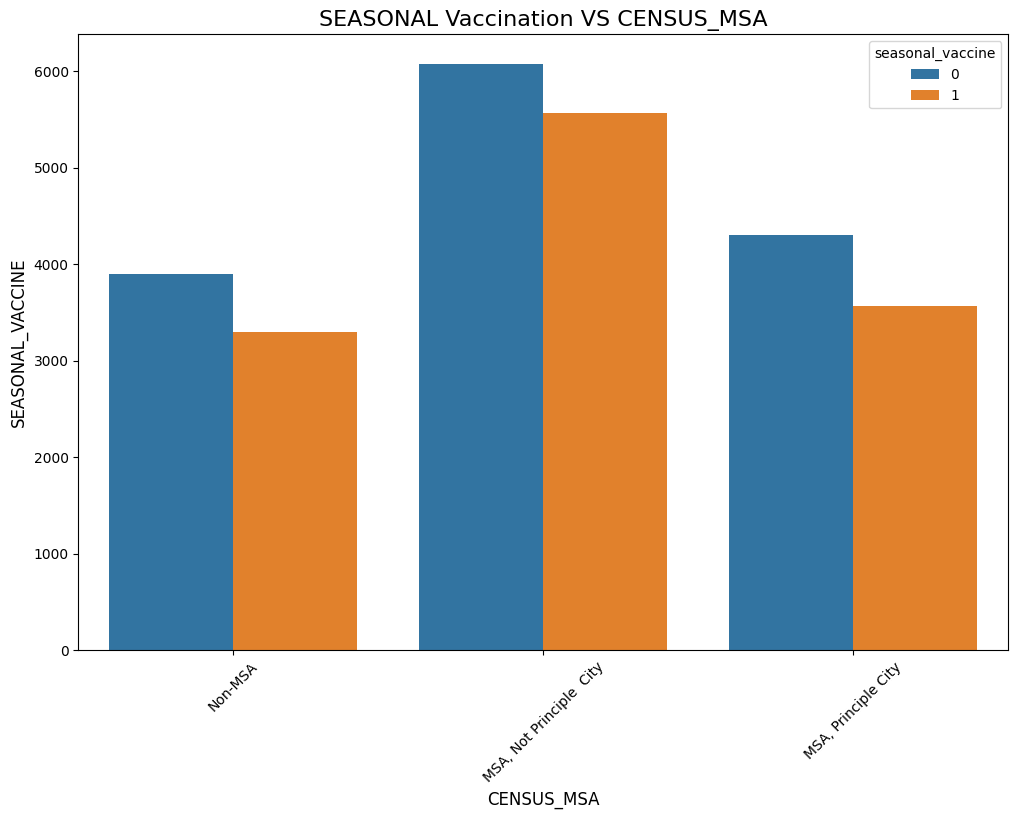

In [154]:
plot_count(x='census_msa', data=df_seasonal_vaccine)

**Seasonal vaccination rates are low across all Census MSA categories. Most individuals are unvaccinated, with "MSA, Not Principal City" having the largest overall population and unvaccinated count, while "Non-MSA" has the fewest in both groups.**

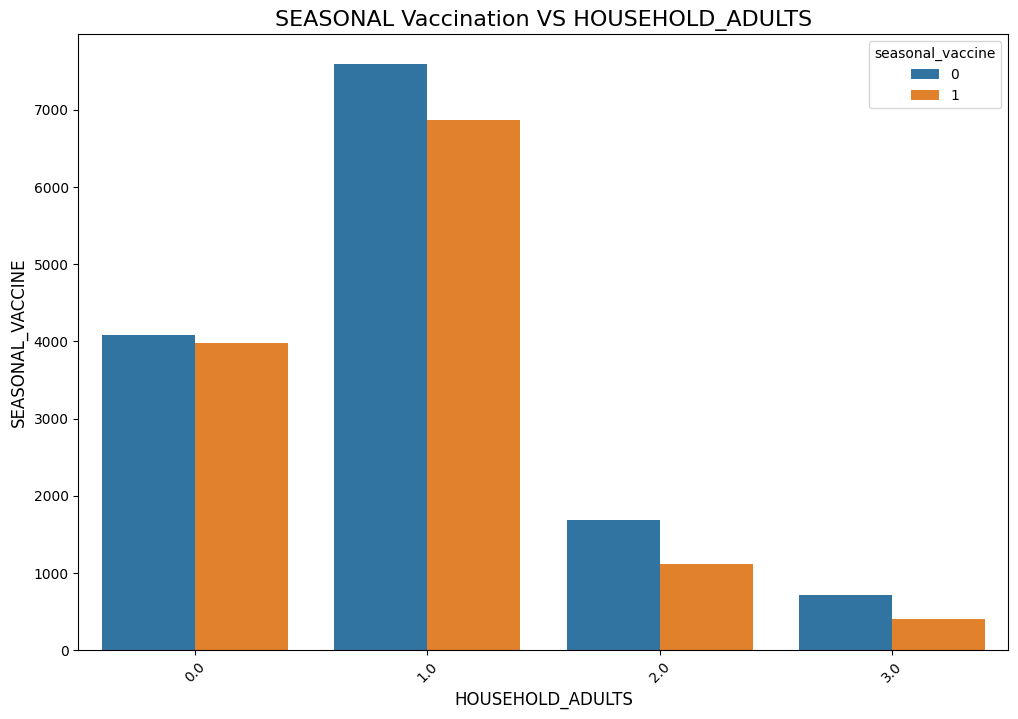

In [155]:
plot_count(x='household_adults', data=df_seasonal_vaccine)

**Seasonal vaccination rates are low across all household sizes. Households with 1 adult have the highest counts of both vaccinated and unvaccinated individuals, while vaccination decreases in larger households.**

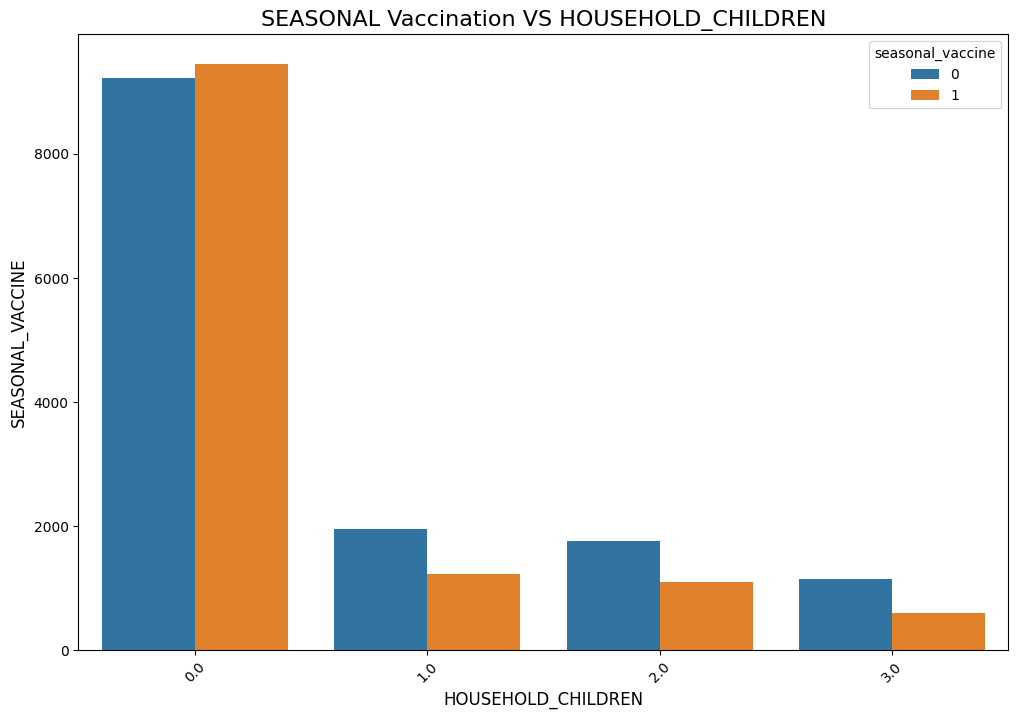

In [156]:
plot_count(x='household_children', data=df_seasonal_vaccine)

**Seasonal vaccination rates are highest in households without children and decline as the number of children increases. Unvaccinated individuals consistently outnumber vaccinated ones across all household sizes**

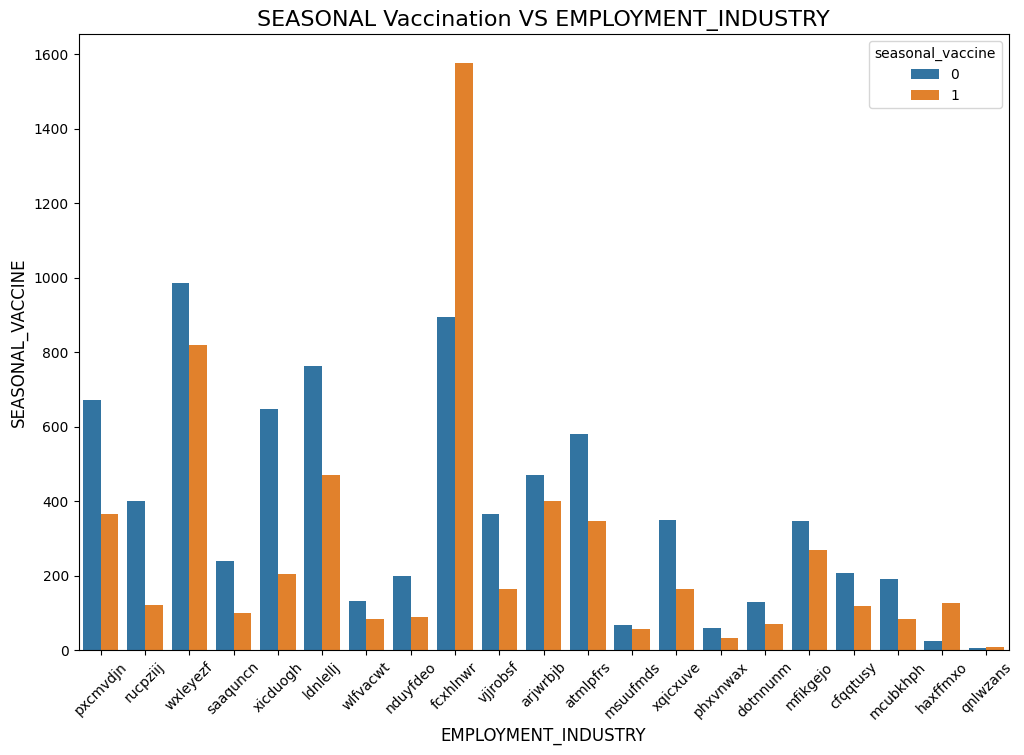

In [157]:
plot_count(x='employment_industry', data=df_seasonal_vaccine)

**Seasonal vaccination rates vary significantly across employment industries, with most industries having far more unvaccinated individuals than vaccinated ones. Targeted efforts are needed to address these disparities and improve vaccine uptake**

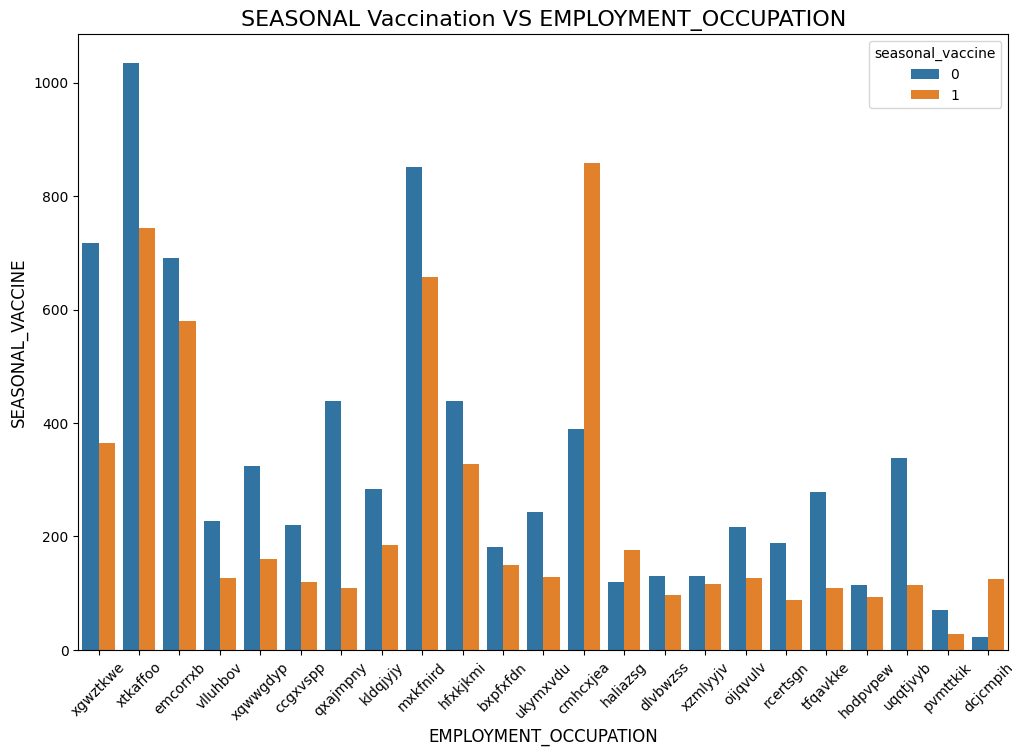

In [158]:
plot_count(x='employment_occupation', data=df_seasonal_vaccine)

**Seasonal vaccination rates are low across most occupations, with unvaccinated individuals far outnumbering vaccinated ones. Efforts should focus on boosting vaccine uptake, particularly in occupations with minimal participation.**

### **Conclusion for the Bi-Variate Analysis:**
**Seasonal vaccination rates are low overall, with most people remaining unvaccinated. Doctor recommendations, chronic conditions, and health-conscious behaviors (e.g., handwashing, mask use) increase uptake slightly. Older adults, those with higher education, income, or health insurance are more likely to vaccinate. Perceptions of vaccine effectiveness and flu risk strongly influence decisions, while fear of side effects reduces uptake. Regional, demographic, and behavioral disparities highlight the need for targeted efforts.**

## **TRAINNG AND TESTING of MODEL**

In [159]:
# Define our X and y
X = df_seasonal_vaccine.drop(columns = ['respondent_id',  'seasonal_vaccine'], axis=1)
y = df_seasonal_vaccine['seasonal_vaccine']

In [160]:
# Train - Test Set Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42 )

In [161]:
# Set up lists for each columns datatypes
num_cols_seasonal = []
ohe_cols_seasonal = []
freq_cols_seasonal = []

for d in X.columns:
    if X[d].dtype in ['float64', 'int64']:
        num_cols_seasonal.append(d)
    elif X[d].nunique() < 10:
        ohe_cols_seasonal.append(d)
    else:
        freq_cols_seasonal.append(d)

In [162]:
# We wanted to see each column category
print(f'Numerical Columns related to seasonal vaccine data: {num_cols_seasonal}')
print('\n')

print(f'Categorical Columns with less than 10 unique values (for One-Hot Encoding): {ohe_cols_seasonal}')
print('\n')

print(f'Categorical Columns with more than 10 unique values (for Frequency Encoding): {freq_cols_seasonal}')


Numerical Columns related to seasonal vaccine data: ['behavioral_antiviral_meds', 'behavioral_avoidance', 'behavioral_face_mask', 'behavioral_wash_hands', 'behavioral_large_gatherings', 'behavioral_outside_home', 'behavioral_touch_face', 'doctor_recc_seasonal', 'chronic_med_condition', 'child_under_6_months', 'health_worker', 'health_insurance', 'opinion_seas_vacc_effective', 'opinion_seas_risk', 'opinion_seas_sick_from_vacc', 'household_adults', 'household_children']


Categorical Columns with less than 10 unique values (for One-Hot Encoding): ['age_group', 'education', 'race', 'sex', 'income_poverty', 'marital_status', 'rent_or_own', 'employment_status', 'census_msa']


Categorical Columns with more than 10 unique values (for Frequency Encoding): ['hhs_geo_region', 'employment_industry', 'employment_occupation']


In [163]:
# Preprocessing with Pipelines
num_transformer_seasonal = Pipeline(steps=[
    ('num_imputer', IterativeImputer(max_iter=100, random_state=42)),   # replace missing values by IterativeImputer
    ('minmaxscaler', MinMaxScaler())                                    # Scale the numbers by MinMaxScaler
])

ohe_transformer_seasonal = Pipeline(steps=[
    ('ohe_imputer', SimpleImputer(strategy='constant', fill_value='Unknown')),  # replace missing categories by SimpleImputer
    ('ohe_encoder', OneHotEncoder(handle_unknown='ignore'))                     # Transform each category into a new column
])

freq_transformer_seasonal = Pipeline(steps=[
    ('freq_encoder', ce.count.CountEncoder(normalize=True, min_group_size=.05)), # replace category names with frequency counts by CountEncoder
    ('freq_imputer', IterativeImputer(max_iter=100, random_state=42))            # replace missing values by IterativeImputer
])

In [164]:
# Preprocessor defined using ColumnTransformer by packaging the all components together
preprocessor_seasonal= ColumnTransformer(
    transformers=[
        ('num', num_transformer_seasonal, num_cols_seasonal),
        ('ohe', ohe_transformer_seasonal, ohe_cols_seasonal),
        ('freq', freq_transformer_seasonal, freq_cols_seasonal)
    ])

In [165]:
# Fitting preprocessor to see the components as a whole
preprocessor_seasonal.fit(X_train)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('num_imputer',
                                                  IterativeImputer(max_iter=100,
                                                                   random_state=42)),
                                                 ('minmaxscaler',
                                                  MinMaxScaler())]),
                                 ['behavioral_antiviral_meds',
                                  'behavioral_avoidance',
                                  'behavioral_face_mask',
                                  'behavioral_wash_hands',
                                  'behavioral_large_gatherings',
                                  'behavioral_outside_home',
                                  'behavioral_touch_face',
                                  'doctor_recc_season...
                                 ['age_group', 'education', 'race', 'sex',
                                  'income_poverty', 'marital_status',
                                  'rent_or_own', 'employment_status',
                                  'census_msa']),
                                ('freq',
                                 Pipeline(steps=[('freq_encoder',
                                                  CountEncoder(combine_min_nan_groups=True,
                                                               min_group_size=0.05,
                                                               normalize=True)),
                                                 ('freq_imputer',
                                                  IterativeImputer(max_iter=100,
                                                                   random_state=42))]),
                                 ['hhs_geo_region', 'employment_industry',
                                  'employment_occupation'])])

In [166]:
# Let'see what this looks like after the preprocessor transformation
X_train_transformed_seasonal = preprocessor_seasonal.transform(X_train)
X_train_transformed_seasonal.shape

(21365, 53)

In [167]:
# Visualize it with Pandas dataframe
pd.DataFrame(X_train_transformed_seasonal).head()

0    1         2         3    4         5    6         7    8    9   \
0  0.007537  1.0  0.034474  0.919025  0.0  1.000000  1.0  0.140203  1.0  0.0   
1  1.000000  1.0  1.000000  0.919025  1.0  1.000000  1.0  0.140203  0.0  0.0   
2  0.007537  0.0  0.034474  0.919025  0.0  1.000000  0.0  0.140203  0.0  0.0   
3  0.007537  0.0  0.034474  0.000000  0.0  0.013708  0.0  0.140203  0.0  0.0   
4  0.007537  0.0  0.034474  0.919025  0.0  0.013708  0.0  0.140203  0.0  0.0   

         10        11    12    13    14        15        16   17   18   19  \
0  0.059194  0.000000  0.75  0.75  0.25  0.333333  0.000000  0.0  0.0  1.0   
1  0.059194  0.686242  1.00  0.75  0.75  0.000000  0.000000  0.0  0.0  1.0   
2  0.059194  0.916514  0.00  0.75  0.00  0.333333  0.333333  0.0  1.0  0.0   
3  0.059194  0.916514  0.75  0.25  0.25  0.000000  0.000000  0.0  0.0  1.0   
4  0.059194  0.916514  1.00  0.25  1.00  0.333333  0.333333  0.0  0.0  0.0   

    20   21   22   23   24   25   26   27   28   29   30   31   32   33   34  \
0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  1.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0   
4  0.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0   

    35   36   37   38   39   40   41   42   43   44   45   46   47   48   49  \
0  1.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0   
1  0.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0   
2  0.0  1.0  1.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0   
3  0.0  1.0  0.0  1.0  0.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0   
4  0.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0   

         50        51        52  
0  0.159420  0.497402  0.502504  
1  0.159420  0.066791  0.374865  
2  0.117061  0.341774  0.065809  
3  0.105032  0.341774  0.374865  
4  0.082659  0.497402  0.502504

## **Modeling Iterations**

### **MODEL 1: Decision Tree Classifier**

In [168]:
# Setting up the DecisionTreeClassifier to go though the pipeline
dtc_seasonal = Pipeline(steps=[
    ('preprocessor_seasonal', preprocessor_seasonal),
    ('classifier', DecisionTreeClassifier(class_weight='balanced', max_depth = 5))
])


In [169]:
# fitting the model to the training data
dtc_seasonal.fit(X_train, y_train)

Pipeline(steps=[('preprocessor_seasonal',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   IterativeImputer(max_iter=100,
                                                                                    random_state=42)),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['behavioral_antiviral_meds',
                                                   'behavioral_avoidance',
                                                   'behavioral_face_mask',
                                                   'behavioral_wash_hands',
                                                   'behavioral_large_gatherings',
                                                   'behavioral_outside_home',
                                                   'b...
                                                   'employment_status',
                                                   'census_msa']),
                                                 ('freq',
                                                  Pipeline(steps=[('freq_encoder',
                                                                   CountEncoder(combine_min_nan_groups=True,
                                                                                min_group_size=0.05,
                                                                                normalize=True)),
                                                                  ('freq_imputer',
                                                                   IterativeImputer(max_iter=100,
                                                                                    random_state=42))]),
                                                  ['hhs_geo_region',
                                                   'employment_industry',
                                                   'employment_occupation'])])),
                ('classifier',
                 DecisionTreeClassifier(class_weight='balanced', max_depth=5))])

              precision    recall  f1-score   support

           0       0.79      0.74      0.77      2891
           1       0.72      0.77      0.74      2451

    accuracy                           0.76      5342
   macro avg       0.76      0.76      0.76      5342
weighted avg       0.76      0.76      0.76      5342



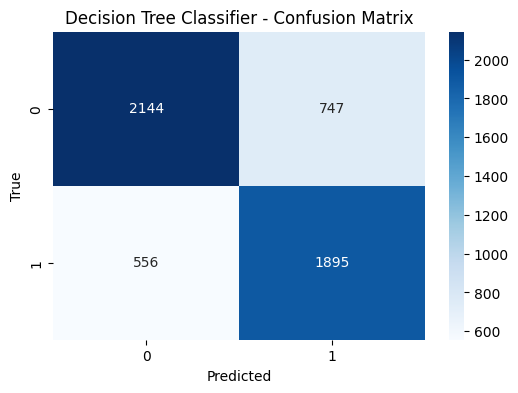

Train F1 Score (Micro) for Decision Tree Classifier is : 0.7553007254856073
Test F1 Score (Micro) for Decision Tree Classifier is : 0.7560838637214526
The Roc_Auc score for Decision Tree Classifier is : 0.8263763609711253


In [170]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Predictions for test and train sets
pred_seasonal1 = dtc_seasonal.predict(X_test)
train_pred_seasonal1 = dtc_seasonal.predict(X_train)

# Classification report for test set
print(classification_report(y_test, pred_seasonal1))

# Confusion matrix
cm = confusion_matrix(y_test, pred_seasonal1)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Decision Tree Classifier - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# F1 scores for training and testing datasets using micro average
train_score_1 = f1_score(y_train, train_pred_seasonal1, average='micro')
score_1 = f1_score(y_test, pred_seasonal1, average='micro')

# Print F1 scores
print('Train F1 Score (Micro) for Decision Tree Classifier is : {}'.format(train_score_1))
print('Test F1 Score (Micro) for Decision Tree Classifier is : {}'.format(score_1))


# Print roc auc scores
roc_auc = roc_auc_score(y_test, dtc_seasonal.predict_proba(X_test)[:, 1])
print('The Roc_Auc score for Decision Tree Classifier is : {}'.format(roc_auc))


### **MODEL 2: Logistic Regression**

In [171]:
# Setting up the logistic regression model to go through the pipeline
logreg_seasonal = Pipeline(steps=[
    ('preprocessor_seasonal', preprocessor_seasonal),
    ('classifier', LogisticRegression(max_iter=500, C=1, class_weight= 'balanced', solver= 'lbfgs',
                                      random_state=42))
])

In [172]:
# fitting the model to the training data
logreg_seasonal.fit(X_train, y_train)

Pipeline(steps=[('preprocessor_seasonal',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   IterativeImputer(max_iter=100,
                                                                                    random_state=42)),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['behavioral_antiviral_meds',
                                                   'behavioral_avoidance',
                                                   'behavioral_face_mask',
                                                   'behavioral_wash_hands',
                                                   'behavioral_large_gatherings',
                                                   'behavioral_outside_home',
                                                   'b...
                                                   'census_msa']),
                                                 ('freq',
                                                  Pipeline(steps=[('freq_encoder',
                                                                   CountEncoder(combine_min_nan_groups=True,
                                                                                min_group_size=0.05,
                                                                                normalize=True)),
                                                                  ('freq_imputer',
                                                                   IterativeImputer(max_iter=100,
                                                                                    random_state=42))]),
                                                  ['hhs_geo_region',
                                                   'employment_industry',
                                                   'employment_occupation'])])),
                ('classifier',
                 LogisticRegression(C=1, class_weight='balanced', max_iter=500,
                                    random_state=42))])

              precision    recall  f1-score   support

           0       0.80      0.79      0.80      2891
           1       0.76      0.77      0.77      2451

    accuracy                           0.78      5342
   macro avg       0.78      0.78      0.78      5342
weighted avg       0.78      0.78      0.78      5342



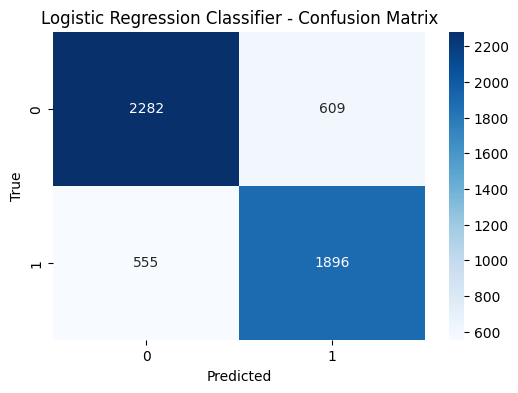

Train F1 Score (Micro) for Logistic Regression Classifier is : 0.774069740229347
Test F1 Score (Micro) for Logistic Regression Classifier is : 0.7821040808685885
The Roc_Auc score for Logistic Regression Classifier is : 0.8502382427152966


In [173]:
# Predictions for test and train sets
pred_seasonal2 = logreg_seasonal.predict(X_test)
train_pred_seasonal2 = logreg_seasonal.predict(X_train)

# Classification report for test set
print(classification_report(y_test, pred_seasonal2))

# Confusion matrix
cm = confusion_matrix(y_test, pred_seasonal2)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Logistic Regression Classifier - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# F1 scores for training and testing datasets using micro average
train_score_2 = f1_score(y_train, train_pred_seasonal2, average='micro')
score_2 = f1_score(y_test, pred_seasonal2, average='micro')

# Print F1 scores
print('Train F1 Score (Micro) for Logistic Regression Classifier is : {}'.format(train_score_2))
print('Test F1 Score (Micro) for Logistic Regression Classifier is : {}'.format(score_2))


# Print roc auc scores
roc_auc = roc_auc_score(y_test, logreg_seasonal.predict_proba(X_test)[:, 1])
print('The Roc_Auc score for Logistic Regression Classifier is : {}'.format(roc_auc))


### **MODEL 3: KNN Classifier**

In [174]:
# Setting up the KNN model to go through the pipeline
knn_seasonal = Pipeline(steps=[
    ('preprocessor_seasonal', preprocessor_seasonal),
    ('classifier', KNeighborsClassifier(n_neighbors=5, p=1, weights= 'distance'))
])

In [175]:
# fitting the model to the training data
knn_seasonal.fit(X_train, y_train)

Pipeline(steps=[('preprocessor_seasonal',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   IterativeImputer(max_iter=100,
                                                                                    random_state=42)),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['behavioral_antiviral_meds',
                                                   'behavioral_avoidance',
                                                   'behavioral_face_mask',
                                                   'behavioral_wash_hands',
                                                   'behavioral_large_gatherings',
                                                   'behavioral_outside_home',
                                                   'b...
                                                   'rent_or_own',
                                                   'employment_status',
                                                   'census_msa']),
                                                 ('freq',
                                                  Pipeline(steps=[('freq_encoder',
                                                                   CountEncoder(combine_min_nan_groups=True,
                                                                                min_group_size=0.05,
                                                                                normalize=True)),
                                                                  ('freq_imputer',
                                                                   IterativeImputer(max_iter=100,
                                                                                    random_state=42))]),
                                                  ['hhs_geo_region',
                                                   'employment_industry',
                                                   'employment_occupation'])])),
                ('classifier', KNeighborsClassifier(p=1, weights='distance'))])

              precision    recall  f1-score   support

           0       0.72      0.72      0.72      2891
           1       0.67      0.66      0.66      2451

    accuracy                           0.69      5342
   macro avg       0.69      0.69      0.69      5342
weighted avg       0.69      0.69      0.69      5342



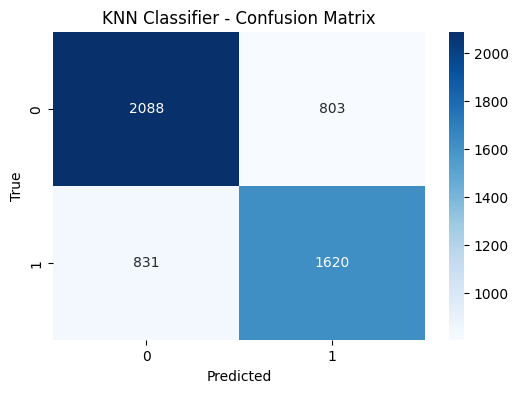

Train F1 Score (Micro) for kNN Classifier is : 0.9997659723847414
Test F1 Score (Micro) for kNN Classifier is : 0.6941220516660427
The Roc_Auc score for kNN Classifier is : 0.7542794143983755


In [176]:
# Predictions for test and train sets
pred_seasonal3 = knn_seasonal.predict(X_test)
train_pred_seasonal3 = knn_seasonal.predict(X_train)

# Classification report for test set
print(classification_report(y_test, pred_seasonal3))

# Confusion matrix
cm = confusion_matrix(y_test, pred_seasonal3)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('KNN Classifier - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# F1 scores for training and testing datasets using micro average
train_score_3 = f1_score(y_train, train_pred_seasonal3, average='micro')
score_3 = f1_score(y_test, pred_seasonal3, average='micro')

# Print F1 scores
print('Train F1 Score (Micro) for kNN Classifier is : {}'.format(train_score_3))
print('Test F1 Score (Micro) for kNN Classifier is : {}'.format(score_3))


# Print roc auc scores
roc_auc = roc_auc_score(y_test, knn_seasonal.predict_proba(X_test)[:, 1])
print('The Roc_Auc score for kNN Classifier is : {}'.format(roc_auc))

### **MODEL 4: Gradient Boosting Classifier**

In [177]:
# Setting up the gradient boosting classifier to go through the pipeline
gbc_seasonal = Pipeline(steps=[
    ('preprocessor_seasonal', preprocessor_seasonal),
    ('classifier', GradientBoostingClassifier(learning_rate= 0.1, max_depth= 5, n_estimators= 200,
        random_state=42))
])

In [178]:
# fitting the model to the training data
gbc_seasonal.fit(X_train, y_train)

Pipeline(steps=[('preprocessor_seasonal',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   IterativeImputer(max_iter=100,
                                                                                    random_state=42)),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['behavioral_antiviral_meds',
                                                   'behavioral_avoidance',
                                                   'behavioral_face_mask',
                                                   'behavioral_wash_hands',
                                                   'behavioral_large_gatherings',
                                                   'behavioral_outside_home',
                                                   'b...
                                                   'census_msa']),
                                                 ('freq',
                                                  Pipeline(steps=[('freq_encoder',
                                                                   CountEncoder(combine_min_nan_groups=True,
                                                                                min_group_size=0.05,
                                                                                normalize=True)),
                                                                  ('freq_imputer',
                                                                   IterativeImputer(max_iter=100,
                                                                                    random_state=42))]),
                                                  ['hhs_geo_region',
                                                   'employment_industry',
                                                   'employment_occupation'])])),
                ('classifier',
                 GradientBoostingClassifier(max_depth=5, n_estimators=200,
                                            random_state=42))])

              precision    recall  f1-score   support

           0       0.80      0.81      0.81      2891
           1       0.77      0.76      0.77      2451

    accuracy                           0.79      5342
   macro avg       0.79      0.79      0.79      5342
weighted avg       0.79      0.79      0.79      5342



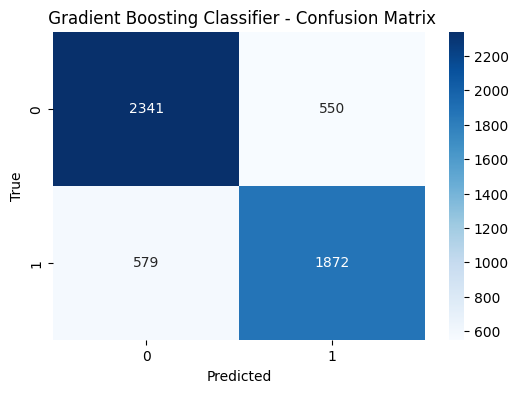

Train F1 Score (Micro) for Gradient Boosting Classifier is : 0.8297215071378423
Test F1 Score (Micro) for Gradient Boosting Classifier is : 0.788655934107076
The Roc_Auc score for Gradient Boosting Classifier is : 0.8572436214699144


In [179]:
# Predictions for test and train sets
pred_seasonal4 = gbc_seasonal.predict(X_test)
train_pred_seasonal4 = gbc_seasonal.predict(X_train)

# Classification report for test set
print(classification_report(y_test, pred_seasonal4))

# Confusion matrix
cm = confusion_matrix(y_test, pred_seasonal4)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(' Gradient Boosting Classifier - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# F1 scores for training and testing datasets using micro average
train_score_4 = f1_score(y_train, train_pred_seasonal4, average='micro')
score_4 = f1_score(y_test, pred_seasonal4, average='micro')

# Print F1 scores
print('Train F1 Score (Micro) for Gradient Boosting Classifier is : {}'.format(train_score_4))
print('Test F1 Score (Micro) for Gradient Boosting Classifier is : {}'.format(score_4))


# Print roc auc scores
roc_auc = roc_auc_score(y_test, gbc_seasonal.predict_proba(X_test)[:, 1])
print('The Roc_Auc score for Gradient Boosting Classifier is : {}'.format(roc_auc))

### **MODEL 5: XG Boosting Classifier**

In [180]:
# Setting up the XG Boosting model to go through the pipeline
xgb_seasonal = Pipeline(steps=[
    ('preprocessor_seasonal', preprocessor_seasonal),
    ('classifier', xgboost.XGBClassifier(learning_rate= 1, max_depth= 2, n_estimators= 100, random_state=42))
])

In [181]:
# fitting the model to the training data
xgb_seasonal.fit(X_train, y_train)

Pipeline(steps=[('preprocessor_seasonal',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   IterativeImputer(max_iter=100,
                                                                                    random_state=42)),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['behavioral_antiviral_meds',
                                                   'behavioral_avoidance',
                                                   'behavioral_face_mask',
                                                   'behavioral_wash_hands',
                                                   'behavioral_large_gatherings',
                                                   'behavioral_outside_home',
                                                   'b...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=2, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=100, n_jobs=None,
                               num_parallel_tree=None, random_state=42, ...))])

              precision    recall  f1-score   support

           0       0.80      0.80      0.80      2891
           1       0.77      0.76      0.77      2451

    accuracy                           0.79      5342
   macro avg       0.78      0.78      0.78      5342
weighted avg       0.79      0.79      0.79      5342



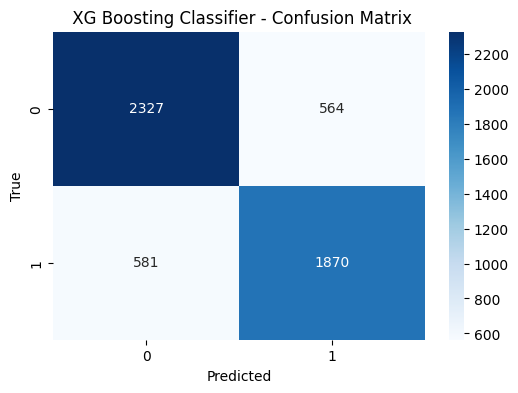

Train F1 Score (Micro) for XG Boosting Classifier is : 0.7916218113737421
Test F1 Score (Micro) for XG Boosting Classifier is : 0.7856608011980531
The Roc_Auc score for XG Boosting Classifier is : 0.8525071335921875


In [182]:
# Predictions for test and train sets
pred_seasonal5 = xgb_seasonal.predict(X_test)
train_pred_seasonal5 = xgb_seasonal.predict(X_train)

# Classification report for test set
print(classification_report(y_test, pred_seasonal5))

# Confusion matrix
cm = confusion_matrix(y_test, pred_seasonal5)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(' XG Boosting Classifier - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# F1 scores for training and testing datasets using micro average
train_score_5 = f1_score(y_train, train_pred_seasonal5, average='micro')
score_5 = f1_score(y_test, pred_seasonal5, average='micro')

# Print F1 scores
print('Train F1 Score (Micro) for XG Boosting Classifier is : {}'.format(train_score_5))
print('Test F1 Score (Micro) for XG Boosting Classifier is : {}'.format(score_5))


# Print roc auc scores
roc_auc = roc_auc_score(y_test, xgb_seasonal.predict_proba(X_test)[:, 1])
print('The Roc_Auc score for XG Boosting Classifier is : {}'.format(roc_auc))

### **MODEL 6: Random Forest Classifier**

In [183]:
# Setting up the RandomForestClassifier to go through the pipeline
rfc_seasonal = Pipeline(steps=[
    ('preprocessor_seasonal', preprocessor_seasonal),
    ('classifier', RandomForestClassifier(class_weight= 'balanced', max_depth= 5, min_samples_leaf= 1,
                                          n_estimators= 200, random_state=42))
])

In [184]:
# fitting the model to the training data
rfc_seasonal.fit(X_train, y_train)

Pipeline(steps=[('preprocessor_seasonal',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('num_imputer',
                                                                   IterativeImputer(max_iter=100,
                                                                                    random_state=42)),
                                                                  ('minmaxscaler',
                                                                   MinMaxScaler())]),
                                                  ['behavioral_antiviral_meds',
                                                   'behavioral_avoidance',
                                                   'behavioral_face_mask',
                                                   'behavioral_wash_hands',
                                                   'behavioral_large_gatherings',
                                                   'behavioral_outside_home',
                                                   'b...
                                                  Pipeline(steps=[('freq_encoder',
                                                                   CountEncoder(combine_min_nan_groups=True,
                                                                                min_group_size=0.05,
                                                                                normalize=True)),
                                                                  ('freq_imputer',
                                                                   IterativeImputer(max_iter=100,
                                                                                    random_state=42))]),
                                                  ['hhs_geo_region',
                                                   'employment_industry',
                                                   'employment_occupation'])])),
                ('classifier',
                 RandomForestClassifier(class_weight='balanced', max_depth=5,
                                        n_estimators=200, random_state=42))])

              precision    recall  f1-score   support

           0       0.79      0.79      0.79      2891
           1       0.76      0.75      0.75      2451

    accuracy                           0.77      5342
   macro avg       0.77      0.77      0.77      5342
weighted avg       0.77      0.77      0.77      5342



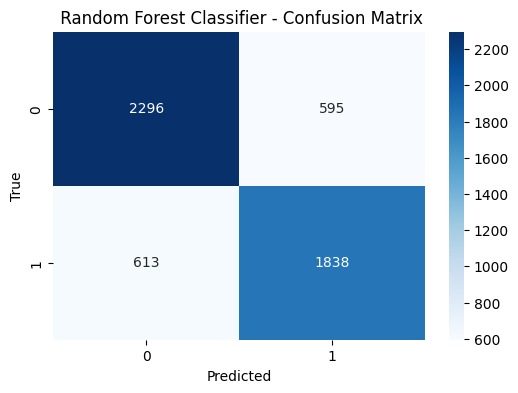

Train F1 Score (Micro) for Random Forest Classifier is : 0.7741165457523987
Test F1 Score (Micro) for Random Forest Classifier is : 0.7738674653687757
The Roc_Auc score for Random Forest Classifier is : 0.8447691671320313


In [185]:
# Predictions for test and train sets
pred_seasonal6 = rfc_seasonal.predict(X_test)
train_pred_seasonal6 = rfc_seasonal.predict(X_train)

# Classification report for test set
print(classification_report(y_test, pred_seasonal6))

# Confusion matrix
cm = confusion_matrix(y_test, pred_seasonal6)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(' Random Forest Classifier - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# F1 scores for training and testing datasets using micro average
train_score_6 = f1_score(y_train, train_pred_seasonal6, average='micro')
score_6 = f1_score(y_test, pred_seasonal6, average='micro')

# Print F1 scores
print('Train F1 Score (Micro) for Random Forest Classifier is : {}'.format(train_score_6))
print('Test F1 Score (Micro) for Random Forest Classifier is : {}'.format(score_6))


# Print roc auc scores
roc_auc = roc_auc_score(y_test, rfc_seasonal.predict_proba(X_test)[:, 1])
print('The Roc_Auc score for Random Forest Classifier is : {}'.format(roc_auc))

**Comparison of Model ROC Curves**

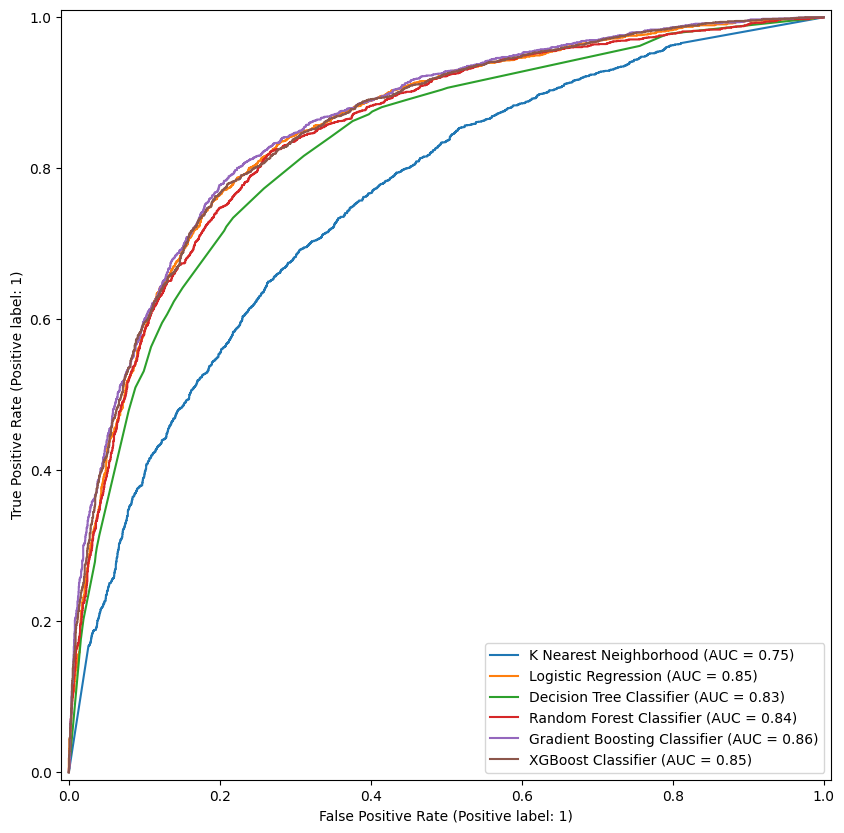

In [186]:
fig, ax = plt.subplots(figsize=(10, 10))
RocCurveDisplay.from_estimator(knn_seasonal, X_test, y_test, name='K Nearest Neighborhood', ax=ax)
RocCurveDisplay.from_estimator(logreg_seasonal, X_test, y_test, name='Logistic Regression', ax=ax)
RocCurveDisplay.from_estimator(dtc_seasonal, X_test, y_test, name='Decision Tree Classifier', ax=ax)
RocCurveDisplay.from_estimator(rfc_seasonal, X_test, y_test, name='Random Forest Classifier', ax=ax)
RocCurveDisplay.from_estimator(gbc_seasonal, X_test, y_test, name='Gradient Boosting Classifier', ax=ax)
RocCurveDisplay.from_estimator(xgb_seasonal, X_test, y_test, name='XGBoost Classifier', ax=ax)

In [189]:

# ROC AUC scores
roc_auc_dtc = roc_auc_score(y_test, dtc_seasonal.predict_proba(X_test)[:, 1])
roc_auc_logreg = roc_auc_score(y_test, logreg_seasonal.predict_proba(X_test)[:, 1])
roc_auc_knn = roc_auc_score(y_test, knn_seasonal.predict_proba(X_test)[:, 1])
roc_auc_gbc = roc_auc_score(y_test, gbc_seasonal.predict_proba(X_test)[:, 1])
roc_auc_xgb = roc_auc_score(y_test, xgb_seasonal.predict_proba(X_test)[:, 1])
roc_auc_rfc = roc_auc_score(y_test, rfc_seasonal.predict_proba(X_test)[:, 1])

# F1 scores
# F1 scores for all models
train_score_seasonal1 = f1_score(y_train, train_pred_seasonal1, average='micro')
test_score_seasonal1 = f1_score(y_test, pred_seasonal1, average='micro')

train_score_seasonal2 = f1_score(y_train, train_pred_seasonal2, average='micro')
test_score_seasonal2 = f1_score(y_test, pred_seasonal2, average='micro')

train_score_seasonal3 = f1_score(y_train, train_pred_seasonal3, average='micro')
test_score_seasonal3 = f1_score(y_test, pred_seasonal3, average='micro')

train_score_seasonal4 = f1_score(y_train, train_pred_seasonal4, average='micro')
test_score_seasonal4 = f1_score(y_test, pred_seasonal4, average='micro')

train_score_seasonal5 = f1_score(y_train, train_pred_seasonal5, average='micro')
test_score_seasonal5 = f1_score(y_test, pred_seasonal5, average='micro')

train_score_seasonal6 = f1_score(y_train, train_pred_seasonal6, average='micro')
test_score_seasonal6 = f1_score(y_test, pred_seasonal6, average='micro')


# Create a DataFrame with ROC AUC and F1 scores
metrics_df_seasonal = pd.DataFrame({
    'Model': ['Decision Tree', 'Logistic Regression', 'KNN', 'Gradient Boosting', 'XGBoost', 'Random Forest'],
    'ROC AUC': [roc_auc_dtc, roc_auc_logreg, roc_auc_knn, roc_auc_gbc, roc_auc_xgb, roc_auc_rfc],
    'Train F1 Score': [
        train_score_seasonal1,
        train_score_seasonal2,
        train_score_seasonal3,
        train_score_seasonal4,
        train_score_seasonal5,
        train_score_seasonal6
    ],
    'Test F1 Score': [
        test_score_seasonal1,
        test_score_seasonal2,
        test_score_seasonal3,
        test_score_seasonal4,
        test_score_seasonal5,
        test_score_seasonal6
    ]
})





In [190]:
metrics_df_seasonal

Model   ROC AUC  Train F1 Score  Test F1 Score
0        Decision Tree  0.826376        0.755301       0.756084
1  Logistic Regression  0.850238        0.774070       0.782104
2                  KNN  0.754279        0.999766       0.694122
3    Gradient Boosting  0.857244        0.829722       0.788656
4              XGBoost  0.852507        0.791622       0.785661
5        Random Forest  0.844769        0.774117       0.773867

**The Gradient Boosting Classifier is the best model for predicting Seasonal where high scores for both F1 Score 82.97% and ROC AUC 85.72% where it is performing really well.**

## **Final Model: Gradient Boosting Classifier**

In [191]:
final_model_seasonal = Pipeline(steps=[
    ('preprocessor_seasonal', preprocessor_seasonal),
    ('classifier', GradientBoostingClassifier(learning_rate =0.1, n_estimators=200,
                                              max_depth=5,
                                              random_state=42))
])


In [192]:
output_final_model_seasonal = final_model_seasonal.fit(X_train, y_train)

              precision    recall  f1-score   support

           0       0.80      0.81      0.81      2891
           1       0.77      0.76      0.77      2451

    accuracy                           0.79      5342
   macro avg       0.79      0.79      0.79      5342
weighted avg       0.79      0.79      0.79      5342



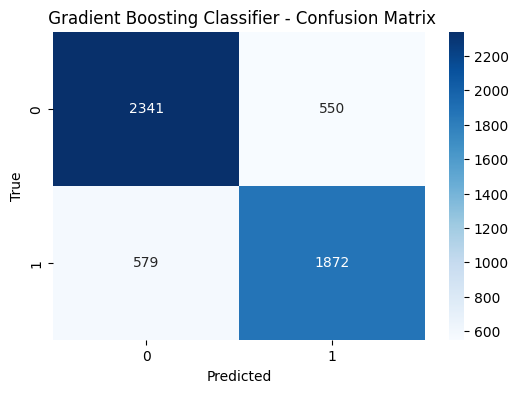

Train F1 Score (Micro) for Gradient Boosting Classifier is : 0.8297215071378423
Test F1 Score (Micro) for Gradient Boosting Classifier is : 0.788655934107076
The Roc_Auc score for Gradient Boosting Classifier is : 0.8572436214699144


In [193]:
# Predictions for test and train sets
final_pred_seasonal = final_model_seasonal.predict(X_test)
train_final_pred_seasonal = final_model_seasonal.predict(X_train)

# Classification report for test set
print(classification_report(y_test, final_pred_seasonal))

# Confusion matrix
cm = confusion_matrix(y_test, final_pred_seasonal)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(' Gradient Boosting Classifier - Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# F1 scores for training and testing datasets using micro average
train_score_1 = f1_score(y_train, train_final_pred_seasonal, average='micro')
score_1 = f1_score(y_test, final_pred_seasonal, average='micro')

# Print F1 scores
print('Train F1 Score (Micro) for Gradient Boosting Classifier is : {}'.format(train_score_1))
print('Test F1 Score (Micro) for Gradient Boosting Classifier is : {}'.format(score_1))


# Print roc auc scores
roc_auc = roc_auc_score(y_test, final_model_seasonal.predict_proba(X_test)[:, 1])
print('The Roc_Auc score for Gradient Boosting Classifier is : {}'.format(roc_auc))

**Feature Importance**

In [194]:
# Accessing the features of the preproccesor
final_model_seasonal['preprocessor_seasonal']

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('num_imputer',
                                                  IterativeImputer(max_iter=100,
                                                                   random_state=42)),
                                                 ('minmaxscaler',
                                                  MinMaxScaler())]),
                                 ['behavioral_antiviral_meds',
                                  'behavioral_avoidance',
                                  'behavioral_face_mask',
                                  'behavioral_wash_hands',
                                  'behavioral_large_gatherings',
                                  'behavioral_outside_home',
                                  'behavioral_touch_face',
                                  'doctor_recc_season...
                                 ['age_group', 'education', 'race', 'sex',
                                  'income_poverty', 'marital_status',
                                  'rent_or_own', 'employment_status',
                                  'census_msa']),
                                ('freq',
                                 Pipeline(steps=[('freq_encoder',
                                                  CountEncoder(combine_min_nan_groups=True,
                                                               min_group_size=0.05,
                                                               normalize=True)),
                                                 ('freq_imputer',
                                                  IterativeImputer(max_iter=100,
                                                                   random_state=42))]),
                                 ['hhs_geo_region', 'employment_industry',
                                  'employment_occupation'])])

In [195]:
# We are looking at the shape of the preprocessor transformation.
final_model_seasonal['preprocessor_seasonal'].fit_transform(X_train).shape

(21365, 53)

In [196]:
# We are looking at the transformed data
pd.DataFrame(final_model_seasonal['preprocessor_seasonal'].fit_transform(X_train)).head()

0    1         2         3    4         5    6         7    8    9   \
0  0.007537  1.0  0.034474  0.919025  0.0  1.000000  1.0  0.140203  1.0  0.0   
1  1.000000  1.0  1.000000  0.919025  1.0  1.000000  1.0  0.140203  0.0  0.0   
2  0.007537  0.0  0.034474  0.919025  0.0  1.000000  0.0  0.140203  0.0  0.0   
3  0.007537  0.0  0.034474  0.000000  0.0  0.013708  0.0  0.140203  0.0  0.0   
4  0.007537  0.0  0.034474  0.919025  0.0  0.013708  0.0  0.140203  0.0  0.0   

         10        11    12    13    14        15        16   17   18   19  \
0  0.059194  0.000000  0.75  0.75  0.25  0.333333  0.000000  0.0  0.0  1.0   
1  0.059194  0.686242  1.00  0.75  0.75  0.000000  0.000000  0.0  0.0  1.0   
2  0.059194  0.916514  0.00  0.75  0.00  0.333333  0.333333  0.0  1.0  0.0   
3  0.059194  0.916514  0.75  0.25  0.25  0.000000  0.000000  0.0  0.0  1.0   
4  0.059194  0.916514  1.00  0.25  1.00  0.333333  0.333333  0.0  0.0  0.0   

    20   21   22   23   24   25   26   27   28   29   30   31   32   33   34  \
0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0   
1  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  1.0   
2  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0   
3  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0   
4  0.0  1.0  0.0  0.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0   

    35   36   37   38   39   40   41   42   43   44   45   46   47   48   49  \
0  1.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0   
1  0.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0   
2  0.0  1.0  1.0  0.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0   
3  0.0  1.0  0.0  1.0  0.0  1.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0   
4  0.0  0.0  0.0  1.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  1.0  0.0   

         50        51        52  
0  0.159420  0.497402  0.502504  
1  0.159420  0.066791  0.374865  
2  0.117061  0.341774  0.065809  
3  0.105032  0.341774  0.374865  
4  0.082659  0.497402  0.502504

In [197]:
# We are looking at the feature importances coming out of. the gradient boosting classifier
final_model_seasonal['classifier'].feature_importances_

array([0.0041617 , 0.00199471, 0.00355142, 0.00290589, 0.00173822,
       0.00286419, 0.006683  , 0.18246968, 0.00751721, 0.00444598,
       0.02469147, 0.07736442, 0.2777085 , 0.16286631, 0.03156636,
       0.00608843, 0.00833899, 0.0252504 , 0.00264383, 0.00153973,
       0.00534738, 0.05529616, 0.00158432, 0.00489435, 0.00642995,
       0.00214127, 0.00087868, 0.00489672, 0.00389157, 0.0021603 ,
       0.00607559, 0.00180822, 0.00118785, 0.00139175, 0.00560413,
       0.0034971 , 0.00106381, 0.0019862 , 0.00231517, 0.00082912,
       0.00157732, 0.00746233, 0.00142635, 0.00122228, 0.00222016,
       0.00211698, 0.0007796 , 0.00299189, 0.00153738, 0.00240184,
       0.014949  , 0.00704227, 0.00460253])

In [198]:
# These are ohe_transformed columns!
ohe_cols_seasonal_transformed = final_model_seasonal['preprocessor_seasonal'].transformers_[1][1]['ohe_encoder'].get_feature_names_out(ohe_cols)
ohe_cols_seasonal_transformed


array(['age_group_18 - 34 Years', 'age_group_35 - 44 Years',
       'age_group_45 - 54 Years', 'age_group_55 - 64 Years',
       'age_group_65+ Years', 'education_12 Years',
       'education_< 12 Years', 'education_College Graduate',
       'education_Some College', 'education_Unknown', 'race_Black',
       'race_Hispanic', 'race_Other or Multiple', 'race_White',
       'sex_Female', 'sex_Male',
       'income_poverty_<= $75,000, Above Poverty',
       'income_poverty_> $75,000', 'income_poverty_Below Poverty',
       'income_poverty_Unknown', 'marital_status_Married',
       'marital_status_Not Married', 'marital_status_Unknown',
       'rent_or_own_Own', 'rent_or_own_Rent', 'rent_or_own_Unknown',
       'employment_status_Employed',
       'employment_status_Not in Labor Force',
       'employment_status_Unemployed', 'employment_status_Unknown',
       'census_msa_MSA, Not Principle  City',
       'census_msa_MSA, Principle City', 'census_msa_Non-MSA'],
      dtype=object)

In [199]:
# Name of the numerical columns
num_cols_seasonal

['behavioral_antiviral_meds',
 'behavioral_avoidance',
 'behavioral_face_mask',
 'behavioral_wash_hands',
 'behavioral_large_gatherings',
 'behavioral_outside_home',
 'behavioral_touch_face',
 'doctor_recc_seasonal',
 'chronic_med_condition',
 'child_under_6_months',
 'health_worker',
 'health_insurance',
 'opinion_seas_vacc_effective',
 'opinion_seas_risk',
 'opinion_seas_sick_from_vacc',
 'household_adults',
 'household_children']

In [200]:
# Putting all columns together
final_cols_seasonal = [*num_cols_seasonal, *ohe_cols_seasonal_transformed, *freq_cols_seasonal]
final_cols_seasonal

['behavioral_antiviral_meds',
 'behavioral_avoidance',
 'behavioral_face_mask',
 'behavioral_wash_hands',
 'behavioral_large_gatherings',
 'behavioral_outside_home',
 'behavioral_touch_face',
 'doctor_recc_seasonal',
 'chronic_med_condition',
 'child_under_6_months',
 'health_worker',
 'health_insurance',
 'opinion_seas_vacc_effective',
 'opinion_seas_risk',
 'opinion_seas_sick_from_vacc',
 'household_adults',
 'household_children',
 'age_group_18 - 34 Years',
 'age_group_35 - 44 Years',
 'age_group_45 - 54 Years',
 'age_group_55 - 64 Years',
 'age_group_65+ Years',
 'education_12 Years',
 'education_< 12 Years',
 'education_College Graduate',
 'education_Some College',
 'education_Unknown',
 'race_Black',
 'race_Hispanic',
 'race_Other or Multiple',
 'race_White',
 'sex_Female',
 'sex_Male',
 'income_poverty_<= $75,000, Above Poverty',
 'income_poverty_> $75,000',
 'income_poverty_Below Poverty',
 'income_poverty_Unknown',
 'marital_status_Married',
 'marital_status_Not Married',
 'ma

In [201]:
# Name of the frequency columns
freq_cols_seasonal

['hhs_geo_region', 'employment_industry', 'employment_occupation']

In [202]:
# Put together the final cols and the feature importances
# Then sort them by feature importances
import pandas as pd

# Create a dictionary where the feature names are the keys and their importance values are the values
feature_importance_dict_seasonal = dict(zip(final_cols, final_model_seasonal['classifier'].feature_importances_))


# Convert the dictionary to a DataFrame and sort by the importance values
feature_importance_df_seasonal = pd.DataFrame.from_dict(feature_importance_dict_seasonal, orient='index', columns=['Importance'])
feature_importance_df_seasonal.sort_values(by='Importance', ascending=False, inplace=True)

# Display the result
feature_importance_df_seasonal


Importance
child_under_6_months                        0.277708
behavioral_outside_home                     0.182470
health_worker                               0.162866
chronic_med_condition                       0.077364
household_adults                            0.055296
health_insurance                            0.031566
opinion_h1n1_sick_from_vacc                 0.025250
doctor_recc_seasonal                        0.024691
employment_status_Not in Labor Force        0.014949
opinion_h1n1_risk                           0.008339
behavioral_touch_face                       0.007517
income_poverty_Below Poverty                0.007462
employment_status_Unemployed                0.007042
behavioral_large_gatherings                 0.006683
age_group_35 - 44 Years                     0.006430
opinion_h1n1_vacc_effective                 0.006088
education_College Graduate                  0.006076
race_Hispanic                               0.005604
opinion_seas_sick_from_vacc                 0.005347
age_group_65+ Years                         0.004897
age_group_18 - 34 Years                     0.004894
employment_status_Unknown                   0.004603
doctor_recc_h1n1                            0.004446
h1n1_concern                                0.004162
education_12 Years                          0.003892
behavioral_antiviral_meds                   0.003551
race_Other or Multiple                      0.003497
rent_or_own_Rent                            0.002992
behavioral_avoidance                        0.002906
behavioral_wash_hands                       0.002864
opinion_seas_vacc_effective                 0.002644
employment_status_Employed                  0.002402
sex_Male                                    0.002315
marital_status_Not Married                  0.002220
education_< 12 Years                        0.002160
age_group_45 - 54 Years                     0.002141
marital_status_Unknown                      0.002117
h1n1_knowledge                              0.001995
sex_Female                                  0.001986
education_Some College                      0.001808
behavioral_face_mask                        0.001738
household_children                          0.001584
income_poverty_> $75,000                    0.001577
opinion_seas_risk                           0.001540
rent_or_own_Unknown                         0.001537
income_poverty_Unknown                      0.001426
race_Black                                  0.001392
marital_status_Married                      0.001222
education_Unknown                           0.001188
race_White                                  0.001064
age_group_55 - 64 Years                     0.000879
income_poverty_<= $75,000, Above Poverty    0.000829
rent_or_own_Own                             0.000780

**The feature importance analysis shows that the most critical factors for predicting vaccination uptake are having a child under 6 months, frequently going outside, being a health worker, and having chronic medical conditions. Household composition, health insurance, and doctor recommendations also significantly influence vaccination. Behavioral and socioeconomic factors, such as opinions on vaccine safety, education, and income, play smaller but notable roles. Personal health circumstances and access to healthcare are key drivers of vaccination decisions.**

## **Final Conclusion**



- The Gradient Boosting Classifier excels in predicting both H1N1 and seasonal flu vaccination uptake, achieving high F1 Scores (89.17% for H1N1 and 82.97% for Seasonal) and strong ROC AUC values (86.69% for H1N1 and 85.72% for Seasonal).
- Important factors for deciding to get vaccinated include having a young child, being a health worker, going outside often, having chronic health issues, and getting advice from doctors. Other factors like household setup, health insurance, and beliefs about vaccine safety also play a role, but are less important.


**The project offers a detailed analysis of vaccination prediction data, highlighting the key factors influencing vaccination uptake. These insights are valuable for informing public health strategies and enhancing vaccination rates**